In [ ]:
import scipy.stats as sps
import seaborn as sns
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import itertools
import matplotlib.ticker as ticker
from tqdm.notebook import tqdm
from scipy.special import comb, kolmogi

# ЭФР

In [ ]:
def EDF(x: np.array, arr: np.array):
  return np.array(list([len(np.where(arr <= x[i])[0]) / len(arr) for i in range(len(x))]))

def EDF_2d(x: np.array, y: np.array, X: np.array, Y: np.array) -> np.array:
  if len(X) != len(Y):
    print(f'Не совпадают размерности: {len(X)} != {len(Y)}')
    return
  return np.array(list([[np.sum((X <= x[i]) & (Y <= y[j])) / len(X) for j in range(len(y))] for i in range(len(x))]))

# Критерии

In [ ]:
np.repeat([[1], [2], [3], [4]], 3, axis=1) * np.array([2, 3, 4])

array([[ 2,  3,  4],
       [ 4,  6,  8],
       [ 6,  9, 12],
       [ 8, 12, 16]])

In [ ]:
# X - матрица, выборка по строке
# F - функция распределения при H_0
# n - размер выборки

def statistic_CvM(X: np.array, F, n: int, transpos=False) -> np.array:
  arr = np.array(list([(2 * i - 1) / (2 * n) for i in range(1, n + 1)]))
  S = F(np.sort(X, axis = 0 if transpos else 1))
  if transpos:
    S = S.T
  T = np.sum((arr - S) ** 2, axis=1) + 1 / (12 * n)
  return T

def statistic_AD(X: np.array, F, n: int, transpos=False) -> np.array:
  arr = np.array(list([(2 * i - 1) / n for i in range(1, n + 1)]))
  S = (np.log(F(np.sort(X, axis = 0 if transpos else 1))) +
        np.log(1 - F(-np.sort(-X, axis = 0 if transpos else 1))))
  if transpos:
    S = S.T
  T = -S.dot(arr) - n
  return T

def statistic_Kolm(X: np.array, F, n: int, transpos=False) -> np.array:
  arr = np.array(list([i / n for i in range(1, n + 1)]))
  S = F(np.sort(X, axis = 0 if transpos else 1))
  if transpos:
    S = S.T
  T = np.max(np.hstack((arr - S, S - arr - 1 / n)), axis=1)
  return T

def statistic_Smir_ind(X: np.array, Y: np.array, x: np.array, y: np.array) -> np.array:
  if X.shape != Y.shape:
    print(f'Не совпадают размерности: {X.shape} != {Y.shape}')
    return
  H = EDF_2d(x, y, X, Y)
  F = EDF(x, X)
  G = EDF(y, Y)
  m = 0
  for i in range(len(x)):
    for j in range(len(y)):
      if np.abs(H[i, j] - F[i] * G[j]) > m:
        m = np.abs(H[i, j] - F[i] * G[j])
  return m

# F_inv - функция, обратная к F
def statistic_chi2(X: np.array, F, F_inv, n: int) -> np.array:
  k = int(n ** (1/5))
  delta = np.empty(k - 1)
  for i in range(k - 1):
    delta[i] = F_inv((i + 1) / k)
  T = (((X < delta[0]).sum(axis=1) - n / k) ** 2) * k / n
  T += (((X >= delta[k - 2]).sum(axis=1) - n / k) ** 2) * k / n
  for i in range(k - 2):
    T += ((((delta[i] <= X) & (X < delta[i + 1])).sum(axis=1) - n / k) ** 2) * k / n
  return T

def statistic_SW_exp(X: np.array, n: int) -> np.array:
 return n * ((X.mean(axis=1) - X.min(axis=1)) ** 2) / ((n - 1) * np.sum((X.T - X.mean(axis=1)) ** 2, axis=0))

def statistic_a_test(X: np.array, n: int) -> np.array:
  # X = ((X.T - X.mean(axis=1)) / X.std(axis=1)).T
  F = sps.expon(scale = X.mean()).cdf
  arr = np.array(list([n - j + 1/2 for j in range(1, n + 1)]))
  return -np.sum(np.log(F(np.sort(X, axis=1))) / arr + np.log(1 - F(np.sort(X, axis=1))) / (n - arr), axis=1)

def statistic_Frozini(X: np.array, n: int) -> np.array:
  arr = np.array(list([(j - 1/2) / n for j in range(1, n + 1)]))
  return np.sum(np.abs(1 - np.exp(-np.sort(X, axis=1).T / X.mean(axis=1)).T - arr), axis=1) / np.sqrt(n)

def statistic_MWW(X: np.array, Y: np.array) -> np.array:
  if X.shape != Y.shape:
    print(f'Разные размерности: {X.shape} != {Y.shape}')
    return
  N, n = X.shape
  return (np.repeat(X, n, axis=1) < np.hstack((list(np.reshape(Y, (1, N, n))) * n))).sum(axis=1) / (n * n)

def statistic_BWS(X: np.array, Y: np.array) -> np.array:
  if len(X) != len(Y):
    print(f'Разное число строк: {len(X)} != {len(Y)}')
    return
  n1, n2 = X.shape[1], Y.shape[1]
  arr11 = np.array(list([(n1 + n2) * i / n2 for i in range(1, n1 + 1)]))
  arr21 = np.array(list([(n1 + n2) * i / n1 for i in range(1, n2 + 1)]))
  arr12 = np.array(list([i / (n1 + 1) * (1 - i / (n1 + 1)) * n2 * (n1 + n2) / n1 for i in range(1, n1 + 1)]))
  arr22 = np.array(list([i / (n2 + 1) * (1 - i / (n2 + 1)) * n1 * (n1 + n2) / n2 for i in range(1, n2 + 1)]))
  ranks = np.argsort(np.argsort(np.hstack((X, Y)), axis=1), axis=1) + 1
  R, S = np.sort(ranks[:, :n1], axis=1), np.sort(ranks[:, n1:], axis=1)
  T = (np.sum((R - arr11) ** 2 / arr12, axis=1) + np.sum((S - arr21) ** 2 / arr22, axis=1)) / (2 * (n1 + n2))
  return T

def frequencies_for_chi2(X: np.array, F_inv, n: int) -> np.array:
  k = int(n ** (1/5))
  delta = np.empty(k - 1)
  for i in range(k - 1):
    delta[i] = F_inv((i + 1) / k)
  v = np.empty((k, X.shape[0]))
  v[0] = (X < delta[0]).sum(axis=1)
  v[k - 1] = (X >= delta[k - 2]).sum(axis=1)
  for i in range(k - 2):
    v[i + 1] = ((delta[i] <= X) & (X < delta[i + 1])).sum(axis=1)
  return v.T

def freq_chi2_2d(X: np.array, Y: np.array, n: int) -> np.array:
  #k = int(n ** (1/5))
  k=3
  order = np.argsort(X)
  X, Y = X[order], Y[order]
  Y_sort = np.sort(Y)
  freq = np.empty((k, k))
  for i in range(k):
    if i == 0:
      cond1 = (X <= X[n // k])
    elif i == k - 1:
      cond1 = (X > X[-n // k])
    else:
      cond1 = ((X[(i * n) // k] < X) & (X <= X[((i + 1) * n) // k]))
    for j in range(k):
      if j == 0:
        cond2 = (Y <= Y_sort[n // k])
      elif j == k - 1:
        cond2 = (Y > Y_sort[-n // k])
      else:
        cond2 = ((Y_sort[(j * n) // k] < Y) & (Y <= Y_sort[((j + 1) * n) // k]))
      freq[i, j] = np.sum(cond1 & cond2)
  return freq
# obs, exp -- наблюдаемые и ожиданиемые частоты соответственной
def general_statistic_chi2(obs: np.array, exp: np.array):
  if len(obs) != len(exp):
    print(f'Разное число наблюдаемых и ожидаемых результатов: {len(obs), len(exp)}')
    return
  return np.sum((obs - exp) ** 2 / exp)
# X -- выборка, separators -- границы полуинтервалов
def frequencies(X: np.array, separators: np.array):
  k = len(separators) - 1
  v = np.empty(k)
  for i in range(k):
    v[i] = ((separators[i] < X) & (X <= separators[i + 1])).sum()
  return v

$H_0: X_i \sim exp(λ) \\ X_i \sim |N(\mu, 1)|$

In [ ]:
n = 500
N = 300
mu = 1
# k = int(n ** (1/5))
k = int(np.log(n) / np.log(2))
mle_interval = np.arange(0.1, 5, 0.05)

  0%|          | 0/300 [00:00<?, ?it/s]

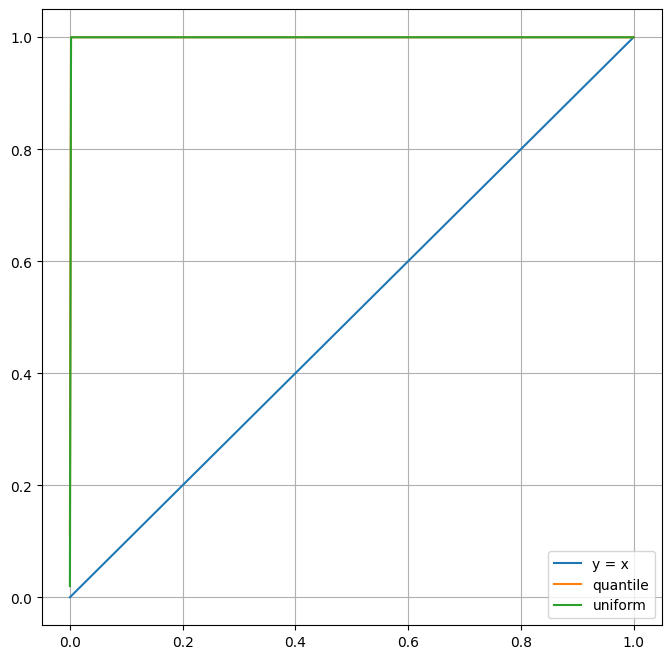

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 500)
plt.plot(x, x, label = 'y = x')

p_val_quantile = np.empty(N)
p_val_uniform = np.empty(N)
step = n // k
for i in tqdm(range(N)):
  #X = np.abs(sps.norm(loc=mu).rvs(size=n))
  X = sps.expon().rvs(size=n)
  X = np.sort(X)
  mle = 1 / X.mean()
  # делим на основе квантилей
  for mode in ['quantile', 'uniform']:
    if mode == 'quantile':
      separators = np.array([-np.inf] + [sps.expon(scale = 1 / mle).ppf((i + 1) / k) for i in range(k - 1)] + [np.inf])
    else:
      separators = np.array([-np.inf] + list(X[step-1:-step:step]) + [np.inf])
    obs = frequencies(X, separators)
    L = np.empty(len(mle_interval))
    for j, lambd in enumerate(mle_interval):
      L[j] = np.sum(obs * np.log(np.diff(sps.expon(scale = 1 / lambd).cdf(separators))))
    mle = mle_interval[np.argmax(L)]
    exp = np.diff(sps.expon(scale = 1 / mle).cdf(separators)) * n
    T = general_statistic_chi2(obs, exp)
    if mode == 'quantile':
      p_val_quantile[i] = 1 - sps.chi2(df = k - 2).cdf(T)
    else:
      p_val_uniform[i] = 1 - sps.chi2(df = k - 2).cdf(T)

plt.plot(x, EDF(x, p_val_quantile), label = 'quantile')
plt.plot(x, EDF(x, p_val_uniform), label = 'uniform')
plt.grid()
plt.legend()
plt.show()

In [ ]:
[1, 2, 3, 4][-2:4]

[3, 4]

In [ ]:
np.argmax([2, 3, -1, 5, -2, 3])

3

In [ ]:
np.argsort([[2, -1, 1], [3, 4, -2]], axis=1)

array([[1, 2, 0],
       [2, 0, 1]])

In [ ]:
np.hstack(([[1, 2], [3, 4]], [[5, 6], [7, 8]]))

array([[1, 2, 5, 6],
       [3, 4, 7, 8]])

In [ ]:
a = np.array([[3, 1, -2, 11], [38, -5, 20, 7]])
np.argsort(a, axis=1)

array([[2, 1, 0, 3],
       [1, 3, 2, 0]])

In [ ]:
np.argsort(np.argsort(a, axis=1), axis=1) + 1

array([[3, 2, 1, 4],
       [4, 1, 3, 2]])

In [ ]:
np.argsort(np.argsort(a, axis=1), axis=1)[:, :2] + 1

array([[3, 2],
       [4, 1]])

# Тема 1

In [ ]:
A = np.array([[1, 2, 3], [3, -1, 2], [-2, 4, -1]])
A

array([[ 1,  2,  3],
       [ 3, -1,  2],
       [-2,  4, -1]])

In [ ]:
np.array([[1, 2, 3], [3, -1, 2], [-2, 4, -1]]).dot(np.array([1, 2, 3]))

array([14,  7,  3])

In [ ]:
-np.sort(-A, axis=1)

array([[ 9,  4,  1],
       [ 6,  3, -2]])

## Задача 1

$
H_0: X_i \sim \mathcal{N}(0, 1) \\
H_1: \neg H_0 \\
\text{Под } H_0
$

In [ ]:
n = 1000
N = 300

Оцениваем функцию распределения статистик при гипотезе с помощью ЭФР методом Монте-Карло

In [ ]:
# выборка по строке
X = sps.norm().rvs(size=(N, n))

# получаем N значений статиситик при гипотезе

# значения статистики Крамера-фон Мизеса
T_cvm = statistic_CvM(X, sps.norm().cdf, n)
# значения статистики Андерсона-Дарлинга
T_ad = statistic_AD(X, sps.norm().cdf, n)

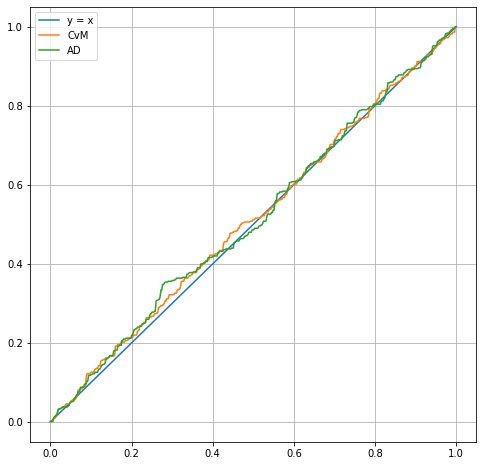

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 500)
plt.plot(x, x, label='y = x')

p_val_cvm = np.empty(500)
p_val_ad = np.empty(500)
for i in range(500):
  X = sps.norm().rvs(size=(1, n))
  p_val_cvm[i] = np.sum(T_cvm > statistic_CvM(X, sps.norm().cdf, n)) / (N + 1)
  p_val_ad[i] = np.sum(T_ad > statistic_AD(X, sps.norm().cdf, n)) / (N + 1)

plt.plot(x, EDF(x, p_val_cvm), label = 'CvM')
plt.plot(x, EDF(x, p_val_ad), label = 'AD')

plt.grid()
plt.legend()
plt.show()

## Задача 2

$
H_0: X_i \sim \mathcal{N}(0, 1)
$

In [ ]:
Y = sps.norm().rvs(size=(N, n))

In [ ]:
T_kolm = statistic_Kolm(Y, sps.norm().cdf, n)

a) $X_i \sim p \mathcal{N}(0, 1) + (1 - p) \mathcal{N}(0, 3)$

In [ ]:
p = 0.9
n = 1000
N = 300

In [ ]:
# генерируем N выборок из смеси
X = np.where(sps.bernoulli(p).rvs(size=(N, n)), sps.norm().rvs(size=(N, n)), sps.norm(scale=np.sqrt(3)).rvs(size=(N, n)))
T_chi2_x = statistic_chi2(X, sps.norm().cdf, sps.norm().ppf, n)

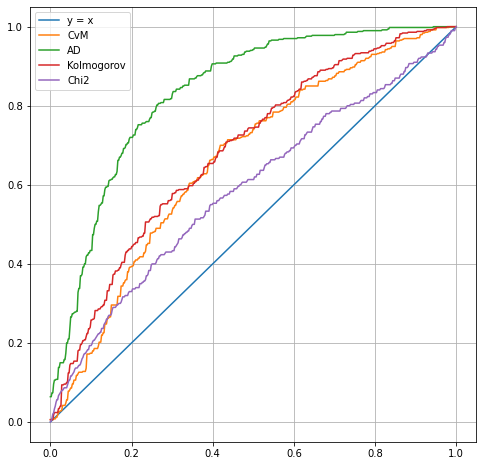

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 500)
plt.plot(x, x, label = 'y = x')

p_val_cvm = np.empty(500)
p_val_ad = np.empty(500)
p_val_kolm = np.empty(500)
for i in range(500):
  X = np.where(sps.bernoulli(p).rvs(size=(1, n)), sps.norm().rvs(size=(1, n)), sps.norm(scale=np.sqrt(3)).rvs(size=(1, n)))
  p_val_cvm[i] = np.sum(T_cvm > statistic_CvM(X, sps.norm().cdf, n)) / (N + 1)
  p_val_ad[i] = np.sum(T_ad > statistic_AD(X, sps.norm().cdf, n)) / (N + 1)
  p_val_kolm[i] = np.sum(T_kolm > statistic_Kolm(X, sps.norm().cdf, n)) / (N + 1)

plt.plot(x, EDF(x, p_val_cvm), label = 'CvM')
plt.plot(x, EDF(x, p_val_ad), label = 'AD')
plt.plot(x, EDF(x, p_val_kolm), label = 'Kolmogorov')
plt.plot(x, EDF(x, 1 - sps.chi2(df = int(n ** (1/5)) - 1).cdf(T_chi2_x)), label = 'Chi2')

plt.grid()
plt.legend()
plt.show()

б) $X_i \sim \frac{1}{2} \mathcal{N}(\mu, 1) + \frac{1}{2} \mathcal{N}(-\mu, 1)$

In [ ]:
mu = 0.4
n = 1000
N = 500

In [ ]:
# генерируем N выборок из смеси
X = np.where(sps.bernoulli(1/2).rvs(size=(N, n)), sps.norm(loc = mu).rvs(size=(N, n)), sps.norm(loc = -mu).rvs(size=(N, n)))
T_chi2_x = statistic_chi2(X, sps.norm().cdf, sps.norm().ppf, n)

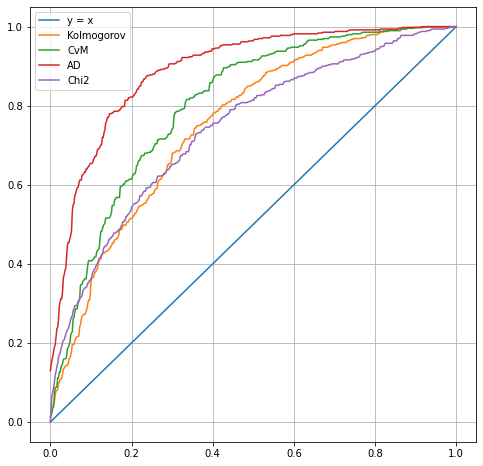

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 500)
plt.plot(x, x, label = 'y = x')

p_val_cvm = np.empty(500)
p_val_ad = np.empty(500)
p_val_kolm = np.empty(500)
for i in range(500):
  X = np.where(sps.bernoulli(1/2).rvs(size=(1, n)), sps.norm(loc = mu).rvs(size=(1, n)), sps.norm(loc = -mu).rvs(size=(1, n)))
  p_val_cvm[i] = np.sum(T_cvm > statistic_CvM(X, sps.norm().cdf, n)) / (N + 1)
  p_val_ad[i] = np.sum(T_ad > statistic_AD(X, sps.norm().cdf, n)) / (N + 1)
  p_val_kolm[i] = np.sum(T_kolm > statistic_Kolm(X, sps.norm().cdf, n)) / (N + 1)

plt.plot(x, EDF(x, p_val_kolm), label = 'Kolmogorov')
plt.plot(x, EDF(x, p_val_cvm), label = 'CvM')
plt.plot(x, EDF(x, p_val_ad), label = 'AD')
plt.plot(x, EDF(x, 1 - sps.chi2(df = int(n ** (1/5)) - 1).cdf(T_chi2_x)), label = 'Chi2')

plt.grid()
plt.legend()
plt.show()

## Задача 3

In [ ]:
n = 1000
N = 300

In [ ]:
C_cvm = 0.46
C_ad = 2.49
C_kolm = kolmogi(0.05)
C_chi2 = sps.chi2(df=2).ppf(0.95)
C_kolm, C_chi2

(1.3580986393225507, 5.991464547107979)

a)

<ipython-input-14-9e06069a3ce3>:12: RuntimeWarning: divide by zero encountered in log
  T = -(np.log(F(np.sort(X, axis=1))) + np.log(1 - F(-np.sort(-X, axis=1)))).dot(arr) - n


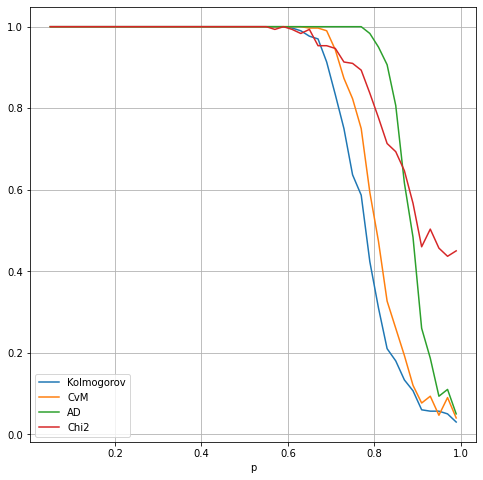

In [ ]:
plt.figure(figsize=(8, 8))

P = np.arange(0.05, 1, 0.02)
power_kolm = np.empty(len(P))
power_cvm = np.empty(len(P))
power_ad = np.empty(len(P))
power_chi2 = np.empty(len(P))

i = 0
for p in P:
  # генерируем N выборок из смеси
  X = np.where(sps.bernoulli(p).rvs(size=(N, n)), sps.norm().rvs(size=(N, n)), sps.norm(scale=np.sqrt(3)).rvs(size=(N, n)))
  power_kolm[i] = (np.sqrt(n) * statistic_Kolm(X, sps.norm().cdf, n) > C_kolm).sum() / N
  power_cvm[i] = (statistic_CvM(X, sps.norm().cdf, n) > C_cvm).sum() / N
  power_ad[i] = (statistic_AD(X, sps.norm().cdf, n) > C_ad).sum() / N
  power_chi2[i] = (statistic_chi2(X, sps.norm().cdf, sps.norm().ppf, n) > C_chi2).sum() / N
  i += 1
plt.plot(P, power_kolm, label='Kolmogorov')
plt.plot(P, power_cvm, label='CvM')
plt.plot(P, power_ad, label='AD')
plt.plot(P, power_chi2, label='Chi2')
plt.xlabel('p')
plt.grid()
plt.legend()
plt.show()

б)

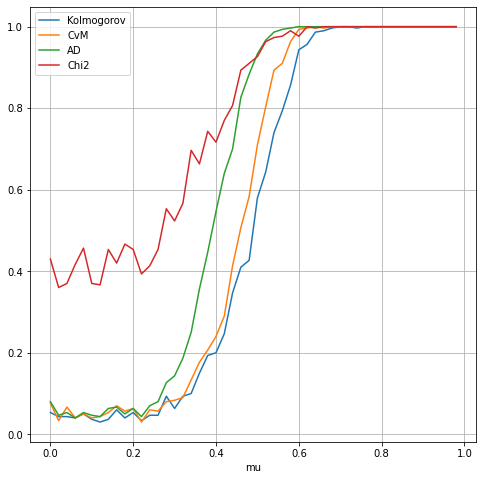

In [ ]:
plt.figure(figsize=(8, 8))

Mu = np.arange(0, 1, 0.02)
power_kolm = np.empty(len(Mu))
power_cvm = np.empty(len(Mu))
power_ad = np.empty(len(Mu))
power_chi2 = np.empty(len(Mu))

i = 0
for mu in Mu:
  # генерируем N выборок из смеси
  X = np.where(sps.bernoulli(1/2).rvs(size=(N, n)), sps.norm(loc = mu).rvs(size=(N, n)), sps.norm(loc = -mu).rvs(size=(N, n)))
  power_kolm[i] = (np.sqrt(n) * statistic_Kolm(X, sps.norm().cdf, n) > C_kolm).sum() / N
  power_cvm[i] = (statistic_CvM(X, sps.norm().cdf, n) > C_cvm).sum() / N
  power_ad[i] = (statistic_AD(X, sps.norm().cdf, n) > C_ad).sum() / N
  power_chi2[i] = (statistic_chi2(X, sps.norm().cdf, sps.norm().ppf, n) > C_chi2).sum() / N
  i += 1
plt.plot(Mu, power_kolm, label='Kolmogorov')
plt.plot(Mu, power_cvm, label='CvM')
plt.plot(Mu, power_ad, label='AD')
plt.plot(Mu, power_chi2, label='Chi2')
plt.xlabel('mu')
plt.grid()
plt.legend()
plt.show()

## Задача 4

a)

In [ ]:
n = 1000
N = 300

In [ ]:
X = sps.norm().rvs(size=(N, n))
T_kolm = statistic_Kolm(X, sps.norm().cdf, n)
T_cvm = statistic_CvM(X, sps.norm().cdf, n)
T_ad = statistic_AD(X, sps.norm().cdf, n)

In [ ]:
n = 10

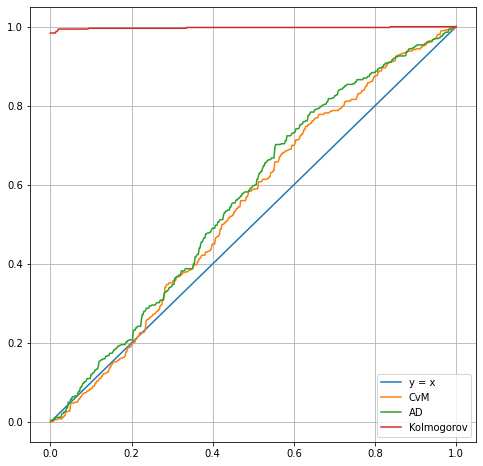

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 500)
plt.plot(x, x, label = 'y = x')

p_val_cvm = np.empty(500)
p_val_ad = np.empty(500)
p_val_kolm = np.empty(500)
for i in range(500):
  X = sps.laplace(scale = 1 / np.sqrt(2)).rvs(size=(1, n))
  p_val_cvm[i] = np.sum(T_cvm > statistic_CvM(X, sps.norm().cdf, n)) / (N + 1)
  p_val_ad[i] = np.sum(T_ad > statistic_AD(X, sps.norm().cdf, n)) / (N + 1)
  p_val_kolm[i] = np.sum(T_kolm > statistic_Kolm(X, sps.norm().cdf, n)) / (N + 1)

plt.plot(x, EDF(x, p_val_cvm), label = 'CvM')
plt.plot(x, EDF(x, p_val_ad), label = 'AD')
plt.plot(x, EDF(x, p_val_kolm), label = 'Kolmogorov')

plt.grid()
plt.legend()
plt.show()

б)

In [ ]:
n = 10
N = 100

In [ ]:
X = sps.norm().rvs(size=(N, n))
T_kolm = statistic_Kolm(X, sps.norm().cdf, n)
T_cvm = statistic_CvM(X, sps.norm().cdf, n)
T_ad = statistic_AD(X, sps.norm().cdf, n)

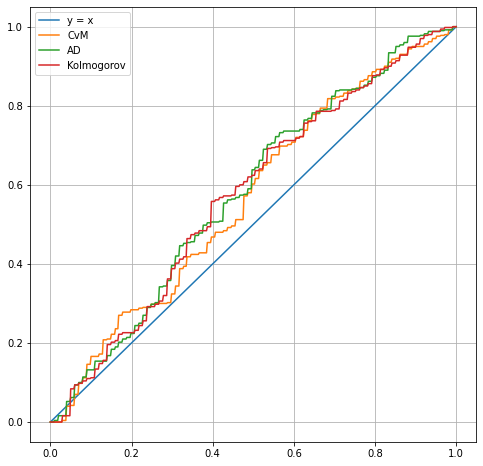

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 500)
plt.plot(x, x, label = 'y = x')

p_val_cvm = np.empty(500)
p_val_ad = np.empty(500)
p_val_kolm = np.empty(500)
for i in range(500):
  X = sps.laplace(scale = 1 / np.sqrt(2)).rvs(size=(1, n))
  p_val_cvm[i] = np.sum(T_cvm > statistic_CvM(X, sps.norm().cdf, n)) / (N + 1)
  p_val_ad[i] = np.sum(T_ad > statistic_AD(X, sps.norm().cdf, n)) / (N + 1)
  p_val_kolm[i] = np.sum(T_kolm > statistic_Kolm(X, sps.norm().cdf, n)) / (N + 1)

plt.plot(x, EDF(x, p_val_cvm), label = 'CvM')
plt.plot(x, EDF(x, p_val_ad), label = 'AD')
plt.plot(x, EDF(x, p_val_kolm), label = 'Kolmogorov')

plt.grid()
plt.legend()
plt.show()

In [ ]:
n = 2000
N1 = 1000
X = sps.norm().rvs(size=(N1, n))
T_asymp = statistic_AD(X, sps.norm().cdf, n)

n = 10
N2 = 300
X = sps.norm().rvs(size=(N2, n))
T_exact = statistic_AD(X, sps.norm().cdf, n)

In [ ]:
n = 10

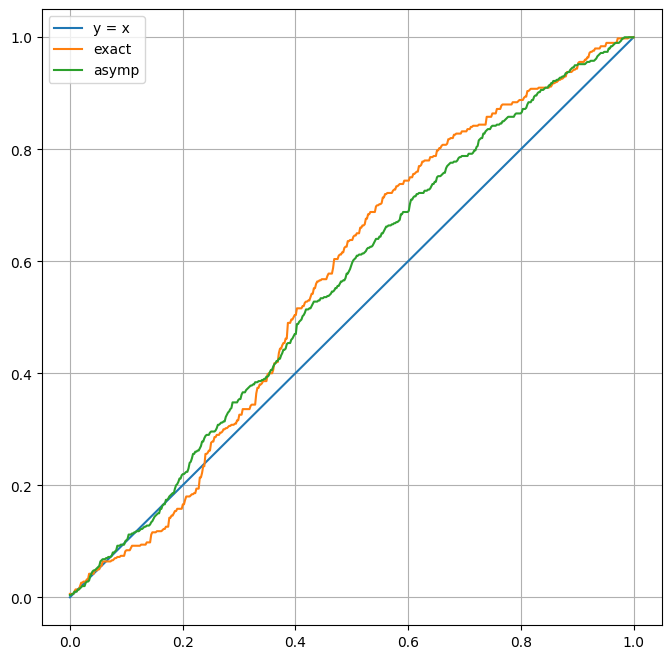

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 500)
plt.plot(x, x, label = 'y = x')

p_val_exact = np.empty(500)
p_val_asymp = np.empty(500)
for i in range(500):
  X = sps.laplace(scale = 1 / np.sqrt(2)).rvs(size=(1, n))
  p_val_exact[i] = np.sum(T_exact > statistic_AD(X, sps.norm().cdf, n)) / (N2 + 1)
  p_val_asymp[i] = np.sum(T_asymp > statistic_AD(X, sps.norm().cdf, n)) / (N1 + 1)

plt.plot(x, EDF(x, p_val_exact), label = 'exact')
plt.plot(x, EDF(x, p_val_asymp), label = 'asymp')

plt.grid()
plt.legend()
plt.show()

# Тема 2

## Задача 1

In [ ]:
n = 100
N = 100

a)

In [ ]:
T_kolm[:10], T_cvm[:10]

(array([0.04032787, 0.05270915, 0.04269593, 0.02942103, 0.03621857,
        0.03500803, 0.03753403, 0.04253716, 0.03716325, 0.02825928]),
 array([0.09984587, 0.14277083, 0.1109716 , 0.02545686, 0.05521397,
        0.05611148, 0.03896978, 0.07355285, 0.10580325, 0.02484967]))

In [ ]:
# эталонные статистики
Y = sps.norm().rvs(size=(N, n))
T_kolm = statistic_Kolm(Y.T, sps.norm(loc = Y.mean(axis=1), scale = Y.std(axis=1)).cdf, n, transpos=True)
T_cvm = statistic_CvM(Y.T, sps.norm(loc = Y.mean(axis=1), scale = Y.std(axis=1)).cdf, n, transpos=True)
T_ad = statistic_AD(Y.T, sps.norm(loc = Y.mean(axis=1), scale = Y.std(axis=1)).cdf, n, transpos=True)

При гипотезе

In [ ]:
mu = 2
sigma = 3

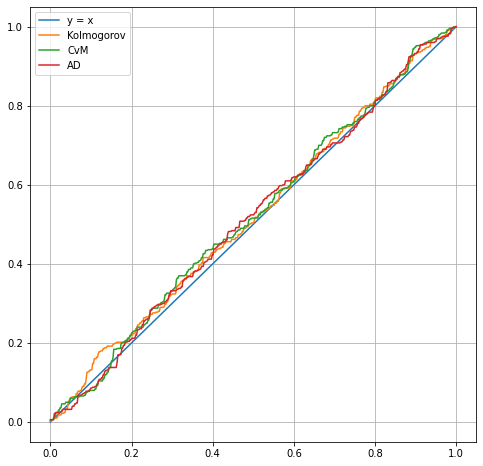

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 500)
plt.plot(x, x, label = 'y = x')

p_val_cvm = np.empty(500)
p_val_ad = np.empty(500)
p_val_kolm = np.empty(500)

X = sps.norm(loc = mu, scale = sigma).rvs(size=(500, n))
p_val_ad = np.sum(np.repeat(np.reshape(T_ad, (N, 1)), 500, axis=1) >
                  statistic_AD(X.T, sps.norm(loc = X.mean(axis=1), scale = X.std(axis=1)).cdf, n, transpos=True),
                  axis=0) / (N + 1)
p_val_cvm = np.sum(np.repeat(np.reshape(T_cvm, (N, 1)), 500, axis=1) >
                  statistic_CvM(X.T, sps.norm(loc = X.mean(axis=1), scale = X.std(axis=1)).cdf, n, transpos=True),
                  axis=0) / (N + 1)
p_val_kolm = np.sum(np.repeat(np.reshape(T_kolm, (N, 1)), 500, axis=1) >
                  statistic_Kolm(X.T, sps.norm(loc = X.mean(axis=1), scale = X.std(axis=1)).cdf, n, transpos=True),
                  axis=0) / (N + 1)

plt.plot(x, EDF(x, p_val_kolm), label = 'Kolmogorov')
plt.plot(x, EDF(x, p_val_cvm), label = 'CvM')
plt.plot(x, EDF(x, p_val_ad), label = 'AD')

plt.grid()
plt.legend()
plt.show()

При альтернативе

<ipython-input-3-4e48e45d21f5>:16: RuntimeWarning: divide by zero encountered in log
  np.log(1 - F(-np.sort(-X, axis = 0 if transpos else 1))))


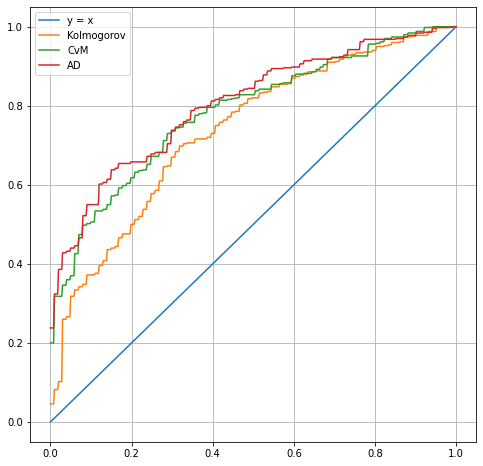

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 500)
plt.plot(x, x, label = 'y = x')

p_val_cvm = np.empty(500)
p_val_ad = np.empty(500)
p_val_kolm = np.empty(500)

X = sps.t(df=5).rvs(size=(500, n))
p_val_ad = np.sum(np.repeat(np.reshape(T_ad, (N, 1)), 500, axis=1) >
                  statistic_AD(X.T, sps.norm(loc = X.mean(axis=1), scale = X.std(axis=1)).cdf, n, transpos=True),
                  axis=0) / (N + 1)
p_val_cvm = np.sum(np.repeat(np.reshape(T_cvm, (N, 1)), 500, axis=1) >
                  statistic_CvM(X.T, sps.norm(loc = X.mean(axis=1), scale = X.std(axis=1)).cdf, n, transpos=True),
                  axis=0) / (N + 1)
p_val_kolm = np.sum(np.repeat(np.reshape(T_kolm, (N, 1)), 500, axis=1) >
                  statistic_Kolm(X.T, sps.norm(loc = X.mean(axis=1), scale = X.std(axis=1)).cdf, n, transpos=True),
                  axis=0) / (N + 1)
plt.plot(x, EDF(x, p_val_kolm), label = 'Kolmogorov')
plt.plot(x, EDF(x, p_val_cvm), label = 'CvM')
plt.plot(x, EDF(x, p_val_ad), label = 'AD')

plt.grid()
plt.legend()
plt.show()

б)

In [ ]:
# эталонные статистики
Y = sps.expon().rvs(size=(N, n))
T_kolm = statistic_Kolm(Y.T, sps.expon(scale = Y.mean(axis=1)).cdf, n, transpos=True)
T_cvm = statistic_CvM(Y.T, sps.expon(scale = Y.mean(axis=1)).cdf, n, transpos=True)
T_ad = statistic_AD(Y.T, sps.expon(scale = Y.mean(axis=1)).cdf, n, transpos=True)

При гипотезе

In [ ]:
lamb = 3

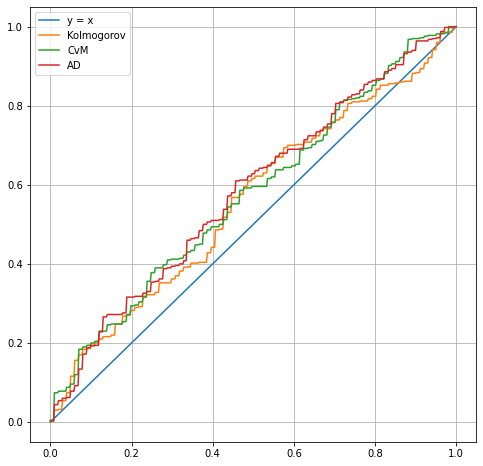

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 500)
plt.plot(x, x, label = 'y = x')

p_val_cvm = np.empty(500)
p_val_ad = np.empty(500)
p_val_kolm = np.empty(500)

X = sps.expon(scale = 1 / lamb).rvs(size=(500, n))
p_val_ad = np.sum(np.repeat(np.reshape(T_ad, (N, 1)), 500, axis=1) >
                  statistic_AD(X.T, sps.expon(scale = X.mean(axis=1)).cdf, n, transpos=True),
                  axis=0) / (N + 1)
p_val_cvm = np.sum(np.repeat(np.reshape(T_cvm, (N, 1)), 500, axis=1) >
                  statistic_CvM(X.T, sps.expon(scale = X.mean(axis=1)).cdf, n, transpos=True),
                  axis=0) / (N + 1)
p_val_kolm = np.sum(np.repeat(np.reshape(T_kolm, (N, 1)), 500, axis=1) >
                  statistic_Kolm(X.T, sps.expon(scale = X.mean(axis=1)).cdf, n, transpos=True),
                  axis=0) / (N + 1)
plt.plot(x, EDF(x, p_val_kolm), label = 'Kolmogorov')
plt.plot(x, EDF(x, p_val_cvm), label = 'CvM')
plt.plot(x, EDF(x, p_val_ad), label = 'AD')

plt.grid()
plt.legend()
plt.show()

При альтернативе

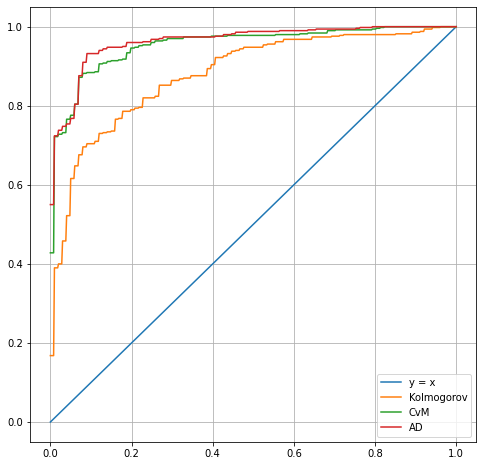

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 500)
plt.plot(x, x, label = 'y = x')

p_val_cvm = np.empty(500)
p_val_ad = np.empty(500)
p_val_kolm = np.empty(500)

X = sps.chi2(df = 3).rvs(size=(500, n))
p_val_ad = np.sum(np.repeat(np.reshape(T_ad, (N, 1)), 500, axis=1) >
                  statistic_AD(X.T, sps.expon(scale = X.mean(axis=1)).cdf, n, transpos=True),
                  axis=0) / (N + 1)
p_val_cvm = np.sum(np.repeat(np.reshape(T_cvm, (N, 1)), 500, axis=1) >
                  statistic_CvM(X.T, sps.expon(scale = X.mean(axis=1)).cdf, n, transpos=True),
                  axis=0) / (N + 1)
p_val_kolm = np.sum(np.repeat(np.reshape(T_kolm, (N, 1)), 500, axis=1) >
                  statistic_Kolm(X.T, sps.expon(scale = X.mean(axis=1)).cdf, n, transpos=True),
                  axis=0) / (N + 1)
plt.plot(x, EDF(x, p_val_kolm), label = 'Kolmogorov')
plt.plot(x, EDF(x, p_val_cvm), label = 'CvM')
plt.plot(x, EDF(x, p_val_ad), label = 'AD')

plt.grid()
plt.legend()
plt.show()

## Задача 3

(a)

In [ ]:
n = 75
N = 75

In [ ]:
# эталонные статистики
Y = sps.norm().rvs(size=(N, n))
T_ad = statistic_AD(Y.T, sps.norm(loc = Y.mean(axis=1), scale = Y.std(axis=1)).cdf, n, transpos=True)

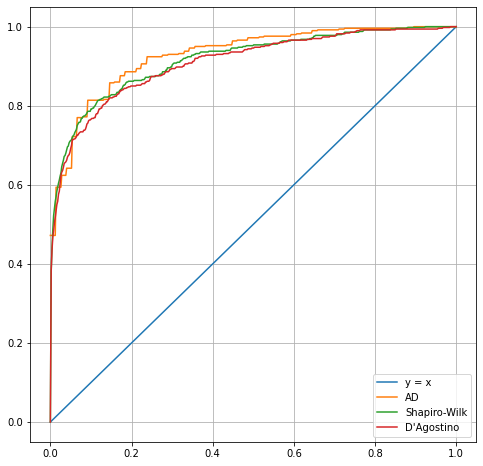

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 500)
plt.plot(x, x, label = 'y = x')

p_val_ad = np.empty(500)
p_val_shapiro = np.empty(500)
p_val_agostino = np.empty(500)

X = sps.laplace(scale = 1 / np.sqrt(2)).rvs(size=(500, n))
p_val_ad = np.sum(np.repeat(np.reshape(T_ad, (N, 1)), 500, axis=1) >
                  statistic_AD(X.T, sps.norm(loc = X.mean(axis=1), scale = X.std(axis=1)).cdf, n, transpos=True),
                  axis=0) / (N + 1)
p_val_shapiro = [sps.shapiro(X[i]).pvalue for i in range(500)]
p_val_agostino = sps.normaltest(X, axis=1).pvalue

plt.plot(x, EDF(x, p_val_ad), label = 'AD')
plt.plot(x, EDF(x, p_val_shapiro), label = 'Shapiro-Wilk')
plt.plot(x, EDF(x, p_val_agostino), label = 'D\'Agostino')

plt.grid()
plt.legend()
plt.show()

(b)

In [ ]:
n = 75
N = 50

In [ ]:
# эталонные статистики
Y = sps.norm().rvs(size=(N, n))
T_ad = statistic_AD(Y.T, sps.norm(loc = Y.mean(axis=1), scale = Y.std(axis=1)).cdf, n, transpos=True)

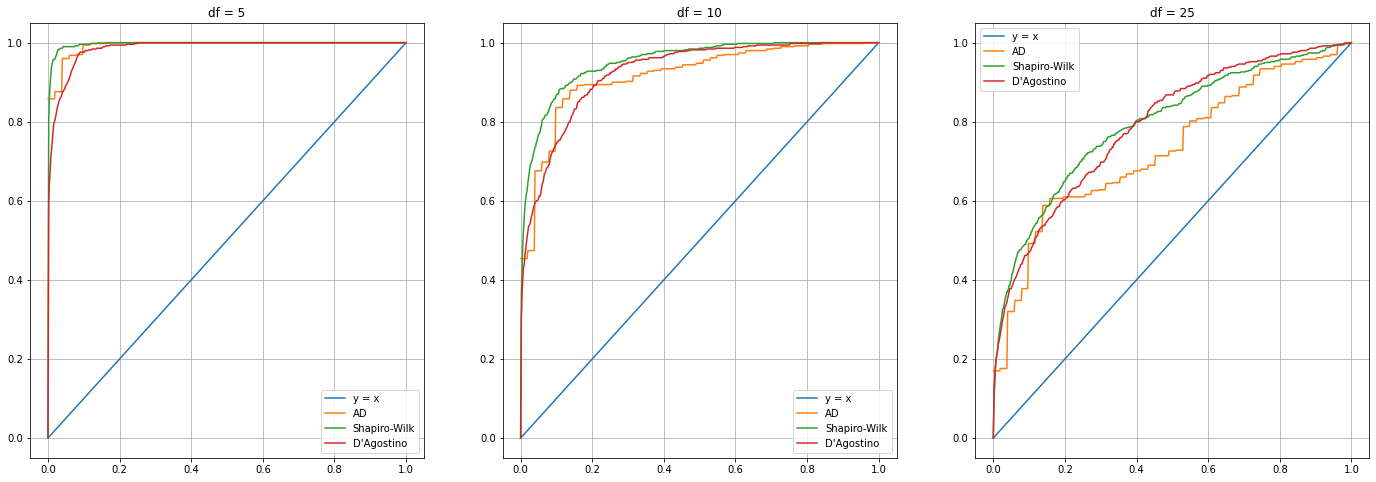

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
x = np.linspace(0, 1, 500)

p_val_ad = np.empty(500)
p_val_shapiro = np.empty(500)
p_val_agostino = np.empty(500)
i = 0
for df in [5, 10, 25]:
  X = sps.chi2(df = df).rvs(size=(500, n))
  p_val_ad = np.sum(np.repeat(np.reshape(T_ad, (N, 1)), 500, axis=1) >
                  statistic_AD(X.T, sps.norm(loc = X.mean(axis=1), scale = X.std(axis=1)).cdf, n, transpos=True),
                  axis=0) / (N + 1)
  p_val_shapiro = [sps.shapiro(X[i]).pvalue for i in range(500)]
  p_val_agostino = sps.normaltest(X, axis=1).pvalue
  axes[i].plot(x, x, label = 'y = x')
  axes[i].plot(x, EDF(x, p_val_ad), label = 'AD')
  axes[i].plot(x, EDF(x, p_val_shapiro), label = 'Shapiro-Wilk')
  axes[i].plot(x, EDF(x, p_val_agostino), label = 'D\'Agostino')
  axes[i].set_title(f'df = {df}')
  axes[i].grid()
  axes[i].legend()
  i += 1

plt.show()

(в)

In [ ]:
n = 30
N = 30

In [ ]:
# эталонные статистики
Y = sps.norm().rvs(size=(N, n))
T_ad = statistic_AD(Y.T, sps.norm(loc = Y.mean(axis=1), scale = Y.std(axis=1)).cdf, n, transpos=True)

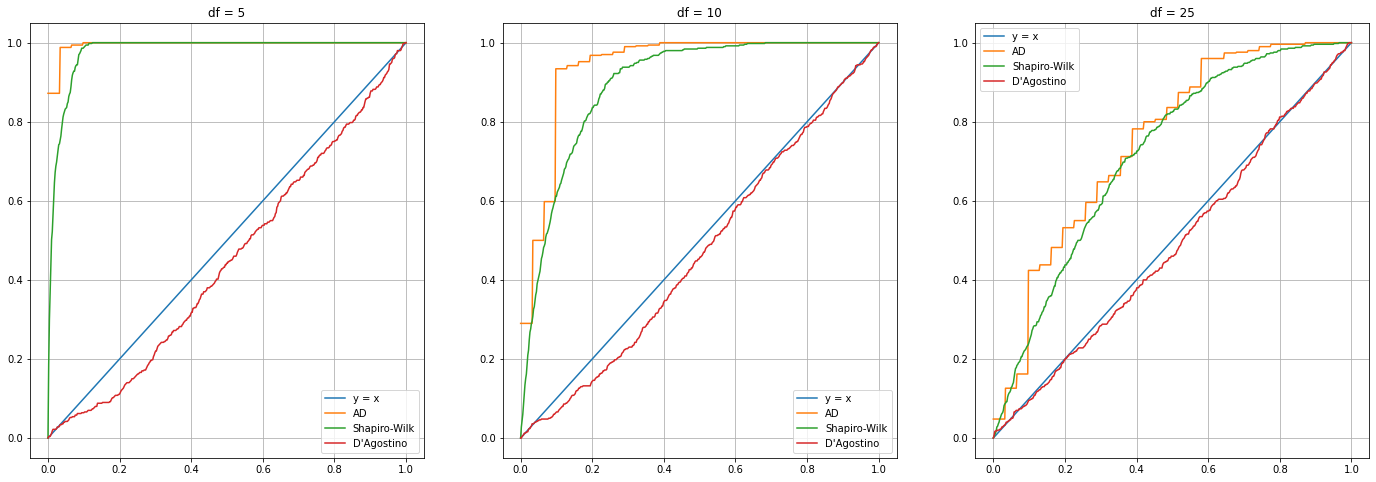

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
x = np.linspace(0, 1, 500)

p_val_ad = np.empty(500)
p_val_shapiro = np.empty(500)
p_val_agostino = np.empty(500)
i = 0
for df in [5, 10, 25]:
  X = sps.binom(df, 1/2).rvs(size=(500, n))
  p_val_ad = np.sum(np.repeat(np.reshape(T_ad, (N, 1)), 500, axis=1) >
                  statistic_AD(X.T, sps.norm(loc = X.mean(axis=1), scale = X.std(axis=1)).cdf, n, transpos=True),
                  axis=0) / (N + 1)
  p_val_shapiro = [sps.shapiro(X[i]).pvalue for i in range(500)]
  p_val_agostino = sps.normaltest(X, axis=1).pvalue
  axes[i].plot(x, x, label = 'y = x')
  axes[i].plot(x, EDF(x, p_val_ad), label = 'AD')
  axes[i].plot(x, EDF(x, p_val_shapiro), label = 'Shapiro-Wilk')
  axes[i].plot(x, EDF(x, p_val_agostino), label = 'D\'Agostino')
  axes[i].set_title(f'df = {df}')
  axes[i].grid()
  axes[i].legend()
  i += 1

plt.show()

## Задача 4

In [ ]:
n = 100
N = 50

In [ ]:
# эталонные статистики
Y = sps.expon().rvs(size=(N, n))
T_ad = statistic_AD(Y.T, sps.expon(scale = Y.mean(axis=1)).cdf, n, transpos=True)
T_sw = statistic_SW_exp(Y, n)
T_a_test = statistic_a_test(Y, n)
T_froz = statistic_Frozini(Y, n)

(а)

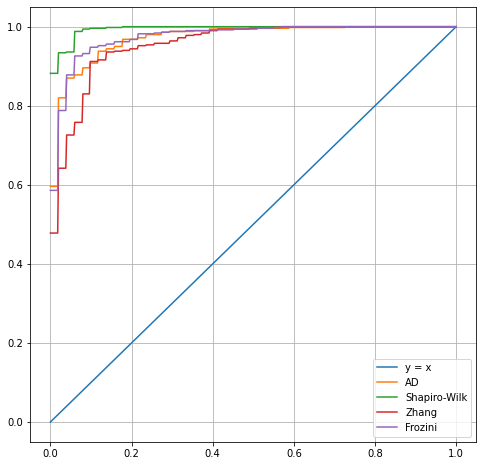

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 500)
plt.plot(x, x, label = 'y = x')

p_val_ad = np.empty(500)
p_val_sw = np.empty(500)
p_val_a_test = np.empty(500)
p_val_froz = np.empty(500)

X = np.abs(sps.norm().rvs(size=(500, n)))
p_val_ad = np.sum(np.repeat(np.reshape(T_ad, (N, 1)), 500, axis=1) >
                  statistic_AD(X.T, sps.expon(scale = X.mean(axis=1)).cdf, n, transpos=True),
                  axis=0) / (N + 1)
p_val_sw = np.sum(np.repeat(np.reshape(T_sw, (N, 1)), 500, axis=1) > statistic_SW_exp(X, n), axis=0) / (N + 1)
p_val_a_test = np.sum(np.repeat(np.reshape(T_a_test, (N, 1)), 500, axis=1) > statistic_a_test(X, n), axis=0) / (N + 1)
p_val_froz = np.sum(np.repeat(np.reshape(T_froz, (N, 1)), 500, axis=1) > statistic_Frozini(X, n), axis=0) / (N + 1)

plt.plot(x, EDF(x, p_val_ad), label = 'AD')
plt.plot(x, EDF(x, p_val_sw), label = 'Shapiro-Wilk')
plt.plot(x, EDF(x, p_val_a_test), label = 'Zhang')
plt.plot(x, EDF(x, p_val_froz), label = 'Frozini')

plt.grid()
plt.legend()
plt.show()

(b)

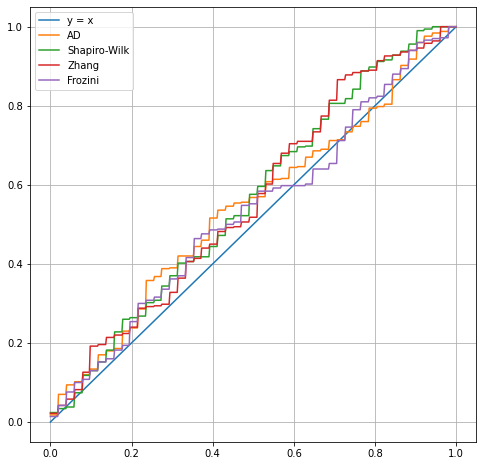

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 500)
plt.plot(x, x, label = 'y = x')

p_val_ad = np.empty(500)
p_val_sw = np.empty(500)
p_val_a_test = np.empty(500)
p_val_froz = np.empty(500)

X = sps.chi2(df=2).rvs(size=(500, n))
p_val_ad = np.sum(np.repeat(np.reshape(T_ad, (N, 1)), 500, axis=1) >
                  statistic_AD(X.T, sps.expon(scale = X.mean(axis=1)).cdf, n, transpos=True),
                  axis=0) / (N + 1)
p_val_sw = np.sum(np.repeat(np.reshape(T_sw, (N, 1)), 500, axis=1) > statistic_SW_exp(X, n), axis=0) / (N + 1)
p_val_a_test = np.sum(np.repeat(np.reshape(T_a_test, (N, 1)), 500, axis=1) > statistic_a_test(X, n), axis=0) / (N + 1)
p_val_froz = np.sum(np.repeat(np.reshape(T_froz, (N, 1)), 500, axis=1) > statistic_Frozini(X, n), axis=0) / (N + 1)

plt.plot(x, EDF(x, p_val_ad), label = 'AD')
plt.plot(x, EDF(x, p_val_sw), label = 'Shapiro-Wilk')
plt.plot(x, EDF(x, p_val_a_test), label = 'Zhang')
plt.plot(x, EDF(x, p_val_froz), label = 'Frozini')

plt.grid()
plt.legend()
plt.show()

(в)

In [ ]:
n = 15
N = 15

In [ ]:
# эталонные статистики
Y = sps.expon().rvs(size=(N, n))
T_ad = statistic_AD(Y.T, sps.expon(scale = Y.mean(axis=1)).cdf, n, transpos=True)
T_sw = statistic_SW_exp(Y, n)
T_a_test = statistic_a_test(Y, n)
T_froz = statistic_Frozini(Y, n)

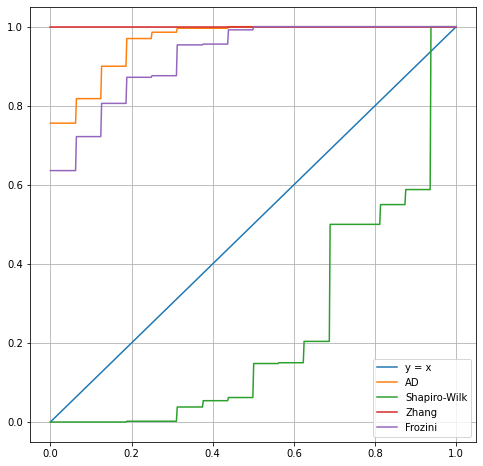

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 500)
plt.plot(x, x, label = 'y = x')

p_val_ad = np.empty(500)
p_val_sw = np.empty(500)
p_val_a_test = np.empty(500)
p_val_froz = np.empty(500)

X = sps.geom(1/2).rvs(size=(500, n))
p_val_ad = np.sum(np.repeat(np.reshape(T_ad, (N, 1)), 500, axis=1) >
                  statistic_AD(X.T, sps.expon(scale = X.mean(axis=1)).cdf, n, transpos=True),
                  axis=0) / (N + 1)
p_val_sw = np.sum(np.repeat(np.reshape(T_sw, (N, 1)), 500, axis=1) > statistic_SW_exp(X, n), axis=0) / (N + 1)
p_val_a_test = np.sum(np.repeat(np.reshape(T_a_test, (N, 1)), 500, axis=1) > statistic_a_test(X, n), axis=0) / (N + 1)
p_val_froz = np.sum(np.repeat(np.reshape(T_froz, (N, 1)), 500, axis=1) > statistic_Frozini(X, n), axis=0) / (N + 1)

plt.plot(x, EDF(x, p_val_ad), label = 'AD')
plt.plot(x, EDF(x, p_val_sw), label = 'Shapiro-Wilk')
plt.plot(x, EDF(x, p_val_a_test), label = 'Zhang')
plt.plot(x, EDF(x, p_val_froz), label = 'Frozini')

plt.grid()
plt.legend()
plt.show()

# Тема 3

## Задача 1

In [ ]:
np.reshape([[5, 6], [1, 2]], (1, 2, 2))

array([[[5, 6],
        [1, 2]]])

In [ ]:
np.hstack(([[[5, 6], [1, 2]]] * 2))

array([[5, 6, 5, 6],
       [1, 2, 1, 2]])

In [ ]:
np.repeat([[1, 2], [3, 4]], 3, axis=1)

array([[1, 1, 1, 2, 2, 2],
       [3, 3, 3, 4, 4, 4]])

In [ ]:
np.random.permutation([[1, 2], [3, 4], [5, 6]])

array([[5, 6],
       [1, 2],
       [3, 4]])

а)
$ \\
X_i \sim \mathcal{N}(0, 1) \\
Y_j \sim \mathcal{N}(0.5, 1)
$

In [ ]:
n = 50
N = 1000

In [ ]:
X = sps.norm().rvs(size=(N, n))
Y = sps.norm(loc = 0.25).rvs(size=(N, n))

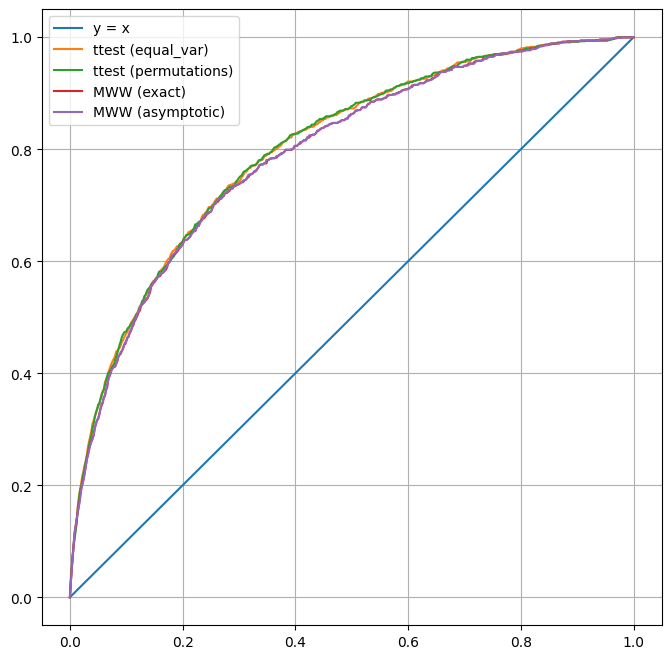

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 500)
plt.plot(x, x, label = 'y = x')

pvalue_ttest_equal = sps.ttest_ind(X, Y, axis=1, alternative='less').pvalue
pvalue_ttest_perm = sps.ttest_ind(X, Y, axis=1, permutations=N, alternative='less').pvalue
pvalue_mww_exact = sps.mannwhitneyu(X, Y, axis=1, alternative='less', method='exact').pvalue
pvalue_mww_asymp = sps.mannwhitneyu(X, Y, axis=1, alternative='less', method='asymptotic').pvalue

plt.plot(x, EDF(x, pvalue_ttest_equal), label = 'ttest (equal_var)')
plt.plot(x, EDF(x, pvalue_ttest_perm), label = 'ttest (permutations)')
plt.plot(x, EDF(x, pvalue_mww_exact), label = 'MWW (exact)')
plt.plot(x, EDF(x, pvalue_mww_asymp), label = 'MWW (asymptotic)')

plt.grid()
plt.legend()
plt.show()

In [ ]:
n = 50
N = 100
mu_list = np.arange(0.1, 1, 0.05)
alpha = 0.05

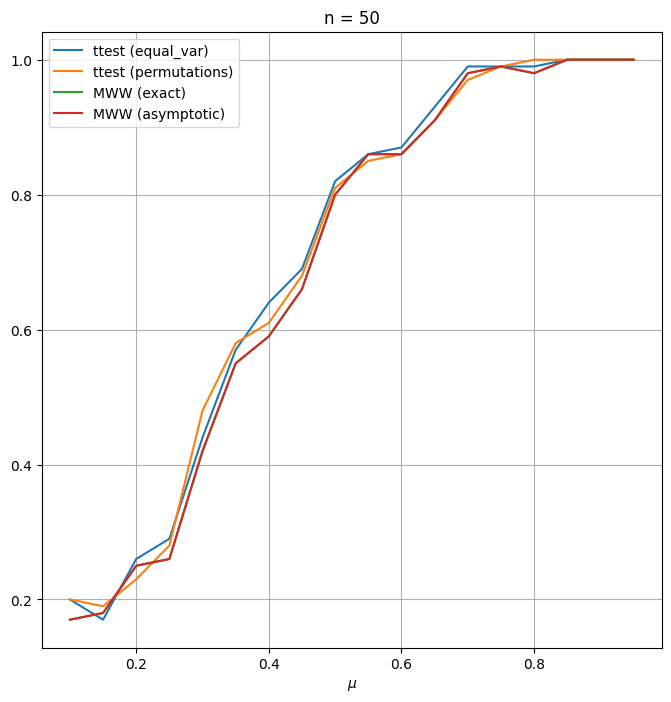

In [ ]:
plt.figure(figsize=(8, 8))
power_ttest_equal = []
power_ttest_perm = []
power_mww_exact = []
power_mww_asymp = []
for mu in mu_list:
  X = sps.norm().rvs(size=(N, n))
  Y = sps.norm(loc = mu).rvs(size=(N, n))
  pvalue_ttest_equal = sps.ttest_ind(X, Y, axis=1, alternative='less').pvalue
  pvalue_ttest_perm = sps.ttest_ind(X, Y, axis=1, permutations=N, alternative='less').pvalue
  pvalue_mww_exact = sps.mannwhitneyu(X, Y, axis=1, alternative='less', method='exact').pvalue
  pvalue_mww_asymp = sps.mannwhitneyu(X, Y, axis=1, alternative='less', method='asymptotic').pvalue

  power_ttest_equal.append(np.mean(pvalue_ttest_equal < alpha))
  power_ttest_perm.append(np.mean(pvalue_ttest_perm < alpha))
  power_mww_exact.append(np.mean(pvalue_mww_exact < alpha))
  power_mww_asymp.append(np.mean(pvalue_mww_asymp < alpha))

plt.plot(mu_list, power_ttest_equal, label = 'ttest (equal_var)')
plt.plot(mu_list, power_ttest_perm, label = 'ttest (permutations)')
plt.plot(mu_list, power_mww_exact, label = 'MWW (exact)')
plt.plot(mu_list, power_mww_asymp, label = 'MWW (asymptotic)')

plt.xlabel(f'$\mu$')
plt.title(f'n = {n}')
plt.grid()
plt.legend()
plt.show()

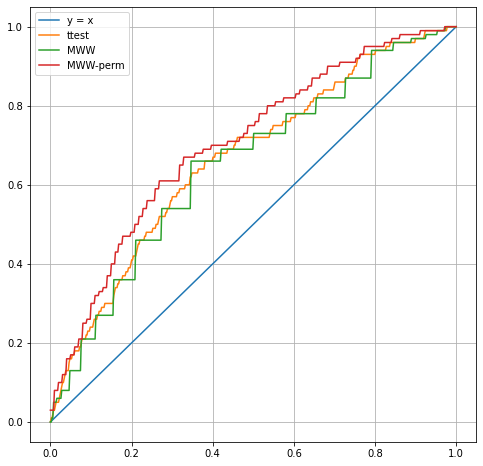

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 500)
plt.plot(x, x, label = 'y = x')

pvalue_ttest = sps.ttest_rel(X, Y, axis=1, alternative='less').pvalue
pvalue_mww = sps.mannwhitneyu(X, Y, axis=1, alternative='less').pvalue
pvalue_mww_perm = np.empty(N)
T = statistic_MWW(X, Y)
T_perm = np.empty((N, N))
for i in range(N):
  perm = np.random.permutation(np.hstack((X, Y)).T).T
  X_new, Y_new = perm[:, :n], perm[:, n:]
  T_perm[i] = statistic_MWW(X_new, Y_new)
pvalue_mww_perm = np.sum(T_perm > T, axis=0) / (N + 1)

plt.plot(x, EDF(x, pvalue_ttest), label = 'ttest')
plt.plot(x, EDF(x, pvalue_mww), label = 'MWW')
plt.plot(x, EDF(x, pvalue_mww_perm), label = 'MWW-perm')

plt.grid()
plt.legend()
plt.show()

б)
$ \\
X_i \sim exp(1) \\
Y_j \sim exp(1.5)
$

In [ ]:
Y = sps.expon().rvs(size=(N, n))
X = sps.expon(scale = 2/3).rvs(size=(N, n))

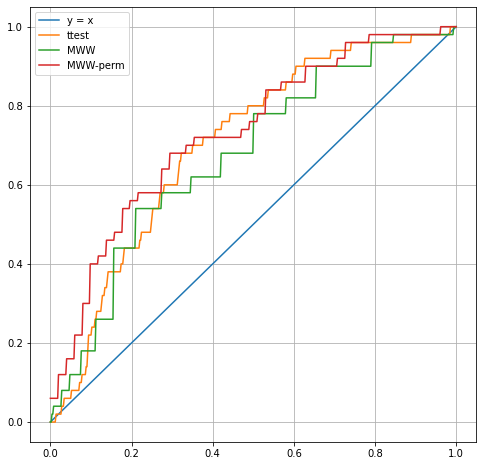

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 500)
plt.plot(x, x, label = 'y = x')

pvalue_ttest = sps.ttest_rel(X, Y, axis=1, alternative='less').pvalue
pvalue_mww = sps.mannwhitneyu(X, Y, axis=1, alternative='less').pvalue
pvalue_mww_perm = np.empty(N)
T = statistic_MWW(X, Y)
T_perm = np.empty((N, N))
for i in range(N):
  perm = np.random.permutation(np.hstack((X, Y)).T).T
  X_new, Y_new = perm[:, :n], perm[:, n:]
  T_perm[i] = statistic_MWW(X_new, Y_new)
pvalue_mww_perm = np.sum(T_perm > T, axis=0) / (N + 1)

plt.plot(x, EDF(x, pvalue_ttest), label = 'ttest')
plt.plot(x, EDF(x, pvalue_mww), label = 'MWW')
plt.plot(x, EDF(x, pvalue_mww_perm), label = 'MWW-perm')

plt.grid()
plt.legend()
plt.show()

## Задача 2

a)$\\
X_i \sim R[0, 1] \\
Y_j \sim R[0, 1]
$

In [ ]:
n = 500
N = 100

In [ ]:
X = sps.uniform().rvs(size=(N, n))
Y = sps.uniform().rvs(size=(N, n))

<ipython-input-45-d13f43742f3a>:5: UserWarning: p-value capped: true value larger than 0.25
  pvalue_ss = [sps.anderson_ksamp((X[i], Y[i])).pvalue for i in range(N)]


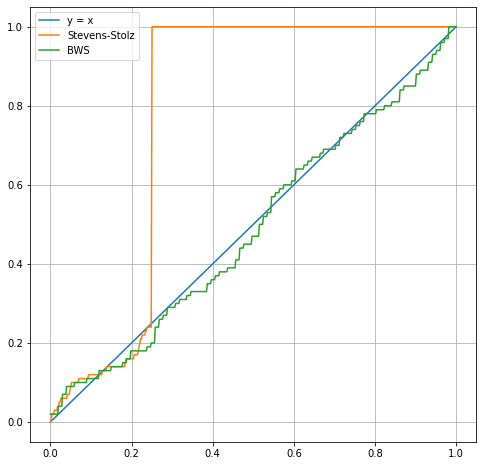

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 500)
plt.plot(x, x, label = 'y = x')

pvalue_ss = [sps.anderson_ksamp((X[i], Y[i])).pvalue for i in range(N)]
pvalue_bws = np.empty(N)
T = statistic_BWS(X, Y)
T_perm = np.empty((N, N))
for i in range(N):
  perm = np.random.permutation(np.hstack((X, Y)).T).T
  X_new, Y_new = perm[:, :n], perm[:, n:]
  T_perm[i] = statistic_BWS(X_new, Y_new)
pvalue_bws = np.sum(T_perm > T, axis=0) / (N + 1)

plt.plot(x, EDF(x, pvalue_ss), label = 'Stevens-Stolz')
plt.plot(x, EDF(x, pvalue_bws), label = 'BWS')

plt.grid()
plt.legend()
plt.show()

б)
$ \\
X_i \sim R[0, 1] \\
Y_j \sim R[0.1, 1.1]
$

In [ ]:
X = sps.uniform().rvs(size=(N, n))
Y = sps.uniform(loc=0.1).rvs(size=(N, n))

<ipython-input-47-d13f43742f3a>:5: UserWarning: p-value floored: true value smaller than 0.001
  pvalue_ss = [sps.anderson_ksamp((X[i], Y[i])).pvalue for i in range(N)]


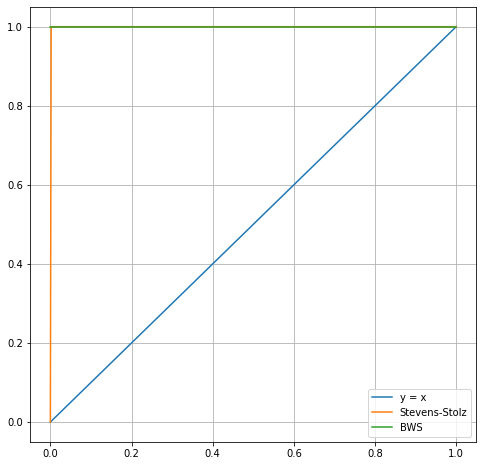

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 500)
plt.plot(x, x, label = 'y = x')

pvalue_ss = [sps.anderson_ksamp((X[i], Y[i])).pvalue for i in range(N)]
pvalue_bws = np.empty(N)
T = statistic_BWS(X, Y)
T_perm = np.empty((N, N))
for i in range(N):
  perm = np.random.permutation(np.hstack((X, Y)).T).T
  X_new, Y_new = perm[:, :n], perm[:, n:]
  T_perm[i] = statistic_BWS(X_new, Y_new)
pvalue_bws = np.sum(T_perm > T, axis=0) / (N + 1)

plt.plot(x, EDF(x, pvalue_ss), label = 'Stevens-Stolz')
plt.plot(x, EDF(x, pvalue_bws), label = 'BWS')

plt.grid()
plt.legend()
plt.show()

## Задача 3

(а)
$ \\
X_i \sim \mathcal{N}(0, 1) \\
Y_j \sim \mathcal{N}(0, 1)
$

In [ ]:
n = 250
N = 100

In [ ]:
X = sps.norm().rvs(size=(N, n))
Y = sps.norm().rvs(size=(N, n))

<ipython-input-18-9cd567f9f1f9>:7: UserWarning: p-value capped: true value larger than 0.25
  pvalue_ss = [sps.anderson_ksamp((X[i], Y[i])).pvalue for i in range(N)]


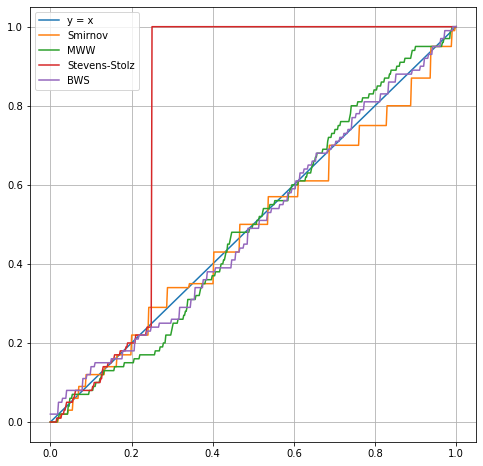

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 500)
plt.plot(x, x, label = 'y = x')

pvalue_ks = [sps.ks_2samp(X[i], Y[i]).pvalue for i in range(N)]
pvalue_mww = sps.mannwhitneyu(X, Y, axis=1).pvalue
pvalue_ss = [sps.anderson_ksamp((X[i], Y[i])).pvalue for i in range(N)]
pvalue_bws = np.empty(N)
T = statistic_BWS(X, Y)
T_perm = np.empty((N, N))
for i in range(N):
  perm = np.random.permutation(np.hstack((X, Y)).T).T
  X_new, Y_new = perm[:, :n], perm[:, n:]
  T_perm[i] = statistic_BWS(X_new, Y_new)
pvalue_bws = np.sum(T_perm > T, axis=0) / (N + 1)

plt.plot(x, EDF(x, pvalue_ks), label = 'Smirnov')
plt.plot(x, EDF(x, pvalue_mww), label = 'MWW')
plt.plot(x, EDF(x, pvalue_ss), label = 'Stevens-Stolz')
plt.plot(x, EDF(x, pvalue_bws), label = 'BWS')

plt.grid()
plt.legend()
plt.show()

(b)
$\\
X_i \sim \mathcal{N}(0, 1) \\
Y_j \sim \mathcal{N}(0.3, 1)
$

In [ ]:
n = 175
N = 100

In [ ]:
X = sps.norm().rvs(size=(N, n))
Y = sps.norm(loc = 0.3).rvs(size=(N, n))

<ipython-input-62-9cd567f9f1f9>:7: UserWarning: p-value floored: true value smaller than 0.001
  pvalue_ss = [sps.anderson_ksamp((X[i], Y[i])).pvalue for i in range(N)]
<ipython-input-62-9cd567f9f1f9>:7: UserWarning: p-value capped: true value larger than 0.25
  pvalue_ss = [sps.anderson_ksamp((X[i], Y[i])).pvalue for i in range(N)]


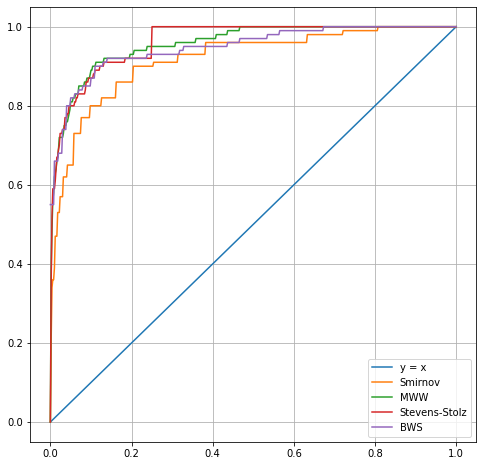

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 500)
plt.plot(x, x, label = 'y = x')

pvalue_ks = [sps.ks_2samp(X[i], Y[i]).pvalue for i in range(N)]
pvalue_mww = sps.mannwhitneyu(X, Y, axis=1).pvalue
pvalue_ss = [sps.anderson_ksamp((X[i], Y[i])).pvalue for i in range(N)]
pvalue_bws = np.empty(N)
T = statistic_BWS(X, Y)
T_perm = np.empty((N, N))
for i in range(N):
  perm = np.random.permutation(np.hstack((X, Y)).T).T
  X_new, Y_new = perm[:, :n], perm[:, n:]
  T_perm[i] = statistic_BWS(X_new, Y_new)
pvalue_bws = np.sum(T_perm > T, axis=0) / (N + 1)

plt.plot(x, EDF(x, pvalue_ks), label = 'Smirnov')
plt.plot(x, EDF(x, pvalue_mww), label = 'MWW')
plt.plot(x, EDF(x, pvalue_ss), label = 'Stevens-Stolz')
plt.plot(x, EDF(x, pvalue_bws), label = 'BWS')

plt.grid()
plt.legend()
plt.show()

(c)
$ \\
X_i \sim \mathcal{N}(0, 1) \\
Y_j \sim \mathcal{N}(0, 3/2)
$

In [ ]:
n = 250
N = 100

In [ ]:
X = sps.norm().rvs(size=(N, n))
Y = sps.norm(scale = np.sqrt(3/2)).rvs(size=(N, n))

<ipython-input-65-9cd567f9f1f9>:7: UserWarning: p-value capped: true value larger than 0.25
  pvalue_ss = [sps.anderson_ksamp((X[i], Y[i])).pvalue for i in range(N)]


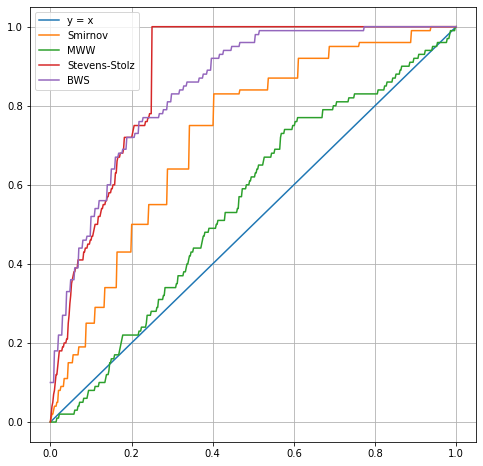

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 500)
plt.plot(x, x, label = 'y = x')

pvalue_ks = [sps.ks_2samp(X[i], Y[i]).pvalue for i in range(N)]
pvalue_mww = sps.mannwhitneyu(X, Y, axis=1).pvalue
pvalue_ss = [sps.anderson_ksamp((X[i], Y[i])).pvalue for i in range(N)]
pvalue_bws = np.empty(N)
T = statistic_BWS(X, Y)
T_perm = np.empty((N, N))
for i in range(N):
  perm = np.random.permutation(np.hstack((X, Y)).T).T
  X_new, Y_new = perm[:, :n], perm[:, n:]
  T_perm[i] = statistic_BWS(X_new, Y_new)
pvalue_bws = np.sum(T_perm > T, axis=0) / (N + 1)

plt.plot(x, EDF(x, pvalue_ks), label = 'Smirnov')
plt.plot(x, EDF(x, pvalue_mww), label = 'MWW')
plt.plot(x, EDF(x, pvalue_ss), label = 'Stevens-Stolz')
plt.plot(x, EDF(x, pvalue_bws), label = 'BWS')

plt.grid()
plt.legend()
plt.show()

(d)
$ \\
X_i \sim \mathcal{N}(0, 1) \\
Y_j \sim t_k
$

In [ ]:
n = 100
N = 100
k = 3

In [ ]:
X = sps.norm().rvs(size=(N, n))
Y = sps.t(df = k).rvs(size=(N, n))

<ipython-input-71-9cd567f9f1f9>:7: UserWarning: p-value capped: true value larger than 0.25
  pvalue_ss = [sps.anderson_ksamp((X[i], Y[i])).pvalue for i in range(N)]


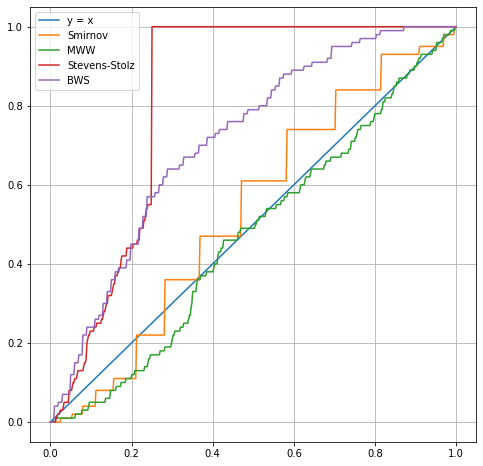

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 500)
plt.plot(x, x, label = 'y = x')

pvalue_ks = [sps.ks_2samp(X[i], Y[i]).pvalue for i in range(N)]
pvalue_mww = sps.mannwhitneyu(X, Y, axis=1).pvalue
pvalue_ss = [sps.anderson_ksamp((X[i], Y[i])).pvalue for i in range(N)]
pvalue_bws = np.empty(N)
T = statistic_BWS(X, Y)
T_perm = np.empty((N, N))
for i in range(N):
  perm = np.random.permutation(np.hstack((X, Y)).T).T
  X_new, Y_new = perm[:, :n], perm[:, n:]
  T_perm[i] = statistic_BWS(X_new, Y_new)
pvalue_bws = np.sum(T_perm > T, axis=0) / (N + 1)

plt.plot(x, EDF(x, pvalue_ks), label = 'Smirnov')
plt.plot(x, EDF(x, pvalue_mww), label = 'MWW')
plt.plot(x, EDF(x, pvalue_ss), label = 'Stevens-Stolz')
plt.plot(x, EDF(x, pvalue_bws), label = 'BWS')

plt.grid()
plt.legend()
plt.show()

(e)
$ \\
X_i \sim \mathcal{N}(0, 1) \\
Y_j = (U_1 + U_2 + \dots + U_k) / \sqrt{\frac{k}{3}}, \: U_i \sim R[-1,1]
$

In [ ]:
n = 100
N = 100
k = 5

In [ ]:
X = sps.norm().rvs(size=(N, n))
Y = np.sum(sps.uniform(scale=2, loc=-1).rvs(size = (N, n, k)), axis=2) / np.sqrt(k / 3)

<ipython-input-77-9cd567f9f1f9>:7: UserWarning: p-value capped: true value larger than 0.25
  pvalue_ss = [sps.anderson_ksamp((X[i], Y[i])).pvalue for i in range(N)]


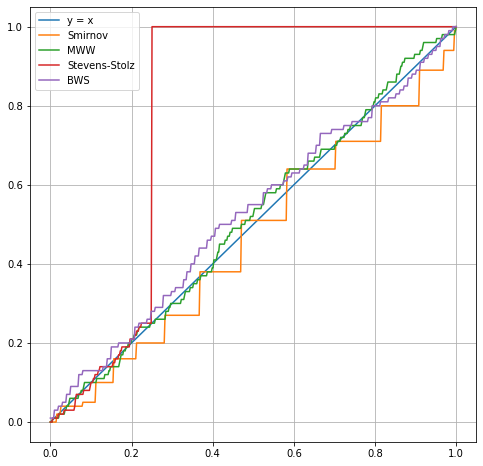

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 500)
plt.plot(x, x, label = 'y = x')

pvalue_ks = [sps.ks_2samp(X[i], Y[i]).pvalue for i in range(N)]
pvalue_mww = sps.mannwhitneyu(X, Y, axis=1).pvalue
pvalue_ss = [sps.anderson_ksamp((X[i], Y[i])).pvalue for i in range(N)]
pvalue_bws = np.empty(N)
T = statistic_BWS(X, Y)
T_perm = np.empty((N, N))
for i in range(N):
  perm = np.random.permutation(np.hstack((X, Y)).T).T
  X_new, Y_new = perm[:, :n], perm[:, n:]
  T_perm[i] = statistic_BWS(X_new, Y_new)
pvalue_bws = np.sum(T_perm > T, axis=0) / (N + 1)

plt.plot(x, EDF(x, pvalue_ks), label = 'Smirnov')
plt.plot(x, EDF(x, pvalue_mww), label = 'MWW')
plt.plot(x, EDF(x, pvalue_ss), label = 'Stevens-Stolz')
plt.plot(x, EDF(x, pvalue_bws), label = 'BWS')

plt.grid()
plt.legend()
plt.show()

## Задача 4

(a)
$\\
X_{i, j} \sim \mathcal{N}(0, i + 2)
$

In [ ]:
n = 250
N = 100

In [ ]:
X = np.empty((4, N, n))
for i in range(4):
  X[i] = sps.norm(scale = np.sqrt(2 + i + 1)).rvs(size = (N, n))

<ipython-input-54-6d8b47f18e28>:6: UserWarning: p-value floored: true value smaller than 0.001
  pvalue_ss = [sps.anderson_ksamp((X[0][i], X[1][i], X[2][i], X[3][i])).pvalue for i in range(N)]


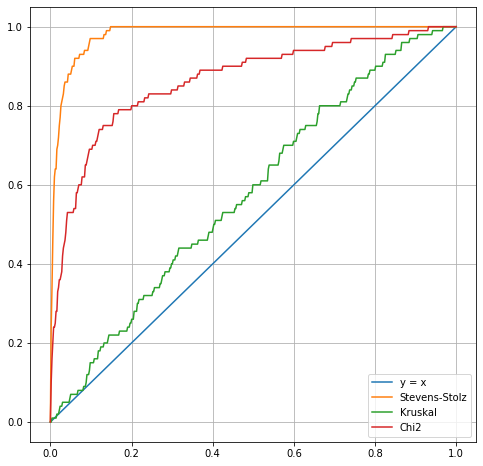

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 500)
plt.plot(x, x, label = 'y = x')

pvalue_krus = [sps.kruskal(X[0][i], X[1][i], X[2][i], X[3][i]).pvalue for i in range(N)]
pvalue_ss = [sps.anderson_ksamp((X[0][i], X[1][i], X[2][i], X[3][i])).pvalue for i in range(N)]

freq = [frequencies_for_chi2(X[i], sps.norm(scale=np.sqrt(3)).ppf, n) for i in range(4)]
pvalue_chi2 = [sps.chi2_contingency(np.vstack((freq[0][i], freq[1][i], freq[2][i], freq[3][i]))).pvalue for i in range(N)]

plt.plot(x, EDF(x, pvalue_ss), label = 'Stevens-Stolz')
plt.plot(x, EDF(x, pvalue_krus), label = 'Kruskal')
plt.plot(x, EDF(x, pvalue_chi2), label = 'Chi2')

plt.grid()
plt.legend()
plt.show()

(b)
$\\
X_{i, j} \sim \mathcal{N}(i/4, 1)
$

In [ ]:
n = 50
N = 100

In [ ]:
X = np.empty((4, N, n))
for i in range(4):
  X[i] = sps.norm(loc = (i + 1) / 4).rvs(size = (N, n))

<ipython-input-10-db61283c5d32>:6: UserWarning: p-value floored: true value smaller than 0.001
  pvalue_ss = [sps.anderson_ksamp((X[0][i], X[1][i], X[2][i], X[3][i])).pvalue for i in range(N)]
<ipython-input-10-db61283c5d32>:6: UserWarning: p-value capped: true value larger than 0.25
  pvalue_ss = [sps.anderson_ksamp((X[0][i], X[1][i], X[2][i], X[3][i])).pvalue for i in range(N)]


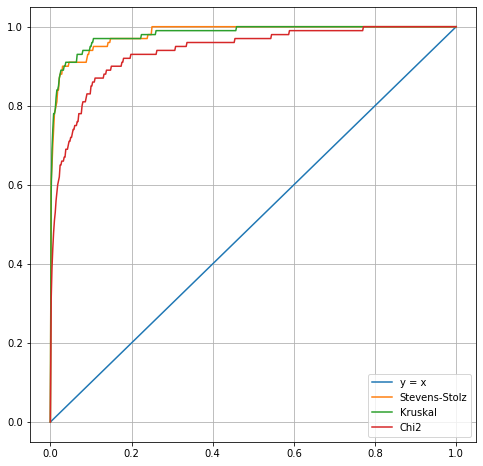

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 500)
plt.plot(x, x, label = 'y = x')

pvalue_krus = [sps.kruskal(X[0][i], X[1][i], X[2][i], X[3][i]).pvalue for i in range(N)]
pvalue_ss = [sps.anderson_ksamp((X[0][i], X[1][i], X[2][i], X[3][i])).pvalue for i in range(N)]

freq = [frequencies_for_chi2(X[i], sps.norm(loc = (1/4)).ppf, n) for i in range(4)]
pvalue_chi2 = [sps.chi2_contingency(np.vstack((freq[0][i], freq[1][i], freq[2][i], freq[3][i]))).pvalue for i in range(N)]

plt.plot(x, EDF(x, pvalue_ss), label = 'Stevens-Stolz')
plt.plot(x, EDF(x, pvalue_krus), label = 'Kruskal')
plt.plot(x, EDF(x, pvalue_chi2), label = 'Chi2')

plt.grid()
plt.legend()
plt.show()

(c)
$ \\
X_{i, j} \sim t_{3 + i}
$

In [ ]:
n = 1000
N = 250

In [ ]:
X = np.empty((4, N, n))
for i in range(4):
  X[i] = sps.t(df = 4 + i).rvs(size = (N, n))

<ipython-input-13-0d5f28710eb6>:6: UserWarning: p-value capped: true value larger than 0.25
  pvalue_ss = [sps.anderson_ksamp((X[0][i], X[1][i], X[2][i], X[3][i])).pvalue for i in range(N)]
<ipython-input-13-0d5f28710eb6>:6: UserWarning: p-value floored: true value smaller than 0.001
  pvalue_ss = [sps.anderson_ksamp((X[0][i], X[1][i], X[2][i], X[3][i])).pvalue for i in range(N)]


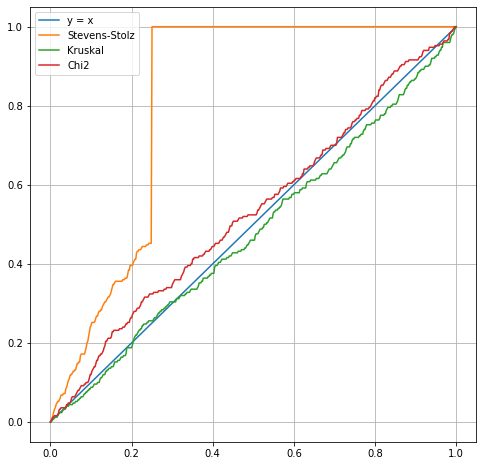

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 500)
plt.plot(x, x, label = 'y = x')

pvalue_krus = [sps.kruskal(X[0][i], X[1][i], X[2][i], X[3][i]).pvalue for i in range(N)]
pvalue_ss = [sps.anderson_ksamp((X[0][i], X[1][i], X[2][i], X[3][i])).pvalue for i in range(N)]

freq = [frequencies_for_chi2(X[i], sps.t(df=4).ppf, n) for i in range(4)]
pvalue_chi2 = [sps.chi2_contingency(np.vstack((freq[0][i], freq[1][i], freq[2][i], freq[3][i]))).pvalue for i in range(N)]

plt.plot(x, EDF(x, pvalue_ss), label = 'Stevens-Stolz')
plt.plot(x, EDF(x, pvalue_krus), label = 'Kruskal')
plt.plot(x, EDF(x, pvalue_chi2), label = 'Chi2')

plt.grid()
plt.legend()
plt.show()

# Тема 4

## Задача 1

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/MathPrac/Priem.csv', encoding='cp1251', sep=';')

In [ ]:
data.head()

,Пол,Сумма.баллов,ЕГЭ...матем.,ЕГЭ...рус.яз.,Аттестат.с.отличием.оценка,ГТО.оценка,Сочинение.оценка,Регион,Тип.насел..пункта,Дата.рождения,День.рождения,Месяц.рождения
0,МУЖСКОЙ,388,90.0,98.0,5,0,1,Красноярский край,ГОРОД,24.09.1998,24,9
1,ЖЕНСКИЙ,351,84.0,87.0,0,0,2,Чувашская Респ,ЦЕНТР СУБЪЕКТА ФЕДЕРАЦИИ,14.02.1997,14,2
2,ЖЕНСКИЙ,355,94.0,91.0,5,0,2,Москва г,ГОРОД ФЕДЕРАЛЬНОГО ЗНАЧЕНИЯ,25.03.2000,25,3
3,ЖЕНСКИЙ,338,76.0,88.0,5,0,2,Москва г,ГОРОД ФЕДЕРАЛЬНОГО ЗНАЧЕНИЯ,19.11.1999,19,11
4,МУЖСКОЙ,349,82.0,93.0,5,0,2,Москва г,ГОРОД ФЕДЕРАЛЬНОГО ЗНАЧЕНИЯ,12.12.1999,12,12


In [ ]:
# обычная корреляция баллов
r = (((data['ЕГЭ...матем.'] - data['ЕГЭ...матем.'].mean()) *
      (data['ЕГЭ...рус.яз.'] - data['ЕГЭ...рус.яз.'].mean())).mean() /
        (data['ЕГЭ...матем.'].std() * data['ЕГЭ...рус.яз.'].std()))
r

0.1520046884544055

In [ ]:
r_math_cert = (((data['ЕГЭ...матем.'] - data['ЕГЭ...матем.'].mean()) *
                  (data['Аттестат.с.отличием.оценка'] - data['Аттестат.с.отличием.оценка'].mean())).mean() /
                    (data['ЕГЭ...матем.'].std() * data['Аттестат.с.отличием.оценка'].std()))
r_rus_cert = (((data['ЕГЭ...рус.яз.'] - data['ЕГЭ...рус.яз.'].mean()) *
                  (data['Аттестат.с.отличием.оценка'] - data['Аттестат.с.отличием.оценка'].mean())).mean() /
                    (data['ЕГЭ...рус.яз.'].std() * data['Аттестат.с.отличием.оценка'].std()))

In [ ]:
# частный коэффициент корреляции баллов при условии аттестата
(r - r_math_cert * r_rus_cert) / (np.sqrt((1 - r_math_cert ** 2) * (1 - r_rus_cert ** 2)))

0.1341291571612695

In [ ]:
r_math_sum = (((data['ЕГЭ...матем.'] - data['ЕГЭ...матем.'].mean()) *
                  (data['Сумма.баллов'] - data['Сумма.баллов'].mean())).mean() /
                    (data['ЕГЭ...матем.'].std() * data['Сумма.баллов'].std()))
r_rus_sum = (((data['ЕГЭ...рус.яз.'] - data['ЕГЭ...рус.яз.'].mean()) *
                  (data['Сумма.баллов'] - data['Сумма.баллов'].mean())).mean() /
                    (data['ЕГЭ...рус.яз.'].std() * data['Сумма.баллов'].std()))

In [ ]:
# частный коэффициент корреляции баллов при условии аттестата
(r - r_math_sum * r_rus_sum) / (np.sqrt((1 - r_math_sum ** 2) * (1 - r_rus_sum ** 2)))

-0.17069133661229607

## Задача 2

In [ ]:
!pip install hyppo
from hyppo.independence import Dcorr, HHG

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.6/146.6 kB 2.5 MB/s eta 0:00:00


(a)

In [ ]:
n = 100
N = 50

In [ ]:
alpha = sps.uniform(scale = 2 * np.pi).rvs(size = (N, n))
X = np.cos(alpha) + sps.norm(scale=np.sqrt(0.05)).rvs(size = (N, n))
Y = np.sin(alpha) + sps.norm(scale=np.sqrt(0.05)).rvs(size = (N, n))

In [ ]:
freq_chi2_2d(X[0], Y[0], n)

array([[ 9., 13., 12.],
       [18.,  2., 13.],
       [ 7., 18.,  8.]])

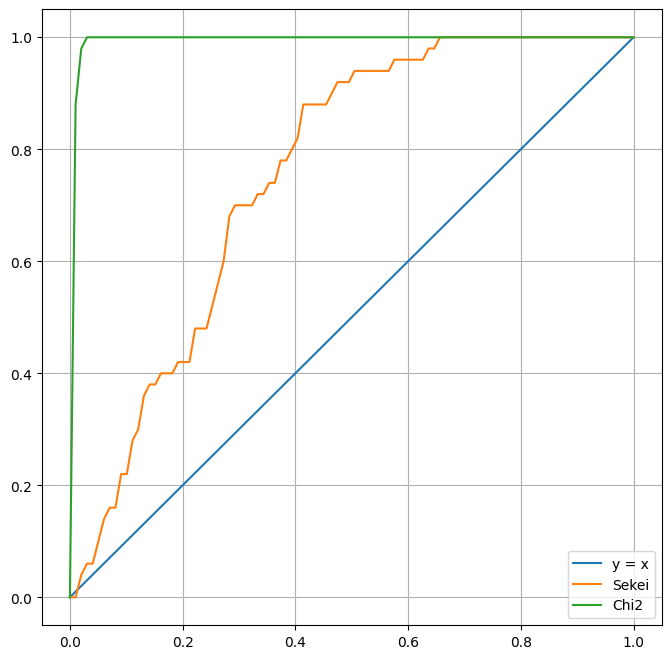

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 100)
plt.plot(x, x, label = 'y = x')

pvalue_chi2 = [sps.chi2_contingency(freq_chi2_2d(X[i], Y[i], n)).pvalue for i in range(N)]
pvalue_sekei = [Dcorr().test(X.T[i], Y.T[i], auto=False).pvalue for i in range(N)]
#pvalue_hhg = [HHG().test(X.T[i], Y.T[i], auto=False).pvalue for i in range(N)]

plt.plot(x, EDF(x, pvalue_sekei), label = 'Sekei')
#plt.plot(x, EDF(x, pvalue_hhg), label = 'HHG')
plt.plot(x, EDF(x, pvalue_chi2), label = 'Chi2')

plt.grid()
plt.legend()
plt.show()

(b)

In [ ]:
n = 1000
N = 150

In [ ]:
X = np.random.choice([-1, 1], size = (N, n)) + sps.norm(scale = np.sqrt(0.05)).rvs(size = (N, n))
Y = np.random.choice([-1, 1], size = (N, n)) + sps.norm(scale = np.sqrt(0.05)).rvs(size = (N, n))

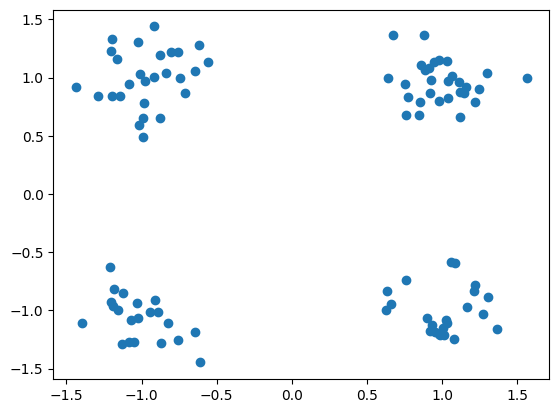

In [ ]:
plt.figure()
plt.scatter(X[0], Y[0])
plt.show()

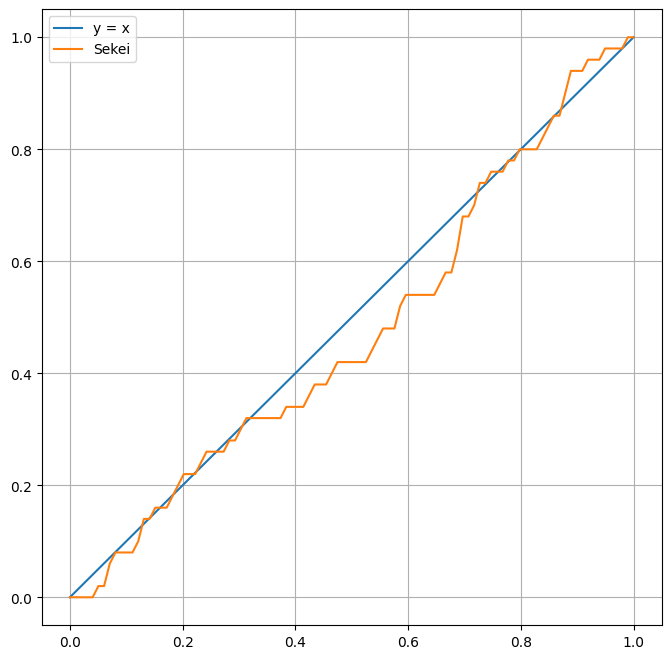

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 100)
plt.plot(x, x, label = 'y = x')

#pvalue_chi2 = [sps.chi2_contingency(freq_chi2_2d(X[i], Y[i], n)).pvalue for i in range(N)]
pvalue_sekei = [Dcorr().test(X.T[i], Y.T[i], auto=False).pvalue for i in range(N)]
#pvalue_hhg = [HHG().test(X.T[i], Y.T[i], auto=False).pvalue for i in range(N)]

plt.plot(x, EDF(x, pvalue_sekei), label = 'Sekei')
#plt.plot(x, EDF(x, pvalue_hhg), label = 'HHG')
#plt.plot(x, EDF(x, pvalue_chi2), label = 'Chi2')

plt.grid()
plt.legend()
plt.show()

(c)

In [ ]:
n = 100
N = 50

In [ ]:
t = sps.uniform(scale = 20).rvs(size = (N, n))
X = t * np.cos(t) / 3 + sps.norm(scale = np.sqrt(0.05)).rvs(size = (N, n))
Y = t * np.sin(t) / 3 + sps.norm(scale = np.sqrt(0.05)).rvs(size = (N, n))

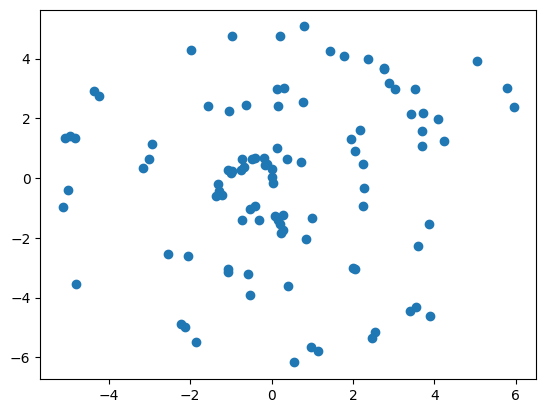

In [ ]:
plt.figure()
plt.scatter(X[0], Y[0])
plt.show()

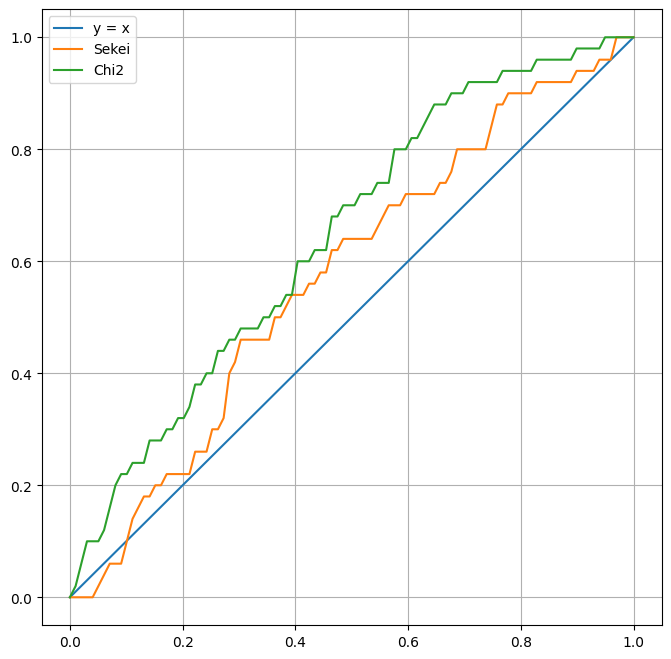

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 100)
plt.plot(x, x, label = 'y = x')

pvalue_chi2 = [sps.chi2_contingency(freq_chi2_2d(X[i], Y[i], n)).pvalue for i in range(N)]
pvalue_sekei = [Dcorr().test(X.T[i], Y.T[i], auto=False).pvalue for i in range(N)]
#pvalue_hhg = [HHG().test(X.T[i], Y.T[i], auto=False).pvalue for i in range(N)]

plt.plot(x, EDF(x, pvalue_sekei), label = 'Sekei')
#plt.plot(x, EDF(x, pvalue_hhg), label = 'HHG')
plt.plot(x, EDF(x, pvalue_chi2), label = 'Chi2')

plt.grid()
plt.legend()
plt.show()

## Задача 3

(a)
$ \\
Y_i = X_i ^ 2 + ɛ_i, \: X_i \sim R[-1, 2], \: ɛ_i \sim \mathcal{N}(0, 0.5)
$

In [ ]:
n = 500
N = 250

In [ ]:
X = sps.uniform(scale=2, loc=-1).rvs(size = (N, n))
Y = X ** 2 + sps.norm(scale=np.sqrt(0.5)).rvs(size = (N, n))

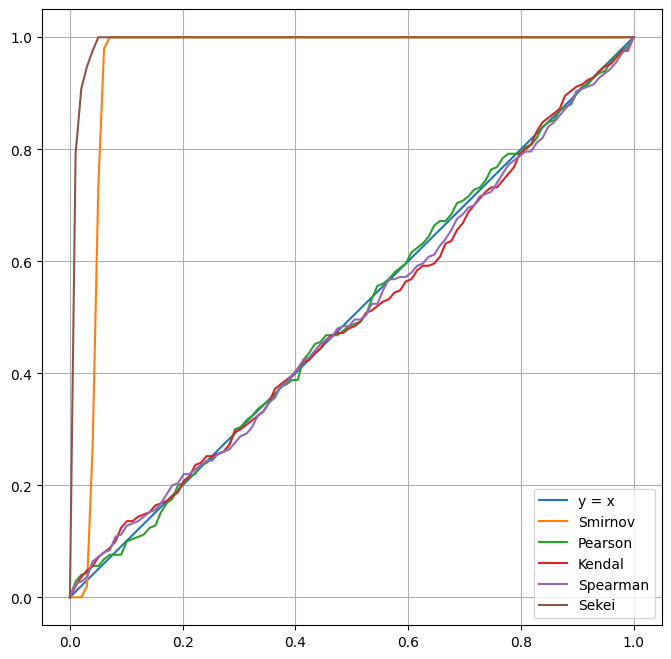

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 100)
plt.plot(x, x, label = 'y = x')

pvalue_smir = [statistic_Smir_ind(X[i], Y[i], x, x) for i in range(N)]
pvalue_pearson = [sps.pearsonr(X[i], Y[i]).pvalue for i in range(N)]
pvalue_kendal = [sps.kendalltau(X[i], Y[i]).pvalue for i in range(N)]
pvalue_spearman = [sps.spearmanr(X[i], Y[i]).pvalue for i in range(N)]
pvalue_sekei = [Dcorr().test(X.T[i], Y.T[i], auto=False).pvalue for i in range(N)]

plt.plot(x, EDF(x, pvalue_smir), label = 'Smirnov')
plt.plot(x, EDF(x, pvalue_pearson), label = 'Pearson')
plt.plot(x, EDF(x, pvalue_kendal), label = 'Kendal')
plt.plot(x, EDF(x, pvalue_spearman), label = 'Spearman')
plt.plot(x, EDF(x, pvalue_sekei), label = 'Sekei')

plt.grid()
plt.legend()
plt.show()

(b)
$\\
Y_i = \sin{X_i} + ɛ_i, \: X_i \sim R[0, 2π], \: ɛ_i \sim \mathcal{N}(0, 0.5)
$

In [ ]:
n = 30
N = 15

In [ ]:
X = sps.uniform(scale = 2 * np.pi).rvs(size = (N, n))
Y = np.sin(X) + sps.norm(scale=np.sqrt(0.5)).rvs(size = (N, n))

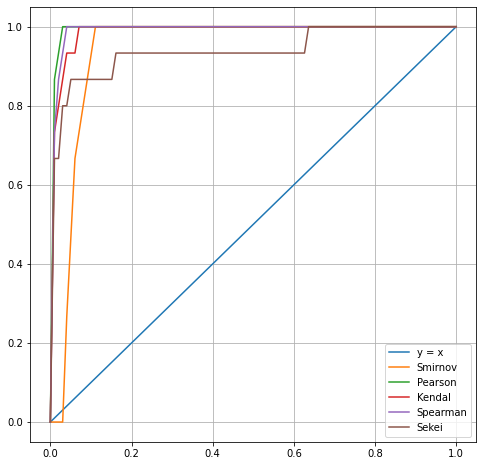

In [ ]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 1, 100)
plt.plot(x, x, label = 'y = x')

pvalue_smir = [statistic_Smir_ind(X[i], Y[i], x, x) for i in range(N)]
pvalue_pearson = [sps.pearsonr(X[i], Y[i]).pvalue for i in range(N)]
pvalue_kendal = [sps.kendalltau(X[i], Y[i]).pvalue for i in range(N)]
pvalue_spearman = [sps.spearmanr(X[i], Y[i]).pvalue for i in range(N)]
pvalue_sekei = [Dcorr().test(X.T[i], Y.T[i], auto=False).pvalue for i in range(N)]

plt.plot(x, EDF(x, pvalue_smir), label = 'Smirnov')
plt.plot(x, EDF(x, pvalue_pearson), label = 'Pearson')
plt.plot(x, EDF(x, pvalue_kendal), label = 'Kendal')
plt.plot(x, EDF(x, pvalue_spearman), label = 'Spearman')
plt.plot(x, EDF(x, pvalue_sekei), label = 'Sekei')

plt.grid()
plt.legend()
plt.show()

# Тема 5

## Задача 1

In [ ]:
a1 = np.array([[1/4, 3/4, 0, 0], [1/2, 0, 1/2, 0], [0, 1/2, 0, 1/2], [0, 0, 3/4, 1/4]])
a2 = np.array([[2/9, 1/3, 0, 4/9], [4/9, 1/9, 0, 4/9], [2/9, 2/9, 2/9, 1/3], [2/9, 2/9, 4/9, 1/9]])
a3 = np.array([[0, 1/2, 0, 1/2], [1/3, 0, 2/3, 0], [0, 1/4, 0, 3/4], [1/4, 0, 3/4, 0]])
a1, a2, a3

(array([[0.25, 0.75, 0.  , 0.  ],
        [0.5 , 0.  , 0.5 , 0.  ],
        [0.  , 0.5 , 0.  , 0.5 ],
        [0.  , 0.  , 0.75, 0.25]]),
 array([[0.22222222, 0.33333333, 0.        , 0.44444444],
        [0.44444444, 0.11111111, 0.        , 0.44444444],
        [0.22222222, 0.22222222, 0.22222222, 0.33333333],
        [0.22222222, 0.22222222, 0.44444444, 0.11111111]]),
 array([[0.        , 0.5       , 0.        , 0.5       ],
        [0.33333333, 0.        , 0.66666667, 0.        ],
        [0.        , 0.25      , 0.        , 0.75      ],
        [0.25      , 0.        , 0.75      , 0.        ]]))

(a)

In [ ]:
np.linalg.eig(a1.T)

(array([-0.84307033, -0.25      ,  1.        ,  0.59307033]),
 array([[ 0.29413772,  0.5       , -0.39223227, -0.58305539],
        [-0.64302644, -0.5       , -0.58834841, -0.40005801],
        [ 0.64302644, -0.5       , -0.58834841,  0.40005801],
        [-0.29413772,  0.5       , -0.39223227,  0.58305539]]))

In [ ]:
pi1 = np.linalg.eig(a1.T)[1][:, 2]
pi1 / np.sum(pi1)

array([0.2, 0.3, 0.3, 0.2])

In [ ]:
for n in [5, 10, 20, 30, 50]:
  print(np.linalg.matrix_power(a1, n), end='\n\n')

[[0.17675781 0.43066406 0.16992188 0.22265625]
 [0.28710938 0.14648438 0.453125   0.11328125]
 [0.11328125 0.453125   0.14648438 0.28710938]
 [0.22265625 0.16992188 0.43066406 0.17675781]]

[[0.22371578 0.25403881 0.34596062 0.17628479]
 [0.16935921 0.36967659 0.23032379 0.23064041]
 [0.23064041 0.23032379 0.36967659 0.16935921]
 [0.17628479 0.34596062 0.25403881 0.22371578]]

[[0.20394139 0.29141525 0.30858475 0.19605861]
 [0.19427683 0.31252614 0.28747386 0.20572317]
 [0.20572317 0.28747386 0.31252614 0.19427683]
 [0.19605861 0.30858475 0.29141525 0.20394139]]

[[0.20071303 0.29844139 0.30155861 0.19928697]
 [0.19896093 0.30227164 0.29772836 0.20103907]
 [0.20103907 0.29772836 0.30227164 0.19896093]
 [0.19928697 0.30155861 0.29844139 0.20071303]]

[[0.20002346 0.29994871 0.30005129 0.19997654]
 [0.19996581 0.30007475 0.29992525 0.20003419]
 [0.20003419 0.29992525 0.30007475 0.19996581]
 [0.19997654 0.30005129 0.29994871 0.20002346]]



(b)

In [ ]:
np.linalg.eig(a2.T)

(array([ 1.        , -0.22222222,  0.11111111, -0.22222222]),
 array([[-0.53452248, -0.44589632,  0.42640143,  0.54059892],
        [-0.4454354 ,  0.44589632,  0.21320072, -0.54059892],
        [-0.35634832, -0.54879547, -0.85280287, -0.45579909],
        [-0.62360956,  0.54879547,  0.21320072,  0.45579909]]))

In [ ]:
pi2 = np.linalg.eig(a2.T)[1][:, 0]
pi2 / np.sum(pi2)

array([0.27272727, 0.22727273, 0.18181818, 0.31818182])

In [ ]:
for n in [5, 10, 20, 30, 50]:
  print(np.linalg.matrix_power(a2, n), end='\n\n')

[[0.27251943 0.22748903 0.18154414 0.31844739]
 [0.27306136 0.22694711 0.18154414 0.31844739]
 [0.27268878 0.22730275 0.18174736 0.31826111]
 [0.27268878 0.22730275 0.18228929 0.31771918]]

[[0.27272739 0.22727261 0.18181832 0.31818168]
 [0.27272709 0.22727291 0.18181832 0.31818168]
 [0.27272729 0.22727271 0.18181823 0.31818177]
 [0.27272729 0.22727271 0.18181793 0.31818207]]

[[0.27272727 0.22727273 0.18181818 0.31818182]
 [0.27272727 0.22727273 0.18181818 0.31818182]
 [0.27272727 0.22727273 0.18181818 0.31818182]
 [0.27272727 0.22727273 0.18181818 0.31818182]]

[[0.27272727 0.22727273 0.18181818 0.31818182]
 [0.27272727 0.22727273 0.18181818 0.31818182]
 [0.27272727 0.22727273 0.18181818 0.31818182]
 [0.27272727 0.22727273 0.18181818 0.31818182]]

[[0.27272727 0.22727273 0.18181818 0.31818182]
 [0.27272727 0.22727273 0.18181818 0.31818182]
 [0.27272727 0.22727273 0.18181818 0.31818182]
 [0.27272727 0.22727273 0.18181818 0.31818182]]



(c)

In [ ]:
np.linalg.eig(a3.T)

(array([-1.        ,  1.        , -0.14433757,  0.14433757]),
 array([[-0.25623537,  0.25623537, -0.35355339, -0.35355339],
        [ 0.2956562 ,  0.2956562 ,  0.61237244, -0.61237244],
        [-0.67015405,  0.67015405,  0.35355339,  0.35355339],
        [ 0.63073322,  0.63073322, -0.61237244,  0.61237244]]))

In [ ]:
pi3 = np.linalg.eig(a3.T)[1][:, 1]
pi3 / np.sum(pi3)

array([0.13829787, 0.15957447, 0.36170213, 0.34042553])

In [ ]:
for n in [5, 10, 20, 31, 50]:
  print(np.linalg.matrix_power(a3, n), end='\n\n')

[[0.         0.31922743 0.         0.68077257]
 [0.27662037 0.         0.72337963 0.        ]
 [0.         0.31911892 0.         0.68088108]
 [0.2765842  0.         0.7234158  0.        ]]

[[0.27659575 0.         0.72340425 0.        ]
 [0.         0.31914894 0.         0.68085106]
 [0.27659574 0.         0.72340426 0.        ]
 [0.         0.31914893 0.         0.68085107]]

[[0.27659574 0.         0.72340426 0.        ]
 [0.         0.31914894 0.         0.68085106]
 [0.27659574 0.         0.72340426 0.        ]
 [0.         0.31914894 0.         0.68085106]]

[[0.         0.31914894 0.         0.68085106]
 [0.27659574 0.         0.72340426 0.        ]
 [0.         0.31914894 0.         0.68085106]
 [0.27659574 0.         0.72340426 0.        ]]

[[0.27659574 0.         0.72340426 0.        ]
 [0.         0.31914894 0.         0.68085106]
 [0.27659574 0.         0.72340426 0.        ]
 [0.         0.31914894 0.         0.68085106]]



## Задача 2

In [ ]:
P = np.array([[1/3, 1/3, 1/3], [3/4, 0, 1/4], [1/2, 1/6, 1/3]])
P

array([[0.33333333, 0.33333333, 0.33333333],
       [0.75      , 0.        , 0.25      ],
       [0.5       , 0.16666667, 0.33333333]])

In [ ]:
np.linalg.eig(P.T)

(array([ 1.        , -0.37079081,  0.03745748]),
 array([[-0.78039897, -0.76688827, -0.44872717],
        [-0.34684399,  0.62616165, -0.3663842 ],
        [-0.52026598,  0.14072662,  0.81511137]]))

In [ ]:
pi = np.linalg.eig(P.T)[1][:, 0]
pi = pi / pi.sum()
pi

array([0.47368421, 0.21052632, 0.31578947])

траектория

In [ ]:
n = 30000
length = 30

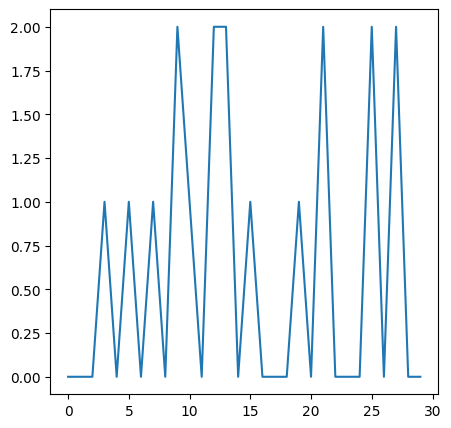

In [ ]:
pos = np.empty(n, dtype=int)
prev = np.random.choice([0, 1, 2])
pos[0] = prev
for i in range(n - 1):
  curr = np.random.choice([0, 1, 2], p = P[pos[i]])
  pos[i + 1] = curr
plt.figure(figsize=(5, 5))
x = np.arange(0, length, 1)
plt.plot(x, pos[:length])
plt.show()

доля посещений

In [ ]:
for i in [0, 1, 2]:
  print(f'доля {i}: {np.sum(pos == i) / n}')

доля 0: 0.4776666666666667
доля 1: 0.2089
доля 2: 0.31343333333333334


гистограмма

In [ ]:
n = 1000

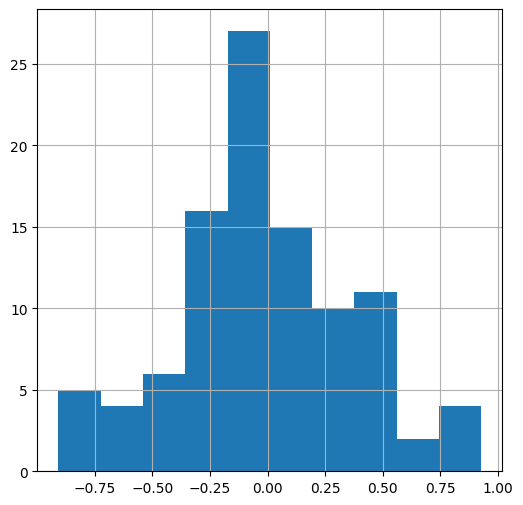

In [ ]:
pos = np.empty((100, n), dtype=int)
prev = np.random.choice([0, 1, 2])
pos[:, 0] = prev * np.ones(100)
for j in range(100):
  for i in range(n - 1):
    curr = np.random.choice([0, 1, 2], p = P[pos[j, i]])
    pos[j, i + 1] = curr
plt.figure(figsize=(6, 6))
plt.hist(np.sqrt(n) * (np.sum(pos == 0, axis=1) / n - pi[0]))
plt.grid()
plt.show()

## Задача 3

In [ ]:
file = open('/content/drive/MyDrive/MathPrac/MarkovChain.txt', 'r', encoding='utf-8')
P = np.array(list([np.array(list([p for p in line.split(';')])) for line in file.readlines()]))
file.close()

In [ ]:
P[0][0] = 0
P = np.array(list([np.array(list([float(p) for p in line])) for line in P]))

In [ ]:
P.shape

(50, 50)

In [ ]:
def communicating(P, E, j, number):
  for i in np.where(P[j] != 0)[0]:
    if i in E[number]:
      continue
    E[number].append(i)
    communicating(P, E, i, number)

In [ ]:
E = [[0]]
communicating(P, E, 0, 0)
diff = list(set(range(1, 50)) - set(E[0]))
number = 1
while diff != []:
  E.append([])
  communicating(P, E, diff[0], number)
  diff = list(set(diff) - set(E[number]))
  number += 1

In [ ]:
for i in range(len(E)):
  E[i].sort()

In [ ]:
E

[[0, 37],
 [1,
  2,
  5,
  7,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  19,
  20,
  21,
  25,
  26,
  27,
  28,
  29,
  30,
  32,
  33,
  34,
  35,
  42,
  43,
  44,
  47,
  49],
 [3, 17, 48],
 [4, 16, 18, 22, 41, 46],
 [6, 8, 23, 24, 36, 38, 40, 45],
 [31, 39]]

In [ ]:
def S__(P, states, S, number):
  if S[number - 1] != [] and S[-1] != []:
    S.append([])
  if number == 1 and S[1] != []:
    return
  for state in states:
    if state in S[0]:
        number = 0
        continue
    if state in S[number]:
      continue
    S[number].append(state)
    S__(P, np.where(P[state] > 0)[0], S, number + 1)

In [ ]:
for i in range(len(E)):
  S = [[E[i][0]]]
  S__(P, np.where(P[E[i][0]] > 0)[0], S, 1)
  print(S, end='\n\n')

[[0], [37], []]

[[1, 14, 26, 28, 30], [5, 9, 11, 20, 25, 43], [2, 7, 13, 19, 27, 32, 33, 34, 42], [10, 12, 15, 21, 29, 35, 44, 47, 49], []]

[[3], [17], [48], []]

[[4], [16, 46], [18, 22, 41], []]

[[6, 8, 23, 38], [24, 36, 40, 45], []]

[[31], [39], []]



In [ ]:
S = [[0]]
S__(P, np.where(P[0] > 0)[0], S, 1)
S

[[0], [37], []]

## Задача 4

In [ ]:
P = np.array([[0, 0, 1/2, 1/2], [0, 0, 0, 1], [1/2, 0, 0, 1/2], [1/3, 1/3, 1/3, 0]])
P

array([[0.        , 0.        , 0.5       , 0.5       ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.5       , 0.        , 0.        , 0.5       ],
       [0.33333333, 0.33333333, 0.33333333, 0.        ]])

In [ ]:
np.linalg.eig(P.T)

(array([ 1.        ,  0.22871355, -0.5       , -0.72871355]),
 array([[ 4.71404521e-01,  4.95724430e-01, -7.07106781e-01,
         -2.32931941e-01],
        [ 2.35702260e-01, -5.87998904e-01, -5.64873243e-17,
         -3.92756017e-01],
        [ 4.71404521e-01,  4.95724430e-01,  7.07106781e-01,
         -2.32931941e-01],
        [ 7.07106781e-01, -4.03449957e-01,  9.87169579e-17,
          8.58619900e-01]]))

In [ ]:
pi = np.linalg.eig(P.T)[1][:, 0]
pi = pi / pi.sum()
pi

array([0.25 , 0.125, 0.25 , 0.375])

In [ ]:
P_inv = np.empty((4, 4))
for i in range(4):
  for j in range(4):
    P_inv[i, j] = P[j, i] * pi[j] / pi[i]
P_inv

array([[0.        , 0.        , 0.5       , 0.5       ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.5       , 0.        , 0.        , 0.5       ],
       [0.33333333, 0.33333333, 0.33333333, 0.        ]])

## Задача 5

(a)

In [ ]:
np.cumsum(np.where(sps.bernoulli(1/2).rvs(size=100), 1, -1))

array([ 1,  0, -1, -2, -1, -2, -3, -2, -1,  0,  1,  0, -1,  0,  1,  2,  1,
        2,  1,  0,  1,  0, -1, -2, -1,  0,  1,  2,  1,  0,  1,  2,  3,  4,
        3,  4,  3,  2,  3,  4,  5,  6,  5,  6,  7,  8,  9,  8,  7,  6,  5,
        6,  7,  6,  7,  6,  5,  6,  5,  6,  7,  8,  7,  8,  7,  8,  7,  8,
        9, 10, 11, 10, 11, 12, 11, 10, 11, 10,  9,  8,  7,  8,  7,  6,  5,
        6,  5,  6,  7,  6,  5,  4,  5,  4,  5,  4,  5,  4,  5,  4])

In [ ]:
p = np.empty(100)
for i in range(100):
  coor = np.empty(1000)
  coor[0] = 0
  for n in range(1, 1000):
    step = np.random.choice([-1, 1])
    coor[n] = coor[n - 1] + step
  p[i] = 1 if np.sum(coor == 0) else 0
print(p)
p.mean()

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


1.0

(b)

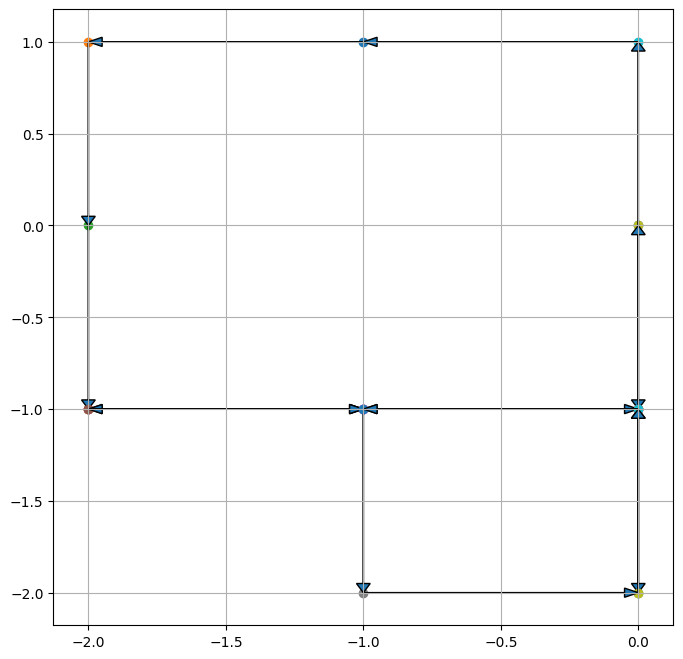

In [ ]:
plt.figure(figsize=(8, 8))
x = 0
y = 0
plt.scatter(x, y)
for i in range(20):
  x_new = x
  y_new = y
  s = np.random.choice([1, 2, 3, 4])
  if s == 1:
    x_new += 1
  elif s == 2:
    x_new -= 1
  elif s == 3:
    y_new += 1
  elif s == 4:
    y_new -= 1
  plt.scatter(x_new, y_new)
  plt.arrow(x, y, x_new - x, y_new - y,
            length_includes_head=True, width = 0.001, head_width = 0.05, head_length = 0.05)
  x = x_new
  y = y_new
plt.grid()
plt.show()

In [ ]:
p = np.empty(50)
for i in range(50):
  coor = np.empty((5000, 2))
  coor[0][0], coor[0, 1] = 0, 0
  for n in range(1, 5000):
    step = np.random.permutation([[-1, 0], [1, 0], [0, 1], [0, -1]])[0]
    coor[n] = coor[n - 1] + step
  p[i] = 1 if np.sum((coor[1:, 0] == 0) & (coor[1:, 1] == 0)) else 0
print(p)
p.mean()

[1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 1. 1.]


0.76

(c)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

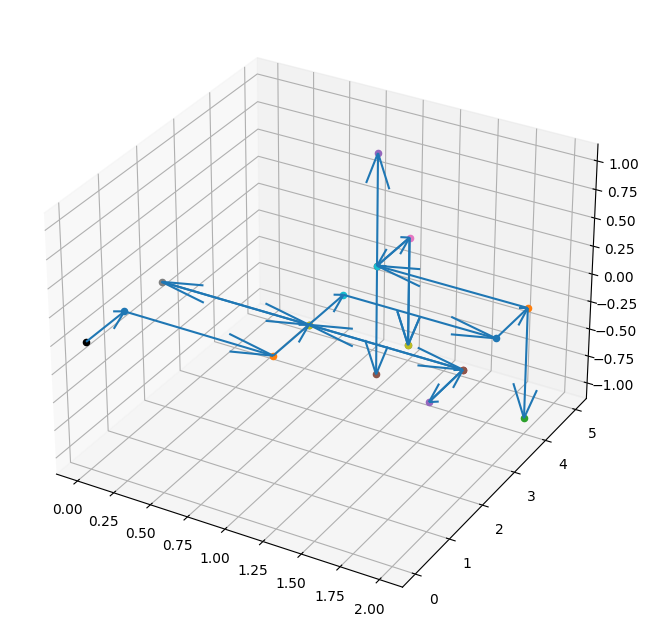

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
x = 0
y = 0
z = 0
ax.scatter(x, y, z, c='black')
for i in range(20):
  x_new = x
  y_new = y
  z_new = z
  s = np.random.choice([1, 2, 3, 4, 5, 6])
  if s == 1:
    x_new += 1
  elif s == 2:
    x_new -= 1
  elif s == 3:
    y_new += 1
  elif s == 4:
    y_new -= 1
  elif s == 5:
    z_new += 1
  elif s == 6:
    z_new -= 1
  ax.scatter(x_new, y_new, z_new)
  ax.quiver(x, y, z, x_new - x, y_new - y, z_new - z)
  x = x_new
  y = y_new
plt.grid()
plt.show()

In [ ]:
p = np.empty(300)
for i in range(300):
  coor = np.empty((500, 3))
  coor[0, 0], coor[0, 1], coor[0, 2] = 0, 0, 0
  for n in range(1, 500):
    step = np.random.permutation([[-1, 0, 0], [1, 0, 0], [0, 1, 0], [0, -1, 0], [0, 0, 1], [0, 0, -1]])[0]
    coor[n] = coor[n - 1] + step
  p[i] = 1 if np.sum((coor[1:, 0] == 0) & (coor[1:, 1] == 0) & (coor[1:, 2] == 0)) else 0
print(p)
p.mean()

[0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0.
 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]


0.3

# Тема 6

$
\mathbb{E}X = \frac{q}{p} \\
\phi(s) = \mathbb{E} s ^ X = \sum_{k=0}^\infty s^k q^k p = p \sum_{k=0}^\infty (s q) ^ k = \frac{p}{1 - s q} \\
\phi(s) = s \iff p = s - s ^ 2 q \iff p = s - s^2 + s^2 p \iff 0 = s (1 - s) - p (1 - s^2) \iff 0 = s(1-s) - p(1-s)(1+s) \iff 0 = (1-s)(s - p - ps) \iff s(1-p) - p = 0 \iff s = \frac{p}{q}
$

## Задача 1

In [ ]:
p = 1/3

In [ ]:
p / (1 - p)

0.49999999999999994

In [ ]:
count = 0
for j in tqdm(range(1000)):
  Z_prev = 1
  for n in range(1000):
    Z_curr = sps.nbinom(Z_prev, p).rvs()
    if Z_curr > 1000:
      break
    Z_prev = Z_curr
    if Z_prev == 0:
      count += 1
      break
count / 1000

  0%|          | 0/1000 [00:00<?, ?it/s]

0.498

## Задача 2

Критический

In [ ]:
p = 0.5005

In [ ]:
n = 50

In [ ]:
count = 0
for j in tqdm(range(1000)):
  Z = np.empty(n)
  Z[0] = 1
  for i in range(1, n):
    Z[i] = sps.nbinom(n=Z[i - 1], p=p).rvs()
    if Z[i] == 0:
      break
  else:
    count += 1
    print(Z)
count / 1000

  0%|          | 0/1000 [00:00<?, ?it/s]

[ 1.  1.  1.  4.  4.  3. 12. 15. 17. 22. 24. 18. 18. 12. 11. 15. 10.  8.
  7.  9. 16. 22. 26. 28. 16. 29. 17. 24. 45. 50. 58. 60. 55. 62. 64. 44.
 30. 29. 18. 35. 35. 39. 37. 40. 19. 18. 23. 21. 22. 26.]
[  1.   2.   3.   5.   3.   7.  11.  11.  11.  19.  14.  22.  20.  22.
  25.  40.  52.  42.  46.  42.  38.  38.  43.  60.  61.  77.  88. 101.
 112. 106. 112. 112. 122. 142. 129. 124. 123. 125. 110.  79.  68.  68.
  59.  54.  39.  27.  28.  38.  27.  21.]
[ 1.  3.  2.  1.  4.  9.  8. 10.  5.  5.  6. 11.  9. 10. 12. 15. 14.  9.
  5. 15. 11. 17. 14. 15. 12. 13. 15. 10. 19. 18. 29. 31. 31. 23. 31. 44.
 43. 42. 39. 41. 44. 37. 39. 36. 36. 31. 28. 21. 36. 35.]
[ 1.  8. 10. 12. 11. 16. 30. 31. 28. 34. 41. 56. 44. 35. 23. 20.  7.  7.
  7. 10.  7.  6.  5.  9.  5.  4.  3.  1.  3.  4. 10.  6.  6.  2.  7.  7.
 12. 13. 10. 14.  8. 16. 19. 19. 14. 13.  9. 10.  9.  7.]
[ 1.  4.  4.  7.  6. 11.  6.  6.  6.  7.  9.  7.  4.  3.  4.  5.  6.  2.
  1.  2.  2.  7.  5.  6.  6.  6. 12. 18. 20. 18. 24. 31. 26.

0.026

Докритический

In [ ]:
p = 0.55

In [ ]:
count = 0
for j in tqdm(range(1000)):
  Z = np.empty(n)
  Z[0] = 1
  for i in range(1, n):
    Z[i] = sps.nbinom(Z[i - 1], p).rvs()
    if Z[i] == 0:
      break
  else:
    count += 1
count / 1000

  0%|          | 0/1000 [00:00<?, ?it/s]

0.0

## Задача 3

In [ ]:
p = 0.45

In [ ]:
n = 20

In [ ]:
k1 = 5
k2 = 4

a) дискретное время

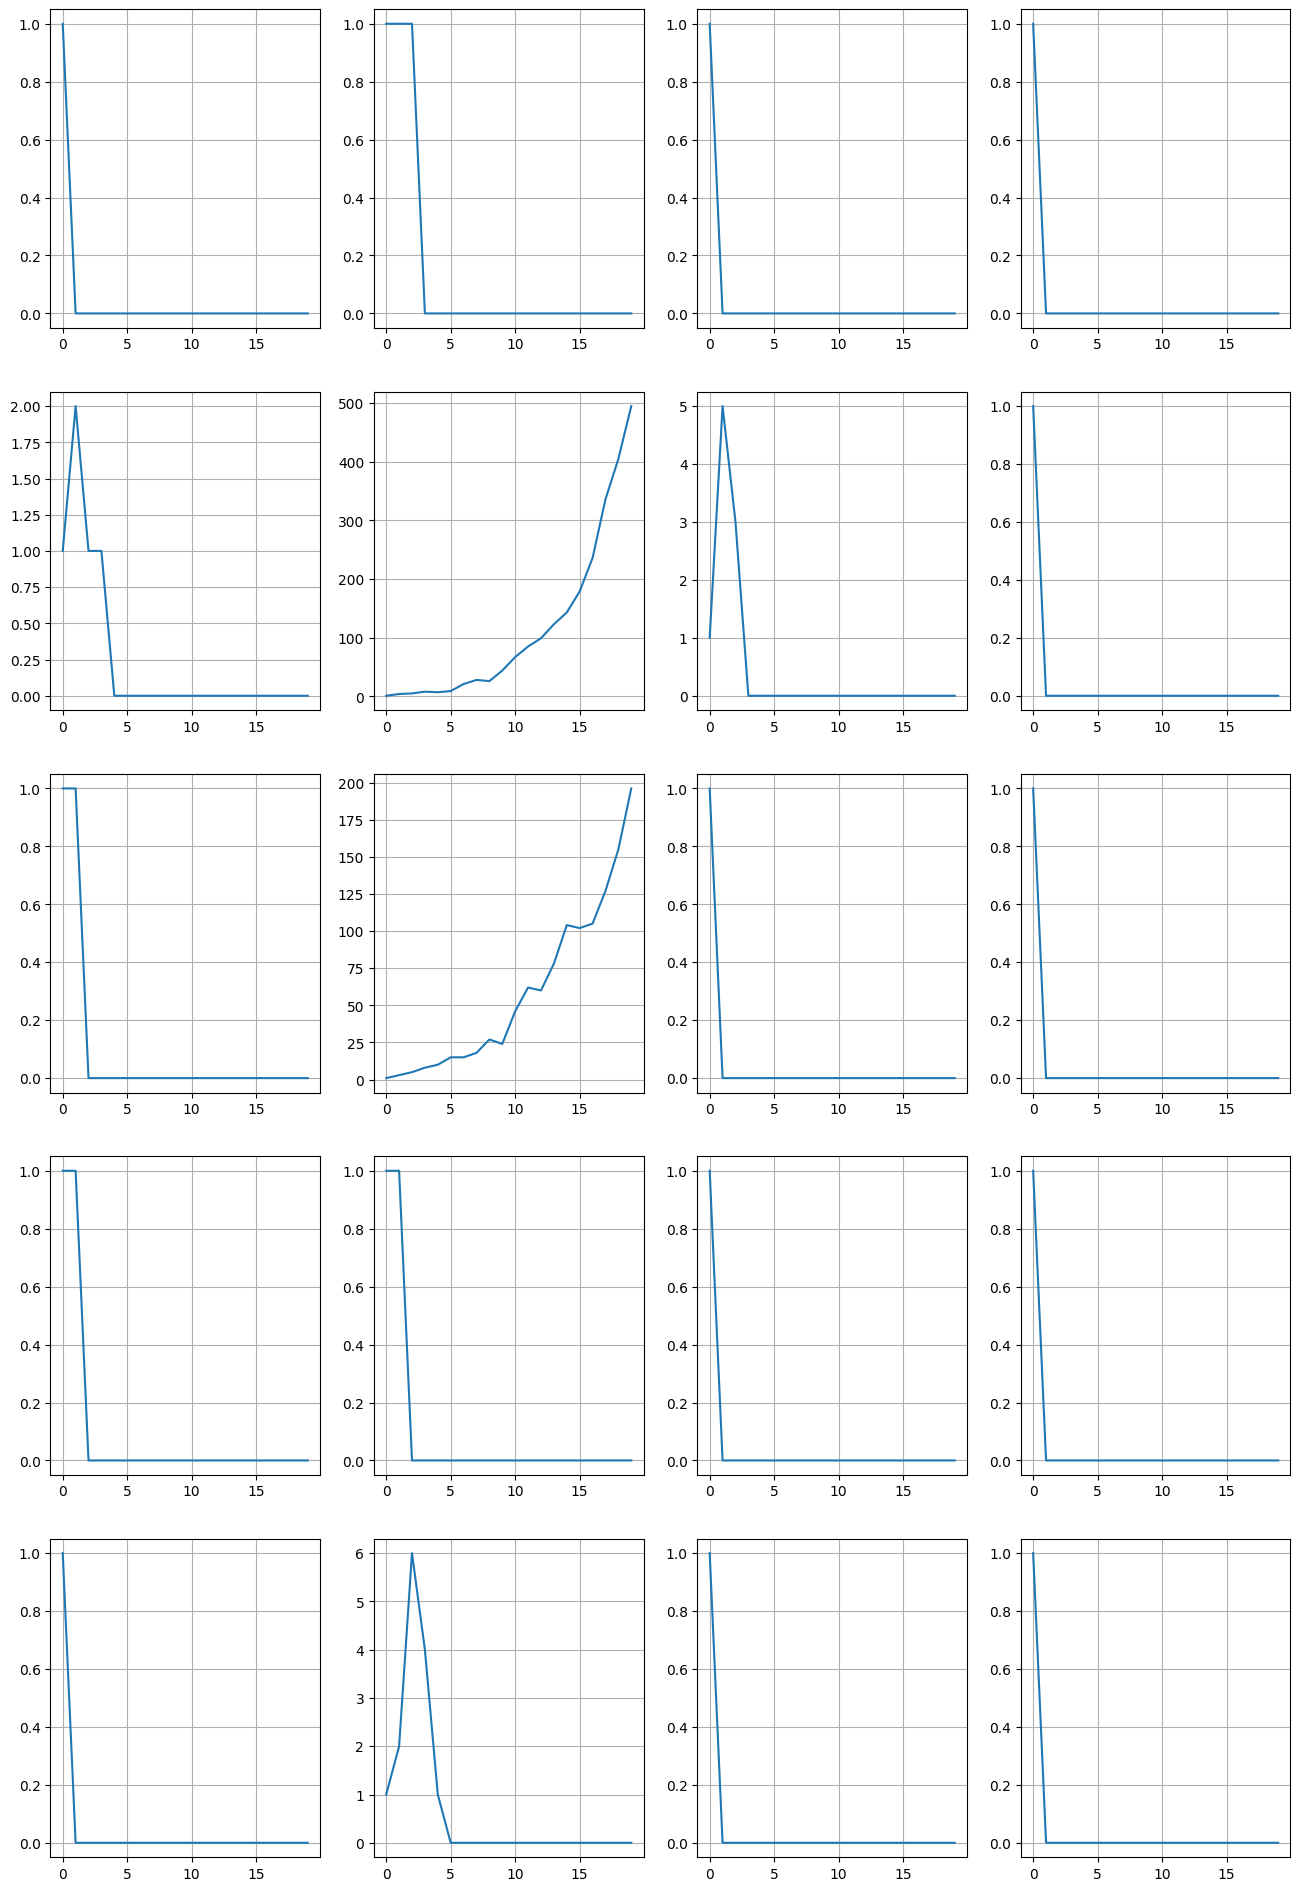

In [ ]:
fig, ax = plt.subplots(k1, k2, figsize = (16, 24))
count = 0
for j in range(k1):
  for m in range(k2):
    Z = np.zeros(n)
    Z[0] = 1
    for i in range(1, n):
      Z[i] = sps.nbinom(Z[i - 1], p).rvs()
      if Z[i] == 0:
        break
    ax[j][m].plot(np.arange(n), Z)
    ax[j][m].grid()
plt.show()

b) непрерывное время

In [ ]:
lamb = 1

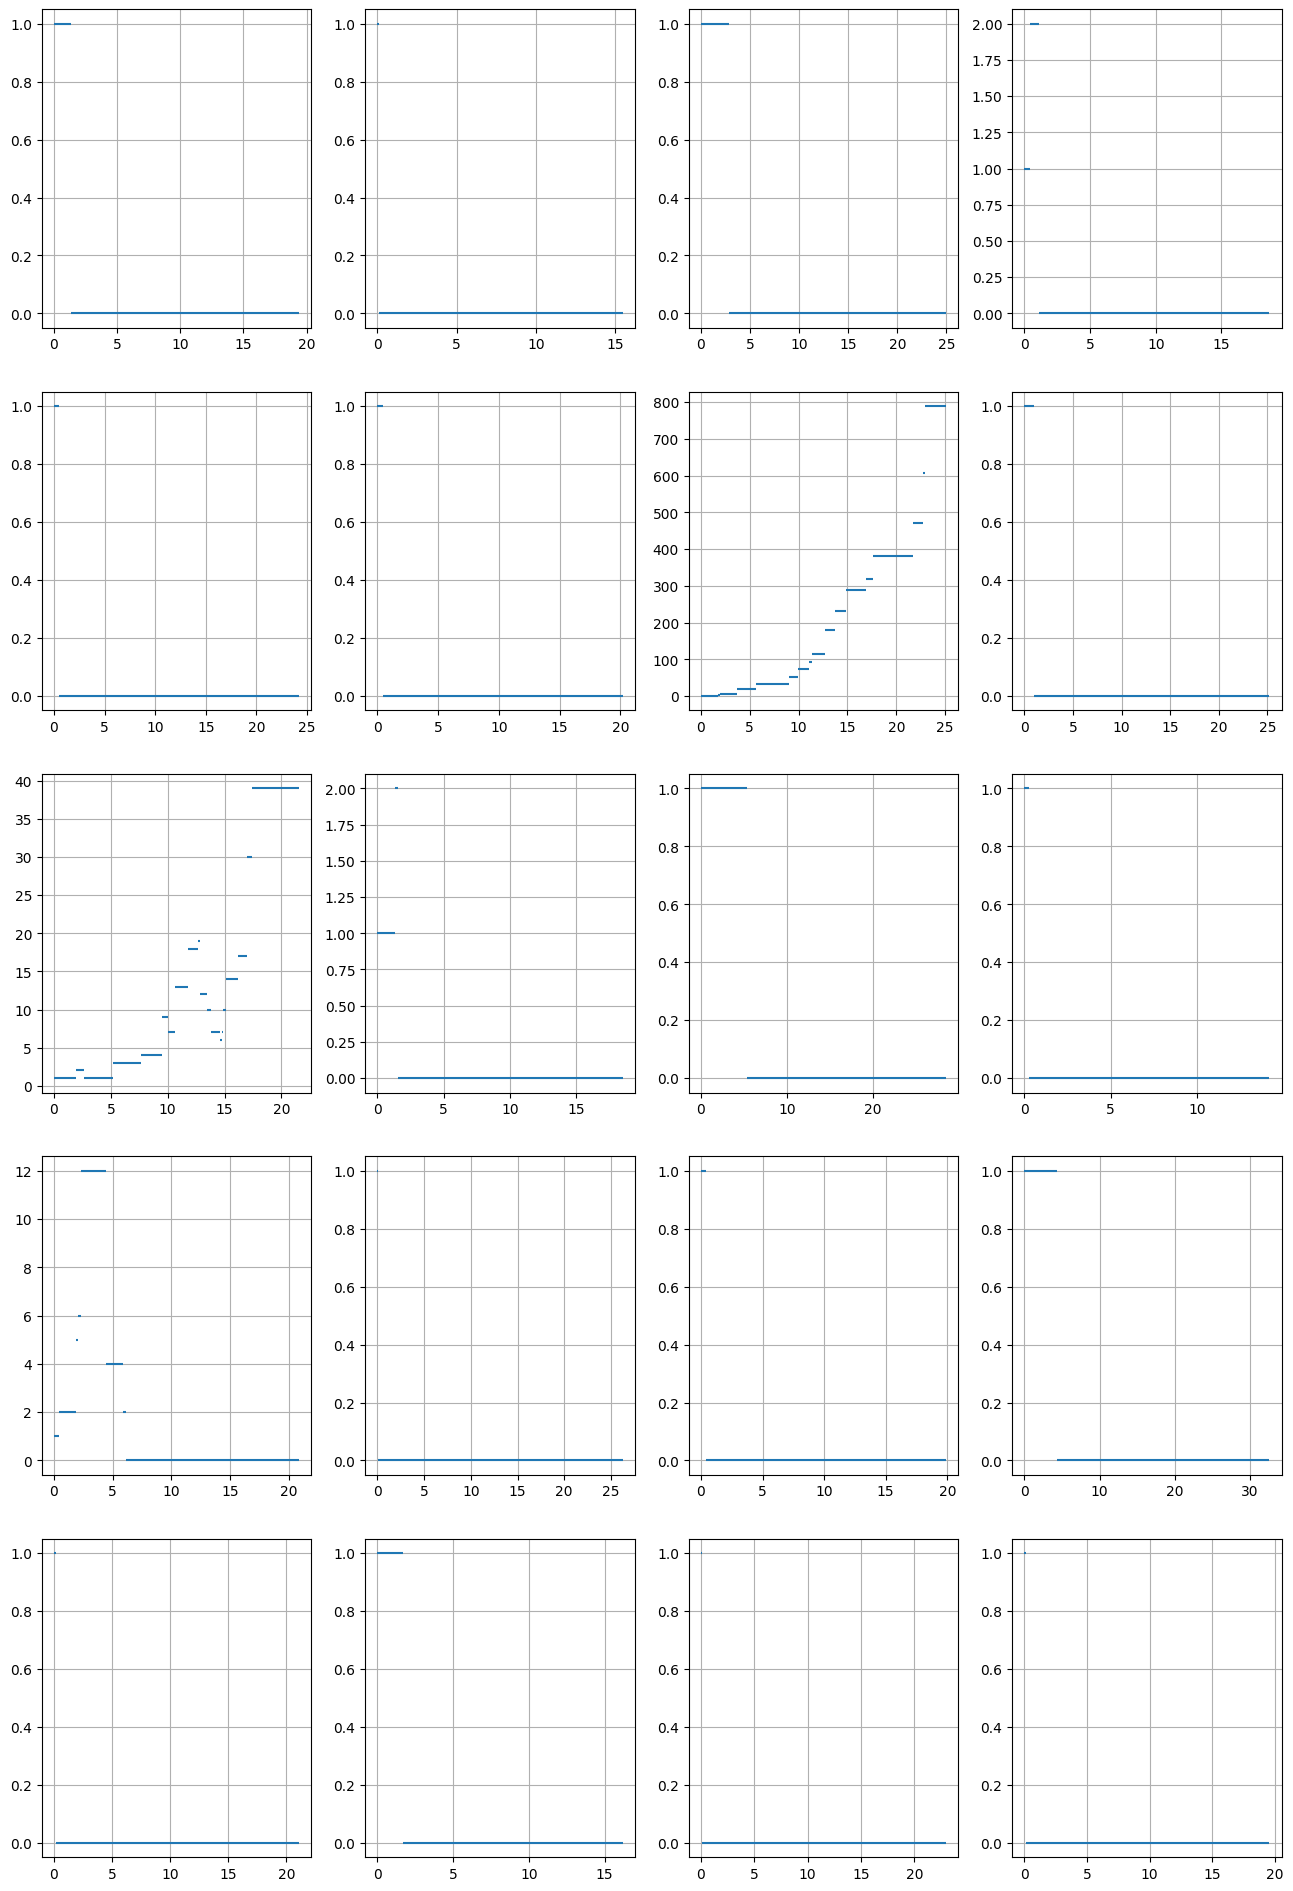

In [ ]:
fig, ax = plt.subplots(k1, k2, figsize = (16, 24))
count = 0
for j in range(k1):
  for m in range(k2):
    Z = np.zeros(n)
    Z[0] = 1
    for i in range(1, n):
      Z[i] = sps.nbinom(Z[i - 1], p).rvs()
      if Z[i] == 0:
        break
    T = sps.expon(scale = 1 / lamb).rvs(size = n)
    ax[j][m].hlines(y = Z, xmin = np.cumsum(np.hstack(([0], T[:-1]))), xmax = np.cumsum(T))
    ax[j][m].grid()
plt.show()

## Задача 4

In [ ]:
p = 0.55

In [ ]:
n = 50
N = 1000

In [ ]:
Z_n = np.empty(N)
for j in tqdm(range(N)):
  Z = np.empty(n)
  Z[0] = 1
  for i in range(1, n):
    Z[i] = sps.nbinom(n = Z[i - 1] + 1, p=p).rvs()
  Z_n[j] = Z[n - 1]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
for k in range(6):
  print(f'P(Z_{n} = {k}) = {np.sum(Z_n == k) / N}')

P(Z_50 = 0) = 0.165
P(Z_50 = 1) = 0.145
P(Z_50 = 2) = 0.145
P(Z_50 = 3) = 0.118
P(Z_50 = 4) = 0.077
P(Z_50 = 5) = 0.062


In [ ]:
for k in range(6):
  print(np.sum(Z_n == k) / np.sum(Z_n == k + 1))

1.1379310344827587
1.0
1.228813559322034
1.5324675324675325
1.2419354838709677
1.1272727272727272


## Задача 5

a) надкритический

In [ ]:
n = 15

In [ ]:
p = 0.45

In [ ]:
while True:
  Z = np.zeros(n, dtype=int)
  Z[0] = 1
  X = []
  curr = 0
  for i in range(1, n):
    for j in range(Z[i - 1]):
      X.append(sps.geom(p).rvs() - 1)
      Z[i] += X[curr]
      curr += 1
    if Z[i] == 0:
      break
  if Z[n - 1] != 0:
    break


In [ ]:
X = np.array(X)

In [ ]:
Z

array([  1,   1,   8,  25,  34,  29,  46,  54,  49,  81,  72,  81, 112,
       114, 160])

In [ ]:
Z.sum(), X.sum(), len(X)

(867, 866, 707)

In [ ]:
X.mean(), (1 - p) / p

(1.224893917963225, 1.2222222222222223)

In [ ]:
np.sum(X == 0) / len(X), p

(0.4639321074964639, 0.45)

In [ ]:
np.sum(X == 1) / len(X), p * (1 - p)

(0.23196605374823195, 0.24750000000000003)

b) критический

In [ ]:
n = 25

In [ ]:
p = 1 / 2

In [ ]:
while True:
  Z = np.zeros(n, dtype=int)
  Z[0] = 1
  X = []
  curr = 0
  for i in range(1, n):
    for j in range(Z[i - 1]):
      X.append(sps.geom(p).rvs() - 1)
      Z[i] += X[curr]
      curr += 1
    if Z[i] == 0:
      break
  if Z[n - 1] != 0:
    break
X = np.array(X)

In [ ]:
Z

array([ 1,  2,  2, 14, 22, 21, 18, 18, 28, 28, 37, 46, 47, 43, 45, 35, 38,
       48, 40, 35, 32, 37, 21, 23, 22])

In [ ]:
Z.sum(), X.sum(), len(X)

(211, 210, 198)

In [ ]:
X.mean(), (1 - p) / p

(1.0308370044052864, 1.0)

In [ ]:
np.sum(X == 0) / len(X), p

(0.5301027900146843, 0.5)

In [ ]:
np.sum(X == 1) / len(X), p * (1 - p)

(0.21585903083700442, 0.25)

# Тема 7

## Задача 1

In [ ]:
Q = np.array([[-4, 1, 3], [2, -3, 1], [3, 2, -5]])
Q

array([[-4,  1,  3],
       [ 2, -3,  1],
       [ 3,  2, -5]])

In [ ]:
P = np.empty(Q.shape)
for i in range(len(P)):
  P[i] = -Q[i] / Q[i, i]
  P[i][i] = 0
P

array([[0.        , 0.25      , 0.75      ],
       [0.66666667, 0.        , 0.33333333],
       [0.6       , 0.4       , 0.        ]])

In [ ]:
n = 20

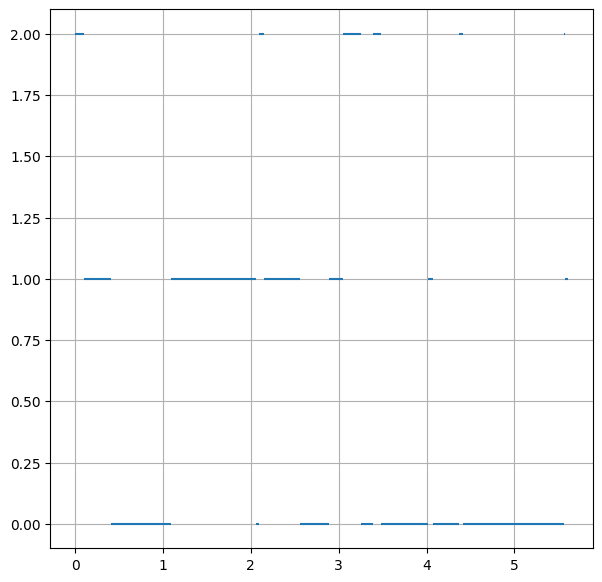

In [ ]:
plt.figure(figsize = (7, 7))
X = np.empty(n, dtype=int)
T = np.empty(n)
X[0] = np.random.choice([0, 1, 2])
T[0] = sps.expon(scale = -1 / Q[X[0], X[0]]).rvs()
for i in range(1, n):
  X[i] = np.random.choice([0, 1, 2], p = P[X[i - 1]])
  T[i] = sps.expon(scale = -1 / Q[X[i], X[i]]).rvs()
plt.hlines(y = X, xmin = np.cumsum(np.hstack(([0], T[:-1]))), xmax = np.cumsum(T))
plt.grid()
plt.show()

## Задача 2

In [ ]:
Q = np.array([[-5, 1, 3, 1], [1, -3, 1, 1], [3, 1, -5, 1], [1, 1, 1, -3]])
Q

array([[-5,  1,  3,  1],
       [ 1, -3,  1,  1],
       [ 3,  1, -5,  1],
       [ 1,  1,  1, -3]])

In [ ]:
np.ones(len(Q)).dot(Q)

array([0., 0., 0., 0.])

In [ ]:
pi = np.ones(len(Q))
pi / np.sum(pi)

array([0.25, 0.25, 0.25, 0.25])

a) вложенная цепь

In [ ]:
P = np.empty(Q.shape)
for i in range(len(P)):
  P[i] = -Q[i] / Q[i, i]
  P[i][i] = 0
P

array([[0.        , 0.2       , 0.6       , 0.2       ],
       [0.33333333, 0.        , 0.33333333, 0.33333333],
       [0.6       , 0.2       , 0.        , 0.2       ],
       [0.33333333, 0.33333333, 0.33333333, 0.        ]])

In [ ]:
np.linalg.eig(P.T)

(array([ 1.        , -0.6       , -0.06666667, -0.33333333]),
 array([[-6.06339063e-01, -7.07106781e-01, -5.00000000e-01,
         -5.08464876e-17],
        [-3.63803438e-01, -5.68236990e-18,  5.00000000e-01,
         -7.07106781e-01],
        [-6.06339063e-01,  7.07106781e-01, -5.00000000e-01,
         -2.06610476e-16],
        [-3.63803438e-01, -1.34571409e-18,  5.00000000e-01,
          7.07106781e-01]]))

In [ ]:
pi_star = np.linalg.eig(P.T)[1][:, 0]
pi_star = pi_star / pi_star.sum()
pi_star

array([0.3125, 0.1875, 0.3125, 0.1875])

б)

In [ ]:
n = 5000

In [ ]:
X = np.empty(n, dtype=int)
T = np.empty(n)
X[0] = np.random.choice([0, 1, 2, 3])
T[0] = sps.expon(scale = -1 / Q[X[0], X[0]]).rvs()
for i in range(1, n):
  X[i] = np.random.choice([0, 1, 2, 3], p = P[X[i - 1]])
  T[i] = sps.expon(scale = -1 / Q[X[i], X[i]]).rvs()
T = np.cumsum(T)
Y = np.empty(n, dtype=int)
Y[0] = X[0]
time = 0
size = n
for i in tqdm(range(1, n)):
  time += sps.expon().rvs()
  if len(np.where((T > time))[0]) == 0:
    size = i
    break
  index = np.where(T > time)[0][0]
  Y[i] = X[index]
Y = Y[:i]

  0%|          | 0/4999 [00:00<?, ?it/s]

In [ ]:
len(Y)

1264

In [ ]:
np.sum(Y == 0) / len(Y), np.sum(Y == 1) / len(Y), np.sum(Y == 2) / len(Y), np.sum(Y == 3) / len(Y)

(0.2721518987341772,
 0.23022151898734178,
 0.24367088607594936,
 0.25395569620253167)

## Задача 3

In [ ]:
n = 20

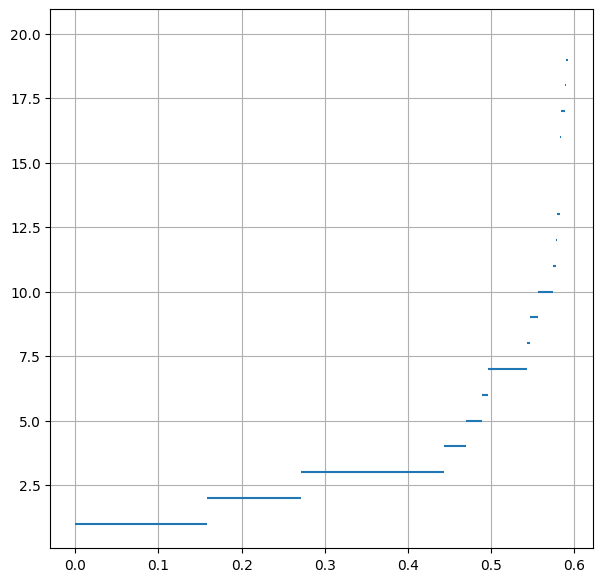

In [ ]:
X = np.empty(n)
T = np.empty(n)
for i in range(1, n + 1):
  X[i - 1] = i
  T[i - 1] = sps.expon(scale = 1 / (i ** 2)).rvs()
plt.figure(figsize=(7, 7))
plt.hlines(y = X, xmin = np.cumsum(np.hstack(([0], T[:-1]))), xmax = np.cumsum(T))
plt.grid()
plt.show()

## Задача 4

a)

In [ ]:
n = 30

In [ ]:
lamb = 1
mu = 1

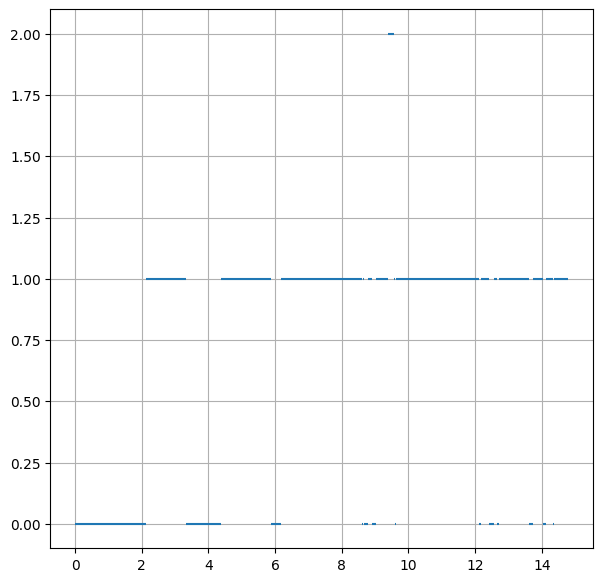

In [ ]:
X = np.empty(n)
T = np.empty(n)
X[0] = 0
T[0] = sps.expon(scale = 1 / lamb).rvs()
for i in range(1, n):
  if X[i - 1] == 0:
    X[i] = 1
    T[i] = sps.expon(scale = 1 / lamb).rvs()
    continue
  if X[i - 1] > 3:
    p = [3 * mu / (lamb + 3 * mu), lamb / (lamb + 3 * mu)]
  else:
    p = [i * mu / (lamb + i * mu), lamb / (lamb + i * mu)]

  X[i] = X[i - 1] + np.random.choice([-1, 1], p = p)

  if X[i] > 3:
    q = lamb + 3 * mu
  else:
    q = lamb + i * mu
  T[i] = sps.expon(scale = 1 / q).rvs()
plt.figure(figsize=(7, 7))
plt.hlines(y = X, xmin = np.cumsum(np.hstack(([0], T[:-1]))), xmax = np.cumsum(T))
plt.grid()
plt.show()

b)

In [ ]:
n = 30

In [ ]:
lamb = 4.5
mu = 1

$
\frac{3 \mu}{λ + 3 \mu} = \frac{λ}{λ + 3\mu}
$

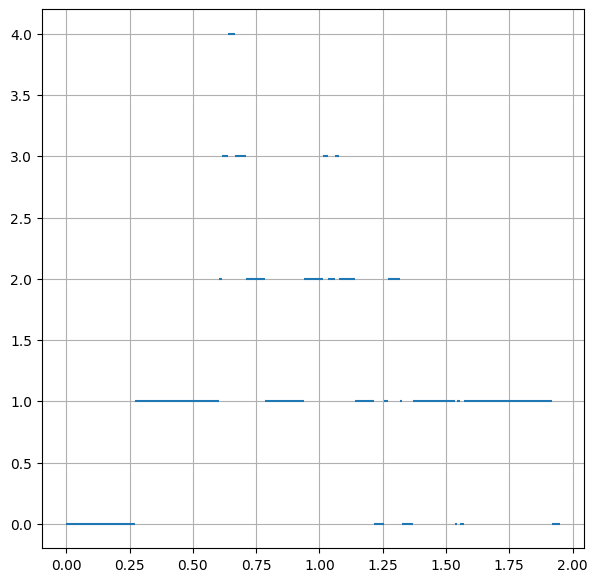

In [ ]:
X = np.empty(n)
T = np.empty(n)
X[0] = 0
T[0] = sps.expon(scale = 1 / lamb).rvs()
for i in range(1, n):
  if X[i - 1] == 0:
    X[i] = 1
    T[i] = sps.expon(scale = 1 / lamb).rvs()
    continue
  if X[i - 1] > 3:
    p = [3 * mu / (lamb + 3 * mu), lamb / (lamb + 3 * mu)]
  else:
    p = [i * mu / (lamb + i * mu), lamb / (lamb + i * mu)]

  X[i] = X[i - 1] + np.random.choice([-1, 1], p = p)

  if X[i] > 3:
    q = lamb + 3 * mu
  else:
    q = lamb + i * mu
  T[i] = sps.expon(scale = 1 / q).rvs()
plt.figure(figsize=(7, 7))
plt.hlines(y = X, xmin = np.cumsum(np.hstack(([0], T[:-1]))), xmax = np.cumsum(T))
plt.grid()
plt.show()

## Задача 5

In [ ]:
f = open('/content/drive/MyDrive/MathPrac/nerve.txt', 'r', encoding='utf-8')
T = f.readlines()
f.close()

In [ ]:
T[0] = '10.5'

In [ ]:
T = np.array(list([float(string.rstrip()) for string in T]))

In [ ]:
T[:10], T[-10:]

(array([10.5,  1.5,  2.5,  5.5, 29.5,  3. ,  9. , 27.5, 18.5,  4.5]),
 array([ 5. ,  5. ,  1.5,  4. ,  7.5,  2.5,  6.5,  1. ,  5. , 25.5]))

In [ ]:
# моменты прыжков
X = np.cumsum(np.hstack(([0], T)))
R = sps.uniform(scale = X.max()).rvs(size = len(T))
J = np.array(list([X[X > R[i]][0] - R[i] for i in range(len(T))]))

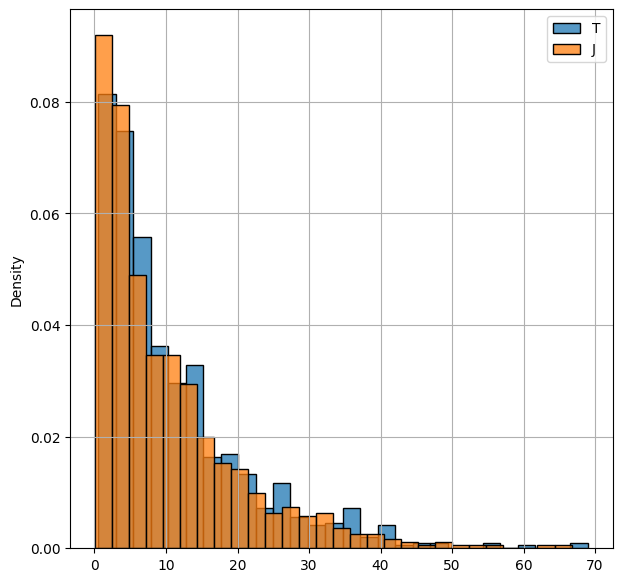

In [ ]:
plt.figure(figsize = (7, 7))
sns.histplot(T, stat='density', label='T')
sns.histplot(J, stat='density', label='J')
plt.legend()
plt.grid()
plt.show()

Проверим с помощью MWW

In [ ]:
sps.mannwhitneyu(T, J)

MannwhitneyuResult(statistic=340463.0, pvalue=0.021144550419533895)

# Тема 8

## Задача 1

a) $\tau \sim exp(\lambda)$

In [ ]:
lamb = 2
n = 200

In [ ]:
J = np.empty(n)
for i in range(n):
  T = sps.expon(scale = 1 / lamb).rvs(size=n)
  # моменты прыжков
  X = np.cumsum(T)
  t = 40
  J[i] = X[X > t][0] - t

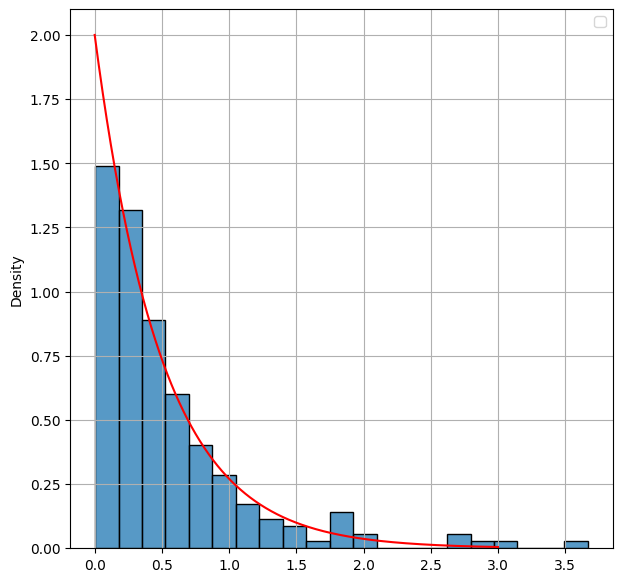

In [ ]:
plt.figure(figsize = (7, 7))
x = np.linspace(0, 3, 1000)
sns.lineplot(x=x, y=sps.expon(scale = 1 / lamb).pdf(x), c='red')
sns.histplot(J, stat='density')
plt.legend()
plt.grid()
plt.show()

b) $\tau \sim R[0, 1]$

In [ ]:
J = np.empty(n)
for i in range(n):
  T = sps.uniform().rvs(size=n)
  # моменты прыжков
  X = np.cumsum(T)
  t = 40
  J[i] = X[X > t][0] - t

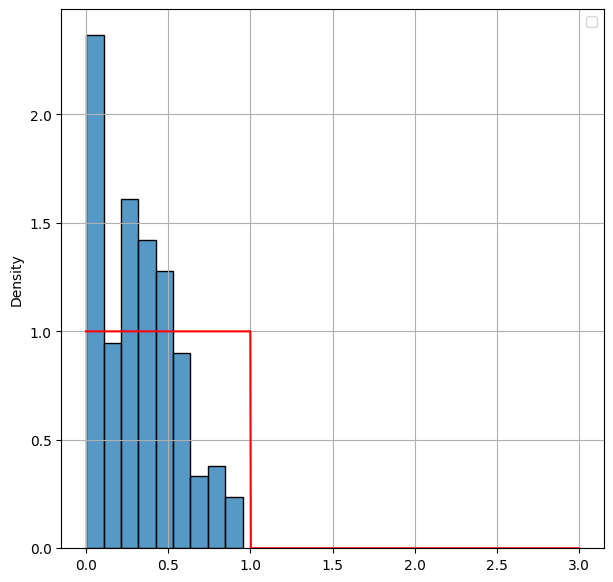

In [ ]:
plt.figure(figsize = (7, 7))
x = np.linspace(0, 3, 1000)
sns.lineplot(x=x, y=sps.uniform().pdf(x), c='red')
sns.histplot(J, stat='density')
plt.legend()
plt.grid()
plt.show()

## Задача 2

a) $\tau \sim exp(2)$

In [ ]:
lamb = 2
n = 300

In [ ]:
L = np.empty(n)
for i in range(n):
  T = sps.expon(scale = 1 / lamb).rvs(size=n)
  # моменты прыжков
  X = np.cumsum(T)
  t = 100
  L[i] = X[X > t][0] - X[X <= t][-1]

In [ ]:
L.mean()

1.0728403120396701

b) $\tau \sim Gamma(2, 1/4)$

In [ ]:
L = np.empty(n)
for i in range(n):
  T = sps.gamma(a = 2, scale = 1/4).rvs(size=n)
  # моменты прыжков
  X = np.cumsum(T)
  t = 100
  L[i] = X[X > t][0] - X[X <= t][-1]

In [ ]:
L.mean()

0.7455800810852479

c) $\tau \sim R[0,1]$

In [ ]:
L = np.empty(n)
for i in range(n):
  T = sps.uniform().rvs(size=n)
  # моменты прыжков
  X = np.cumsum(T)
  t = 100
  L[i] = X[X > t][0] - X[X <= t][-1]

In [ ]:
L.mean()

0.6843427788413563

## Задача 3

In [ ]:
lamb = 2
n = 1000

In [ ]:
T = sps.expon(scale = 1 / lamb).rvs(size=n)
# моменты прыжков
X = np.cumsum(T)
R = sps.uniform(scale = X.max()).rvs(size=n)

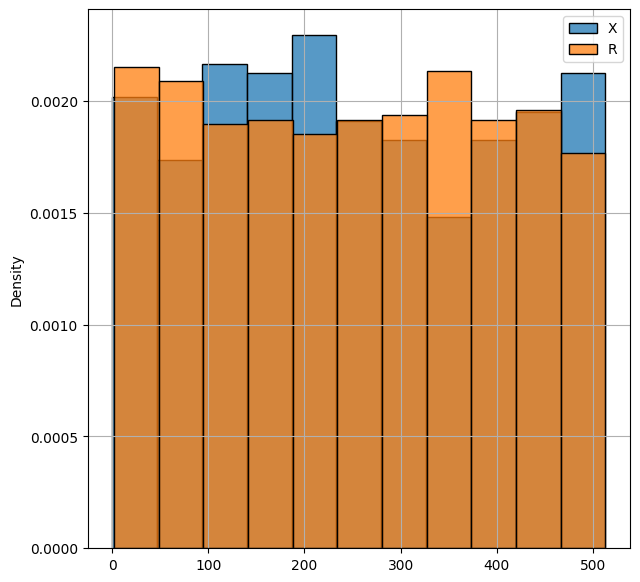

In [ ]:
plt.figure(figsize = (7, 7))
sns.histplot(X, stat='density', label='X')
sns.histplot(R, stat='density', label='R')
plt.legend()
plt.grid()
plt.show()

In [ ]:
sps.mannwhitneyu(X, R)

MannwhitneyuResult(statistic=498449.0, pvalue=0.9044267467600411)

## Задача 4

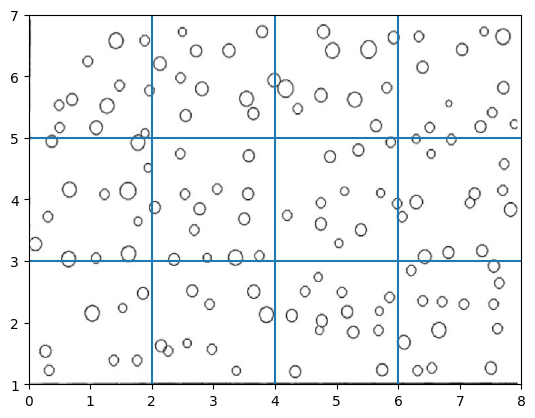

In [ ]:
datafile = '/content/drive/MyDrive/MathPrac/trees.jpg'
img = plt.imread(datafile)
plt.imshow(img, zorder=0, extent=[0.0, 8.0, 1.0, 7.0])
plt.hlines(y=np.arange(3, 7, 2), xmin=0, xmax=8)
plt.vlines(x=np.arange(2, 7, 2), ymin=1, ymax=7)
plt.show()

2 строка 2 столбец: 13 деревьев $⇒$ оценка для числа деревьев: $12 ⋅ 13 = 156 = \widehat{\lambda}$

$
X \sim \mathcal{N}(\widehat{\lambda}, \widehat{\lambda}) \\
\frac{X - \widehat{\lambda}}{\sqrt{\widehat{\lambda}}} \sim \mathcal{N}(0, 1) \\
\frac{X - \widehat{\lambda}}{\sqrt{\widehat{\lambda}}} \in (z_{\alpha/2}, z_{1-\alpha/2}) \\
X \in (\widehat{\lambda} - \sqrt{\widehat{\lambda}} z_{1-\alpha/2}, \widehat{\lambda} + \sqrt{\widehat{\lambda}} z_{1-\alpha/2})
$

In [ ]:
156 - np.sqrt(156) * sps.norm().ppf(1 - 0.05/2), 156 + np.sqrt(156) * sps.norm().ppf(1 - 0.05/2)

(131.52005767922884, 180.47994232077116)

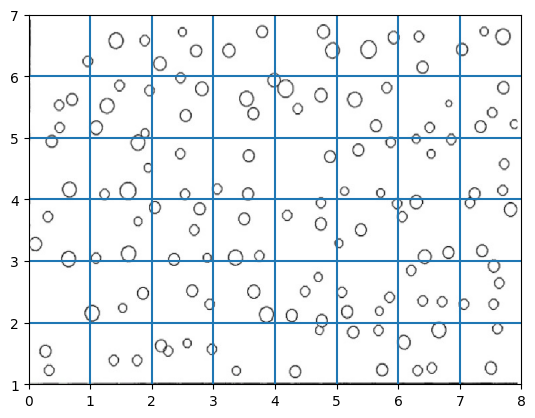

In [ ]:
datafile = '/content/drive/MyDrive/MathPrac/trees.jpg'
img = plt.imread(datafile)
plt.imshow(img, zorder=0, extent=[0.0, 8.0, 1.0, 7.0])
plt.hlines(y=np.arange(2, 7, 1), xmin=0, xmax=8)
plt.vlines(x=np.arange(1, 8, 1), ymin=1, ymax=7)
plt.show()

$3 \cdot (6 \cdot 8) = 144 = \widehat{\lambda}$

In [ ]:
144 - np.sqrt(144) * sps.norm().ppf(1 - 0.05/2), 144 + np.sqrt(144) * sps.norm().ppf(1 - 0.05/2)

(120.48043218551935, 167.51956781448064)

## Задача 5

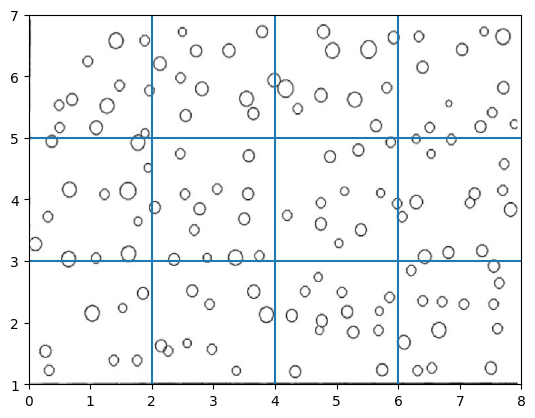

In [ ]:
datafile = '/content/drive/MyDrive/MathPrac/trees.jpg'
img = plt.imread(datafile)
plt.imshow(img, zorder=0, extent=[0.0, 8.0, 1.0, 7.0])
plt.hlines(y=np.arange(3, 7, 2), xmin=0, xmax=8)
plt.vlines(x=np.arange(2, 7, 2), ymin=1, ymax=7)
plt.show()

$
X \sim Poisson(\lambda), Y \sim Poisson(\mu) \\
H_0: \lambda = \mu \\
H_1: \lambda \neq \mu \\
L(x, y; \lambda, \mu) = \frac{\lambda^x}{x!}e^{-\lambda} \frac{\mu^y}{y!}e^{-\mu} \\
lnL = C + x ln\lambda - \lambda + y ln\mu -\mu \\
\frac{\partial lnL}{\partial \lambda} = \frac{x}{\lambda} - 1 = 0 ⇒ \\
\widehat{\lambda} = x \\
\widehat{\mu} = y \\
lnL_0 = C + (x + y) ln\mu - 2\mu \\
\frac{\partial lnL_0}{\partial \mu} = \frac{x+y}{\mu} - 2 = 0 ⇒ \widehat{\mu}_0 = \frac{x+y}{2}
$

$
\Lambda = \frac{L}{L_0}  = \frac{\frac{x^x}{x!}e^{-x} \frac{y^y}{y!}e^{-y}}{\frac{(\frac{x+y}{2})^{x+y}}{x!y!} e^{-(x+y)}} = \frac{x^x y^y}{((x+y)/2)^{x+y}} \\
\text{При } H_0: 2 ln\Lambda \to \xi \sim \chi_1^2
$

2 строчка 1 столбец и последняя ячейка

In [ ]:
x = 11
y = 13
2 * np.log((x ** x) * (y ** y) / (((x + y) / 2) ** (x + y)))

0.1668601057400923

In [ ]:
sps.chi2(df=1).ppf(1 - 0.05)

3.841458820694124

# Тема 9

## Задача 1

(а)

In [ ]:
c = 2
n = 14
N = 1000

In [ ]:
Y = sps.bernoulli(1/2).rvs(size = (N, c * (2 ** n)))
X = list([len([v for v in map(len, ''.join(map(str, Y[i])).split('1')) if v >= n]) for i in range(N)])

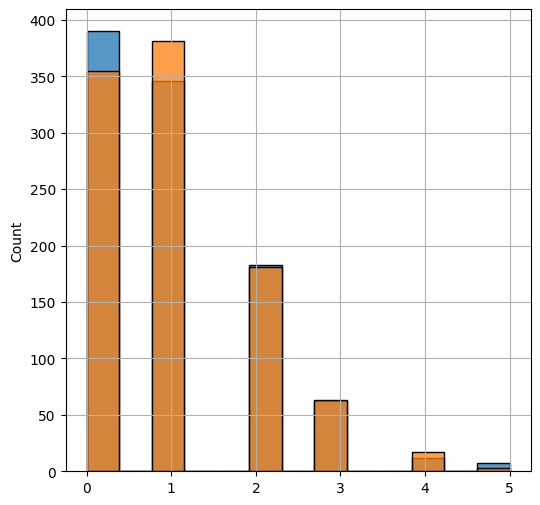

In [ ]:
plt.figure(figsize=(6, 6))
sns.histplot(X)
sns.histplot(sps.poisson(np.array(X).mean()).rvs(size=len(X)))
plt.grid()
plt.show()

(b)

In [ ]:
c = 2
n = 5
N = 1000

In [ ]:
Y = sps.uniform().rvs(size = (N, c * (math.factorial(n) ** 2) * (2 * n + 1)))
X = np.zeros(N)
for i in tqdm(range(N)):
  a = [(k, len(list(g))) for k, g in itertools.groupby(np.diff(Y[i]) > 0)]
  if not a[0][0]:
    a = a[1:]
  for j in range(0, len(a) - 1, 2):
    if a[j][1] >= n and a[j + 1][1] >= n:
      X[i] += 1

  0%|          | 0/1000 [00:00<?, ?it/s]

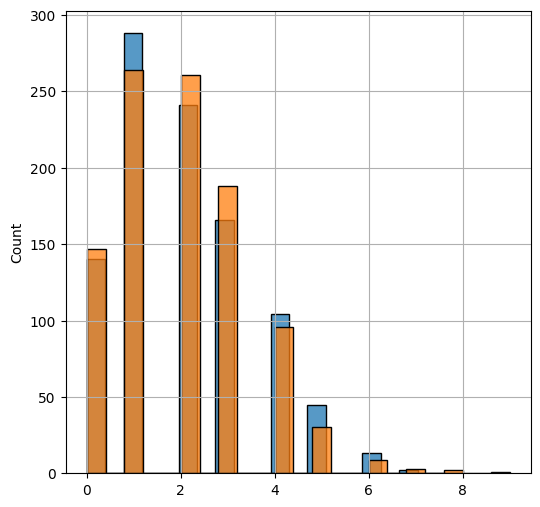

In [ ]:
plt.figure(figsize=(6, 6))
sns.histplot(X)
sns.histplot(sps.poisson(np.array(X).mean()).rvs(size=len(X)))
plt.grid()
plt.show()

## Задача 2

(a)

$
\mathbb{E}\mu_0^{[k]}(T, N) = N^{[k]} (1 - \frac{k}{N})^T \\
\mathbb{D}\mu_0(T, N) = \mathbb{E}\mu_0^{[2]} + \mathbb{E}\mu_0(T, N) - (\mathbb{E}\mu_0(T, N))^2
$

In [ ]:
N = 2500

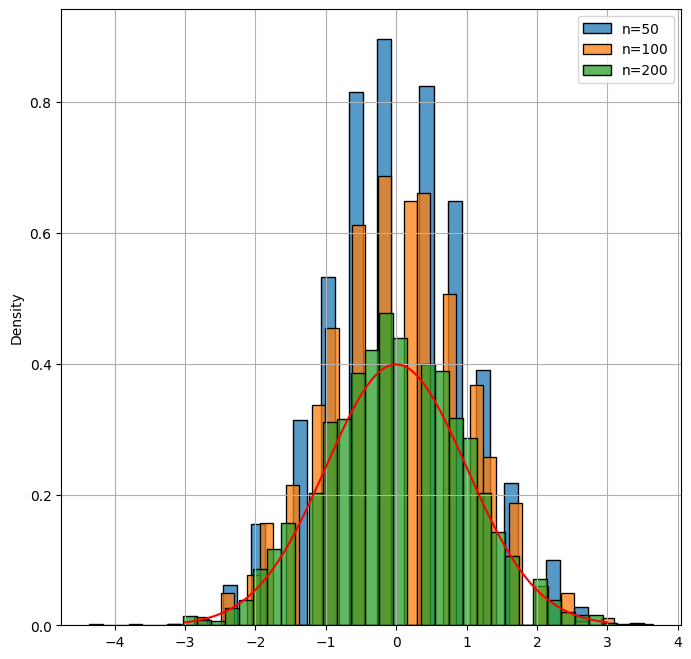

In [ ]:
plt.figure(figsize=(8, 8))
for n in [50, 100, 200]:
  mu = n  * ((1 - 1 / n) ** n)
  sigma = np.sqrt(n * (n - 1) * ((1 - 2 / n) ** n) + mu - mu ** 2)
  Y = sps.multinomial(n=n, p=np.ones(n) / n).rvs(size = N)
  X = np.sum(Y == 0, axis = 1)
  sns.histplot((X - mu) / sigma, label=f'n={n}', stat='density')
x = np.linspace(-3, 3, 3000)
plt.plot(x, sps.norm().pdf(x), color='red')
plt.grid()
plt.legend()
plt.show()

## Задача 3

$
S_n > 2 n \mathbb{E}X \iff S_n - n \mathbb{E}X > n \mathbb{E}X \iff \frac{S_n - n \mathbb{E}X}{\sqrt{n \mathbb{D}X}} > \sqrt{n} \frac{\mathbb{E}X}{\mathbb{D}X} \\
{\bf P}(S_n > 2 n \mathbb{E}X) ≈ {\bf P}(Z > \sqrt{n} \frac{\mathbb{E}X}{\mathbb{D}X}) \\
\phi(h) = \mathbb{E}e^{hX} \\
\lim_{n \to \infty} \frac{1}{n} ln{\bf P}(S_n > a n) = -\sup_{h}(a h - ln \phi(h)) = I(a)
$

In [ ]:
n = 30
N = 500000

(а)

$
X \sim exp(1) \\
\phi(h) = \int_0^\infty e^{hx} e^{-x} dx = \int_0^\infty e ^ {-x (1 - h)} dx =
\begin{cases}
\frac{1}{1 - h}, \; h < 1 \\
\infty, \; h \ge 1
\end{cases}
\\
\psi(h) = ah - ln\phi(h) = a h + ln(1 - h) \\
\frac{d \phi}{d h} = a - \frac{1}{1 - h} = 0 \iff h^{*} = 1 - \frac{1}{a} \text{ -- max} \\
I(a) = - (a h^{*} + ln(1 - h^{*})) = ln a + 1 - a
$

In [ ]:
a = 2 * 1

In [ ]:
1 - sps.norm().cdf(np.sqrt(n)), np.exp(n * (np.log(a) + 1 - a))

(2.1602315269930727e-08, 0.0001004767115486677)

In [ ]:
X = sps.expon().rvs(size = (N, n))
np.sum(np.sum(X, axis=1) > n * a) / N

1.2e-05

(b)

$
X \sim Bern(1/3) \\
\phi(h) = (1 - 1/3) + e^{h} / 3 = \frac{2 + e^h}{3} \\
\psi(h) = a h - ln \frac{2 + e^h}{3} \\
\frac{d \psi}{d h} = a - \frac{e^h}{2 + e^h} = 0 \iff e^h = 2 a + a e^h \iff e^h = \frac{2 a}{1 - a} \iff h^{*} = \ln \frac{2 a}{1 - a} \\
I(a) = -(a h^{*} - ln \frac{2 + e^{h^*}}{3}) = - a \ln \frac{2 a}{1 - a} + ln \frac{2 + \frac{2a}{1-a}}{3} = - a \ln \frac{2 a}{1 - a} + ln \frac{2}{3 (1 - a)}
$

In [ ]:
a = 2 * 1 / 3

In [ ]:
1 - sps.norm().cdf(np.sqrt(n) * 3 / 2), np.exp(n * (-a * np.log(2 * a / (1 - a)) + np.log(2 / (3 * (1-a)))))

(1.1102230246251565e-16, 0.0009765625000000009)

In [ ]:
X = sps.bernoulli(1/3).rvs(size = (N, n))
np.sum(np.sum(X, axis=1) > n * a) / N

4.4e-05

## Задача 5

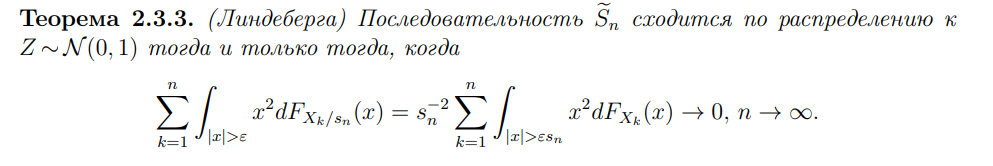

$
X_i \sim P_i
$

(a) \\
a)
$
P_i(i) = P_i(-i) = 1 / (2i^2), P_n(0) = 1 - 1/i^2 \\
\mathbb{E}X_i = 0, \; \mathbb{D}X_i = 1 ⇒ \mathbb{E}S_n = 0, \; s_n^2 = \mathbb{D}S_n = n \\
1 / n \sum_{i=1}^n \int_{|x|>ɛ \sqrt{n}} x^2 dF_{X_k}(x) = 1/n \sum_{i=[ɛ\sqrt{n}]+1}^n 1 = \frac{n - [ɛ\sqrt{n}]}{n} \to 1
$ \\
b)
$
P_i(i) = P_i(-i) = 1 / 4, P_i(0) = 1/2 \\
\mathbb{E}X_i = 0, \; \mathbb{D}X_i = \frac{i^2}{2} ⇒ \mathbb{E}S_n = 0, \; s_n^2 = \mathbb{D}S_n = \frac{n (n + 1) (n + 2)}{12} \\
1/s_n^2 \sum_{i=1}^n \int_{|x|>ɛ s_n} x^2 dF_{X_k}(x) = 1/s_n^2 \sum_{i=[ɛs_n] + 1}^n i^2/2 = 1/s_n^2 (s_n^2 - \sum_{i=1}^{[ɛs_n]} i^2/2) = 1 - \frac{[ɛs_n]([ɛs_n] + 1)([ɛs_n] + 2)}{12 s_n^2} \to 1
$

In [ ]:
n = 5000
N = 5000 # размер выборки S_n^*

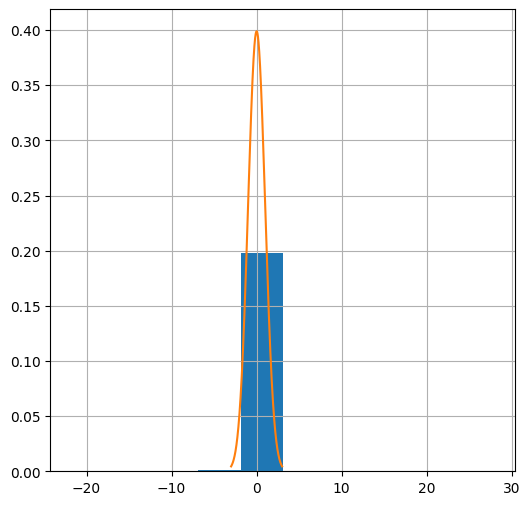

In [ ]:
X = np.empty((n, N))
x = np.linspace(-3, 3, 3000)
for i in range(1, n + 1):
  X[i - 1] = np.random.choice([i, -i, 0], size = N, p = [1 / (2 * (i ** 2)), 1 / (2 * (i ** 2)), 1 - 1 / (i ** 2)])
plt.figure(figsize=(6, 6))
plt.hist(X.sum(axis=0) / np.sqrt(n), density=True)
plt.plot(x, sps.norm().pdf(x))
plt.grid()
plt.show()

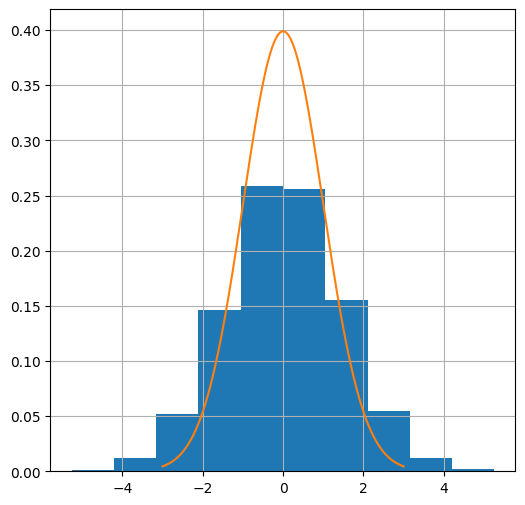

In [ ]:
X = np.empty((n, N))
x = np.linspace(-3, 3, 3000)
for i in range(1, n + 1):
  X[i - 1] = np.random.choice([i, -i, 0], size = N, p = [1 / 4, 1 / 4, 1 / 2])
plt.figure(figsize=(6, 6))
plt.hist(X.sum(axis=0) / np.sqrt(n * (n + 1) * (n + 2) / 12), density=True)
plt.plot(x, sps.norm().pdf(x))
plt.grid()
plt.show()

(b) \\
a)
$
P_i(-\sqrt{i}) = P_i(\sqrt{i}) = 1/2, \text{если } i \text{ -- полный квадрат}, P_i(-1) = P_i(1) = 1/2, \text{ иначе}\\
\mathbb{E}X_i = 0, \mathbb{D}X_i =
\begin{cases}
i, \; i\text{ -- полный квадрат} \\
1, \; \text{иначе}
\end{cases}
⇒ \mathbb{E}S_n = 0, s_n^2 = \mathbb{D}S_n = \sum_{i=1}^n \mathbb{D}X_i \\
1/s_n^2 \sum_{i=1}^n \int_{|x|>ɛ s_n > 1} x^2 dF_{X_k}(x) \le 1/s_n^2 \sum_{i=[ɛ^2 s_n^2] + 1}^n \mathbb{D}X_i
$ \\
b)
$
P_i(i) = P_i(-i) = 1 / (2\sqrt{i}), \; P_i(0) = 1 - 1/\sqrt{i} \\
\mathbb{E}X_i = 0, \mathbb{D}X_i = i \sqrt{i} ⇒ \mathbb{E}S_n = 0, s_n^2 = \mathbb{D}S_n = \sum_{i=1}^n \mathbb{D}X_i  \\
1/s_n^2 \sum_{i=1}^n \int_{|x|>ɛ s_n} x^2 dF_{X_k}(x) = 1/s_n^2 \sum_{i=[ɛs_n] + 1}^n i \sqrt{i}
$

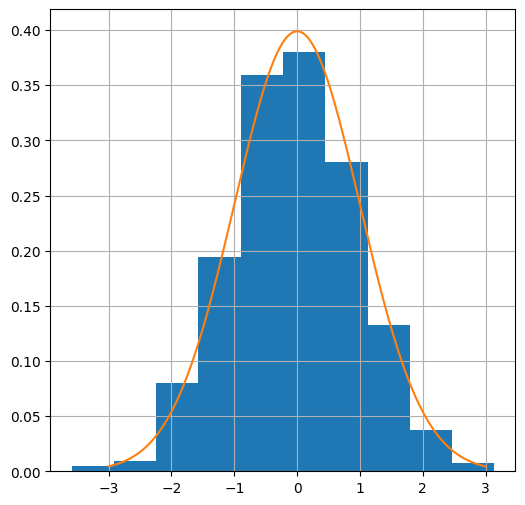

In [ ]:
X = np.empty((n, N))
x = np.linspace(-3, 3, 3000)
for i in range(1, n + 1):
  if np.sqrt(i) == int(np.sqrt(i)):
    X[i - 1] = np.random.choice([np.sqrt(i), -np.sqrt(i)], size = N, p = [1 / 2, 1 / 2])
  else:
    X[i - 1] = np.random.choice([1, -1], size = N, p = [1 / 2, 1 / 2])
plt.figure(figsize=(6, 6))
plt.hist(X.sum(axis=0) / np.sqrt(np.sum([i if np.sqrt(i) == int(np.sqrt(i)) else 1 for i in range(1, n + 1)])), density=True)
plt.plot(x, sps.norm().pdf(x))
plt.grid()
plt.show()

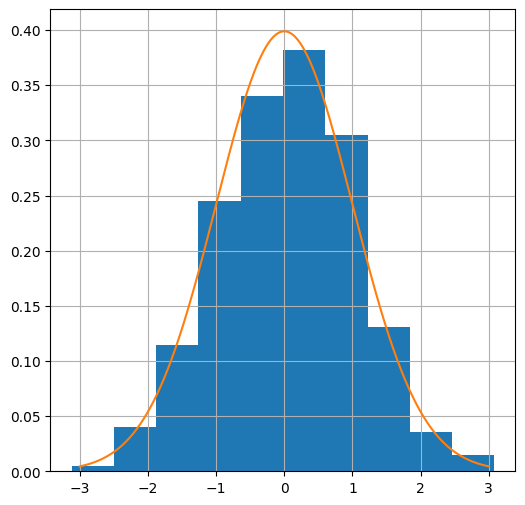

In [ ]:
X = np.empty((n, N))
x = np.linspace(-3, 3, 3000)
for i in range(1, n + 1):
  X[i - 1] = np.random.choice([i, -i, 0], size = N, p = [1 / (2*np.sqrt(i)), 1 / (2*np.sqrt(i)), 1 - 1 / np.sqrt(i)])
plt.figure(figsize=(6, 6))
plt.hist(X.sum(axis=0) / np.sqrt(np.sum([i * np.sqrt(i) for i in range(1, n + 1)])), density=True)
plt.plot(x, sps.norm().pdf(x))
plt.grid()
plt.show()

## Задача 6

(a) \\
$
X_{n, i} \sim Geom(1 - 1/i) \\
\mathbb{E}X_{n,i} = \frac{q}{p} = \frac{1/i}{1-1/i} = \frac{1}{i - 1}, \mathbb{D}X_{n,i} = \frac{q}{p^2} = \frac{i}{(i - 1)^2}
$

In [ ]:
n = 1000
N = 1000

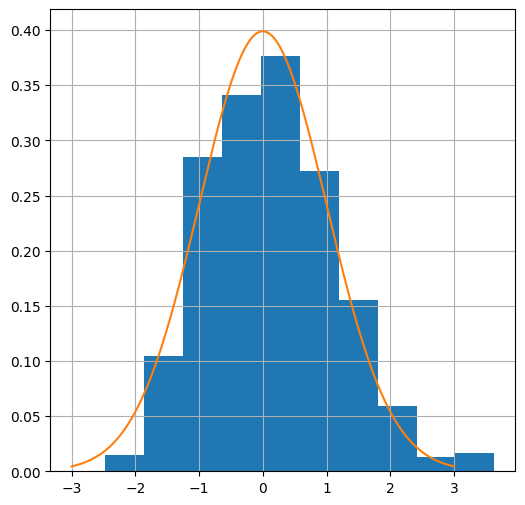

In [ ]:
X = np.empty((n, N))
for i in range(1, n + 1):
  X[i - 1] = sps.geom(1 - 1 / (i + 1)).rvs(size = N) - 1
mu = np.sum([1 / i for i in range(1, n + 1)])
s = np.sqrt(np.sum([(i + 1) / (i ** 2) for i in range(1, n + 1)]))

plt.figure(figsize=(6, 6))
plt.hist((X.sum(axis=0) - mu) / s, density=True)
plt.plot(np.linspace(-3, 3, 3000), sps.norm().pdf(np.linspace(-3, 3, 3000)))
plt.grid()
plt.show()

(b) \\
$
X_{n, i} =
\begin{cases}
\frac{1 - 1/i}{\sqrt{lnn}}, \; p = 1/i \\
-\frac{1}{i\sqrt{lnn}}, \; p = 1 - 1/i
\end{cases} \\
\mathbb{E}X_{n, i} = \frac{1 - 1/i}{i\sqrt{lnn}} - \frac{1}{i\sqrt{lnn}} (1 - 1/i) = 0\\
\mathbb{D}X_{n, i} = \frac{(1 - 1/i) ^ 2}{i lnn} + \frac{1}{i^2 lnn}(1 - 1/i) = \frac{1 - 1/i}{i lnn}(1 -1/i + 1/i) = \frac{1 - 1/i}{i lnn} \\
\psi_{S_n}(t) = \prod_{k=1}^n (e^{it (1/ \sqrt{lnn} - 1/(k\sqrt{lnn}))} 1/k + e ^ {-it/(k\sqrt{lnn})} (1 - 1/k)) = \prod_{k=1}^n e ^ {-it/(k\sqrt{lnn})} (\frac{e^{it/\sqrt{lnn}} - 1}{k} + 1)
$

In [ ]:
n = 5000
N = 1000

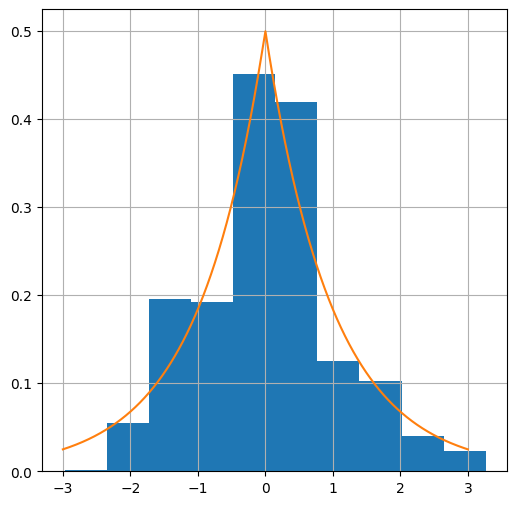

In [ ]:
X = np.empty((n, N))
for i in range(1, n + 1):
  X[i - 1] = np.random.choice([(1 - 1/i) / np.sqrt(np.log(n)), -1 / (i * np.sqrt(np.log(n)))],
                              p = [1 / i, 1 - 1 / i], size = N)
mu = 0
s = np.sqrt(np.sum([(1 - 1 / i) / (i * np.log(n)) for i in range(1, n + 1)]))
plt.figure(figsize=(6, 6))
plt.hist((X.sum(axis=0) - mu) / s, density=True)
plt.plot(np.linspace(-3, 3, 3000), sps.laplace().pdf(np.linspace(-3, 3, 3000)))
plt.grid()
plt.show()

(c)
$
X_{n, i} \sim NegBin(1/n, 1/n) / n \\
\mathbb{E}X_{n,i} = (1/n * (1 - 1/n) / (1/n)) / n = (1 - 1/n) / n = \frac{n - 1}{n^2} \\
\mathbb{D}X_{n,i} = (1 - 1/n) n  / n^2 = \frac{n - 1}{n^2}
$

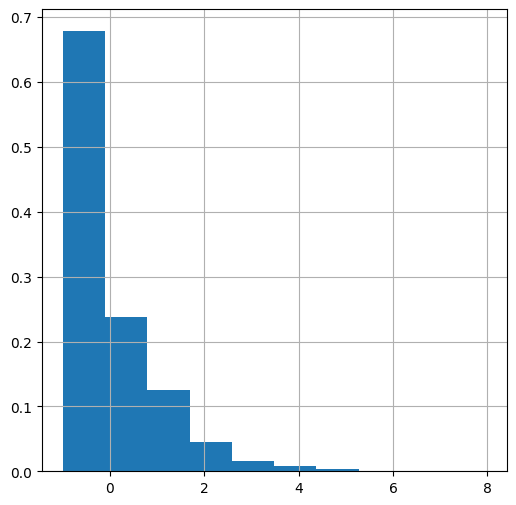

In [ ]:
X = np.empty((n, N))
for i in range(1, n + 1):
  X[i - 1] = sps.nbinom(1/n, 1/n).rvs(size=N) / n
mu = 1 - 1/n
s = np.sqrt(mu)
plt.figure(figsize=(6, 6))
plt.hist((X.sum(axis=0) - mu) / s, density=True)
#plt.plot(np.linspace(-3, 3, 3000), sps.expon().pdf(np.linspace(-3, 3, 3000)))
plt.grid()
plt.show()

# Тема 10

## Задача 1

$
X_t = \sum_{n=1}^\infty Z_n \frac{\sin{\pi n t}}{n}
$

In [ ]:
n = 2000

  0%|          | 0/2000 [00:00<?, ?it/s]

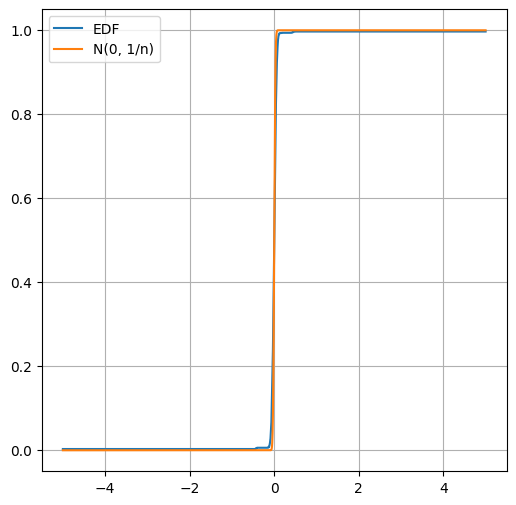

In [ ]:
X = np.empty(n)
Z = sps.norm().rvs(size=n)
for t in tqdm([i / n for i in range(n)]):
  X[int(t * n)] = Z.dot([np.sin(np.pi * i * t) / i for i in range(1 , n + 1)])
plt.figure(figsize=(6, 6))
x = np.linspace(-5, 5, 5000)
plt.plot(x, EDF(x, np.diff(X)), label='EDF')
plt.plot(x, sps.norm(scale = np.sqrt(1/n)).cdf(x), label='N(0, 1/n)')
plt.grid()
plt.legend()
plt.show()

In [ ]:
sps.shapiro(np.diff(X)).pvalue

0.5284469127655029

## Задача 2

In [ ]:
n = 3000

In [ ]:
X = np.empty(n)
Z = sps.norm().rvs(size=n)
for t in [i / n for i in range(n)]:
  X[int(t * n)] = Z.dot([np.sin(np.pi * i * t) / i for i in range(1 , n + 1)])

In [ ]:
X = np.cumsum(sps.norm(scale = np.sqrt(1 / n)).rvs(size = n))

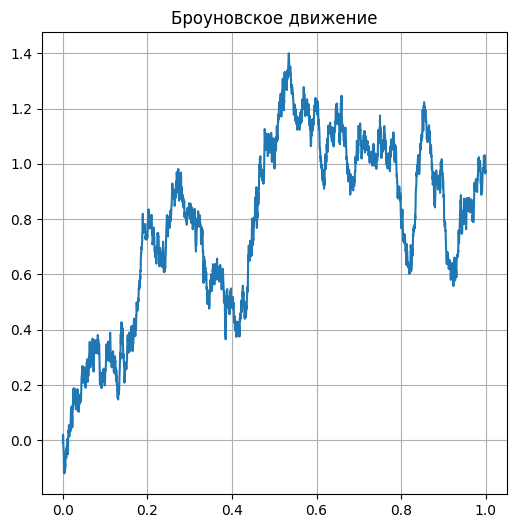

In [ ]:
t = [i / n for i in range(n)]
plt.figure(figsize=(6, 6))
plt.plot(t, X)
plt.title('Броуновское движение')
plt.grid()
plt.show()

In [ ]:
for h in [1 / n, 2 / n, 5 / n, 10 / n, 20 / n, 50 / n, 100 / n]:
  print(f'Шаг = {h}, Вариация = {np.sum(np.abs(np.diff(X[::int(h * n)])))}')

Шаг = 0.0003333333333333333, Вариация = 44.60415069924939
Шаг = 0.0006666666666666666, Вариация = 32.15262017260431
Шаг = 0.0016666666666666668, Вариация = 20.100608330858037
Шаг = 0.0033333333333333335, Вариация = 14.028408450837057
Шаг = 0.006666666666666667, Вариация = 8.500412363967076
Шаг = 0.016666666666666666, Вариация = 5.9379749179497185
Шаг = 0.03333333333333333, Вариация = 3.872769438933247


In [ ]:
for h in [1 / n, 2 / n, 5 / n, 10 / n, 20 / n, 50 / n, 100 / n]:
  print(f'Шаг = {h}, Квадратичная вариация = {np.sum((np.diff(X[::int(h * n)])) ** 2)}')

Шаг = 0.0003333333333333333, Квадратичная вариация = 1.0505536883086417
Шаг = 0.0006666666666666666, Квадратичная вариация = 1.109329669858094
Шаг = 0.0016666666666666668, Квадратичная вариация = 1.057560002912735
Шаг = 0.0033333333333333335, Квадратичная вариация = 1.0666373259659547
Шаг = 0.006666666666666667, Квадратичная вариация = 0.8557691085407972
Шаг = 0.016666666666666666, Квадратичная вариация = 0.9850420758523946
Шаг = 0.03333333333333333, Квадратичная вариация = 0.7599849993821138


In [ ]:
X[:10]

array([ 0.00000000e+000,  4.80556570e-003, -7.66451344e-003,
        7.08843255e-316, -4.84871438e-002, -9.75469762e-002,
        6.95015592e-310, -1.00448326e-001, -1.26738858e-001,
       -1.41894717e-001])

## Задача 3

In [ ]:
n = 1000

In [ ]:
X = np.empty(n)
Z = sps.norm().rvs(size=n)
for t in [i / n for i in range(n)]:
  X[int(t * n)] = Z.dot([np.sin(np.pi * i * t) / i for i in range(1 , n + 1)])

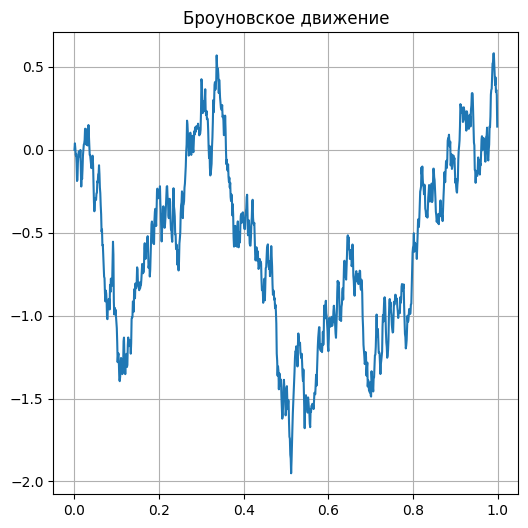

In [ ]:
t = [i / n for i in range(n)]
plt.figure(figsize=(6, 6))
plt.plot(t, X)
plt.title('Броуновское движение')
plt.grid()
plt.show()

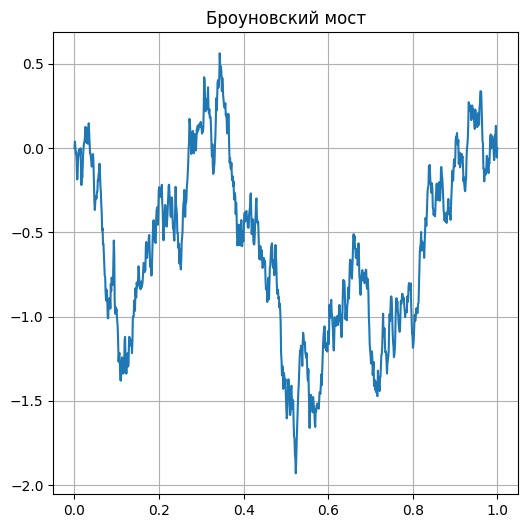

In [ ]:
t0 = np.where(X[1 : len(X) - 1] * X[2:] < 0)[0][-1] + 1
t = [i / t0 for i in range(t0)]
plt.figure(figsize=(6, 6))
plt.plot(np.hstack((t, 1)), np.sqrt(t0 / n) * np.hstack((X[:t0], 0)))
plt.title('Броуновский мост')
plt.grid()
plt.show()

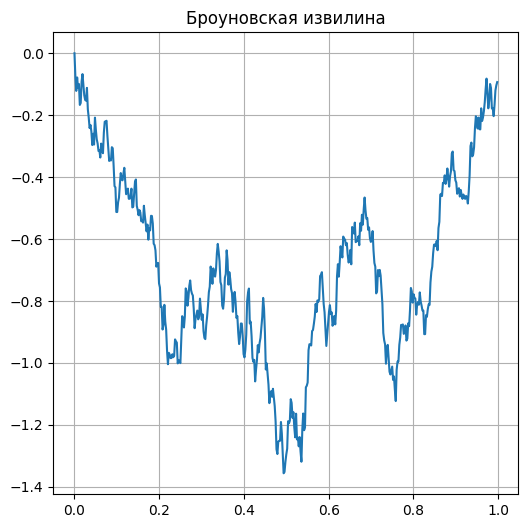

In [ ]:
t0 = np.where(X[1 : len(X) - 1] * X[2:] < 0)[0][-1] + 1
t = [i / (n - t0) for i in range(n - t0)]
plt.figure(figsize=(6, 6))
plt.plot(t, np.sqrt((n - t0) / n) * np.hstack((0, X[t0 + 1:])))
plt.title('Броуновская извилина')
plt.grid()
plt.show()

In [ ]:
Y = np.empty(n)
Z = sps.norm().rvs(size=n)
for t in [i / n for i in range(n)]:
  Y[int(t * n)] = Z.dot([np.sin(np.pi * i * t) / i for i in range(1 , n + 1)])
Y = Y + X[-1]
t1 = np.where(Y[1 : len(Y) - 1] * Y[2:] < 0)[0][0] + 1

609

In [ ]:
t1 = n + t1

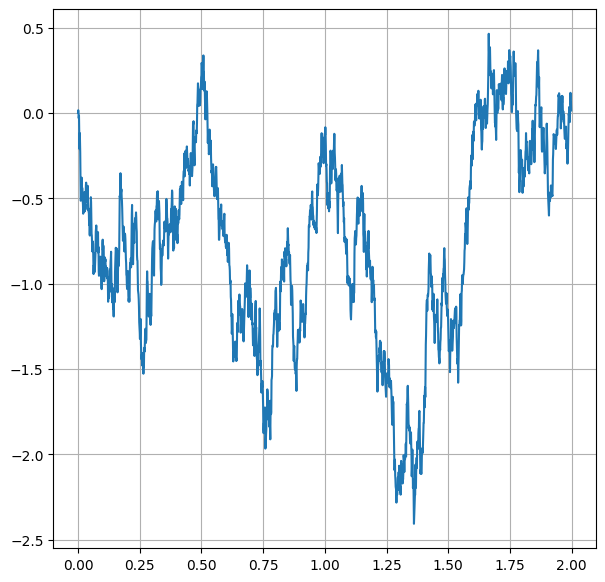

In [ ]:
plt.figure(figsize=(7, 7))
plt.plot([i / n for i in range(2 * n - 1)], np.hstack((X, Y[1:])))
plt.grid()
plt.show()

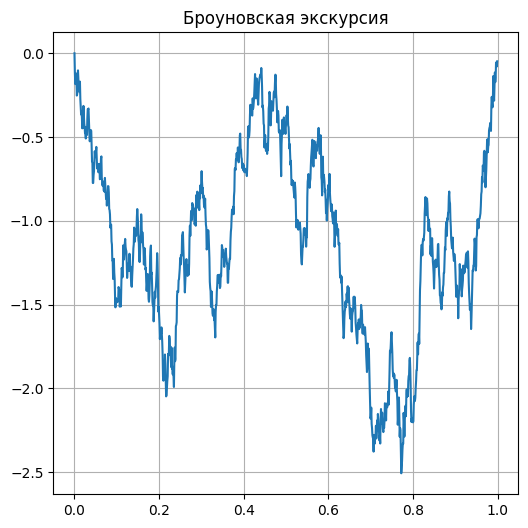

In [ ]:
t = [i / (t1 - t0) for i in range(t1 - t0)]
plt.figure(figsize=(6, 6))
plt.plot(t, np.sqrt((t1 - t0) / n) * np.hstack((X, Y))[t0 : t1])
plt.title('Броуновская экскурсия')
plt.grid()
plt.show()

## Задача 4

(a)
$
X_i \sim \mathcal{N}(0, 1)
$

In [ ]:
n = 1000
N = 1000

In [ ]:
X = sps.norm().rvs(size = (N, n))

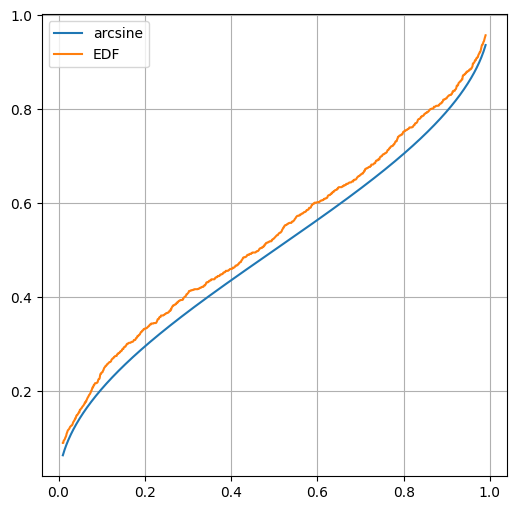

In [ ]:
x = np.linspace(0.01, 0.99, 1000)
S = np.cumsum(X, axis=1)
t0 = np.array([0 if len(np.where(S[i, 1 : n - 1] * S[i, 2:] < 0)[0]) == 0
                    else np.where(S[i, 1 : n - 1] * S[i, 2:] < 0)[0][-1] + 1
                    for i in range(N)]) / n

plt.figure(figsize = (6, 6))
plt.plot(x, sps.arcsine().cdf(x), label='arcsine')
plt.plot(x, EDF(x, t0), label='EDF')
plt.grid()
plt.legend()
plt.show()

(b)

In [ ]:
n = 1000
N = 1000

In [ ]:
X = np.random.choice([-1, 1], p = [1 / 2, 1 / 2], size = (N, n))

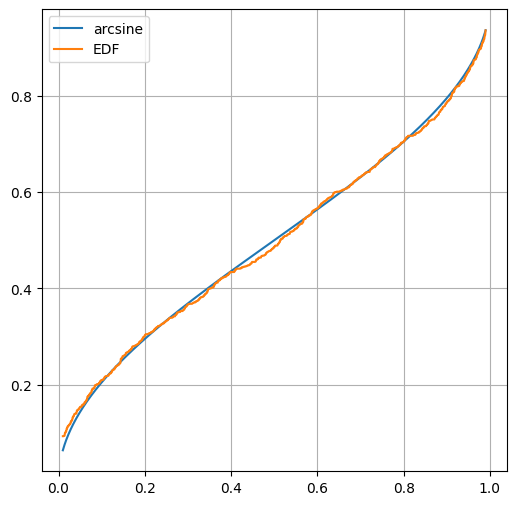

In [ ]:
x = np.linspace(0.01, 0.99, 1000)
S = np.cumsum(X, axis=1)
t0 = np.array([0 if len(np.where(S[i] == 0)[0]) == 0 else np.where(S[i] == 0)[0][-1] + 1for i in range(N)]) / n

plt.figure(figsize = (6, 6))
plt.plot(x, sps.arcsine().cdf(x), label='arcsine')
plt.plot(x, EDF(x, t0), label='EDF')
plt.grid()
plt.legend()
plt.show()

(c) \\
$
X = \delta ɛ \\
P(\delta = -1) = P(\delta = 1) = 1 / 2 \\
P(ɛ > x) = 1 / x^{7/6}, \; x \ge 1 \\
F_ɛ^{-1}(x) = y \iff x = F_ɛ(y) = 1 - 1 / y^{7/6} \iff 1 / y^{7/6} = 1 - x \iff y = (\frac{1}{1 - x}) ^ {6/7}
$

In [ ]:
n = 5000
N = 5000

In [ ]:
R = sps.uniform().rvs(size = (N, n))
e = (1 / (1 - R)) ** (6 / 7)
delta = np.random.choice([-1, 1], p = [1 / 2, 1 / 2], size = (N, n))
X = delta * e

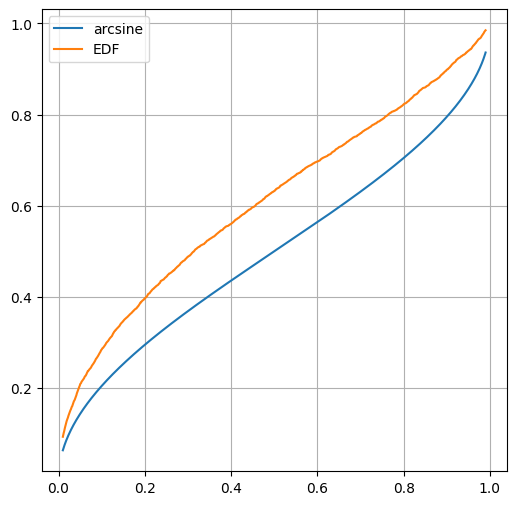

In [ ]:
x = np.linspace(0.01, 0.99, 1000)
S = np.cumsum(X, axis=1)
t0 = np.array([0 if len(np.where(S[i, 1 : n - 1] * S[i, 2:] < 0)[0]) == 0
                    else np.where(S[i, 1 : n - 1] * S[i, 2:] < 0)[0][-1] + 1
                    for i in range(N)]) / n

plt.figure(figsize = (6, 6))
plt.plot(x, sps.arcsine().cdf(x), label='arcsine')
plt.plot(x, EDF(x, t0), label='EDF')
plt.grid()
plt.legend()
plt.show()

## Задача 5

In [ ]:
n = 1000
N = 1000

In [ ]:
X = np.empty((N, n))
Y = np.hstack((np.ones(int(n / 2)), -np.ones(int(n / 2))))
for i in range(N):
  X[i] = np.random.permutation(Y)

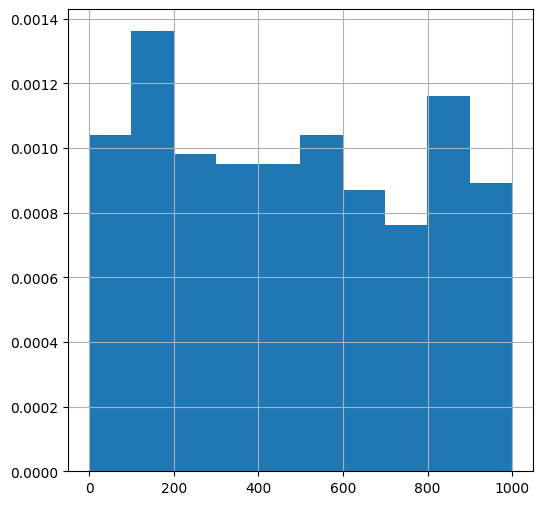

In [ ]:
S = np.cumsum(X, axis = 1)
plt.figure(figsize=(6, 6))
plt.hist(np.sum(S > 0, axis = 1), density=True)
plt.grid()
plt.show()